In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/newparticulate_covidstat.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = in_datapaper
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   siena
   2   l_aquila
   3   salerno
   4   pesaro
   5   como
   6   rovigo
   7   frosinone
   8   oristano
   9   gorizia
   10   carbonia
   11   sassari
   12   pistoia
   13   chieti
   14   taranto
   15   vibo_valentia
   16   lodi
   17   trieste
   18   lecco
   19   pisa
   20   vercelli
   21   perugia
   22   belluno
   23   siracusa
   24   pordenone
   25   napoli
   26   brescia
   27   ferrara
   28   imperia
   29   sondrio
   30   trento
   31   enna
   32   verbania
   33   firenze
   34   prato
   35   avellino
   36   bari
   37   piacenza
   38   isernia
   39   catania
   40   bat
   41   matera
   42   reggio_di_calabria
   43   biella
   44   bologna
   45   savona
   46   novara
   47   grosseto
   48   udine
   49   cremona
   50   monza
   51   brindisi
   52   alessandria
   53   agrigento
   54   asti
   55   bolzano
   56   ancona
   57   teramo
   58   mantova
   59   cosen

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 siena
2 l_aquila
3 salerno
4 pesaro
5 como
6 rovigo
7 frosinone
8 oristano
9 gorizia
10 sassari
11 pistoia
12 chieti
13 taranto
14 vibo_valentia
15 lodi
16 trieste
17 lecco
18 pisa
19 vercelli
20 perugia
21 belluno
22 siracusa
23 pordenone
24 napoli
25 brescia
26 ferrara
27 imperia
28 sondrio
29 trento
30 enna
31 verbania
32 firenze
33 prato
34 avellino
35 bari
36 piacenza
37 catania
38 bat
39 matera
40 reggio_di_calabria
41 biella
42 bologna
43 savona
44 novara
45 grosseto
46 udine
47 cremona
48 monza
49 brindisi
50 alessandria
51 agrigento
52 asti
53 bolzano
54 ancona
55 teramo
56 mantova
57 cosenza
58 verona
59 massa
60 trapani
61 latina
62 modena
63 reggio_nell_emilia
64 rieti
65 torino
66 milano
67 messina
68 ascoli_piceno
69 rimini
70 forli
71 nuoro
72 venezia
73 lecce
74 caltanissetta
75 bergamo
76 padova
77 benevento
78 varese
79 caserta
80 arezzo
81 genova
82 treviso
83 livorno
84 ragusa
85 campobasso
86 cuneo
87 fermo
88 viterbo
89 macerata
90 ravenna
91 pescara
92 pavia
93

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

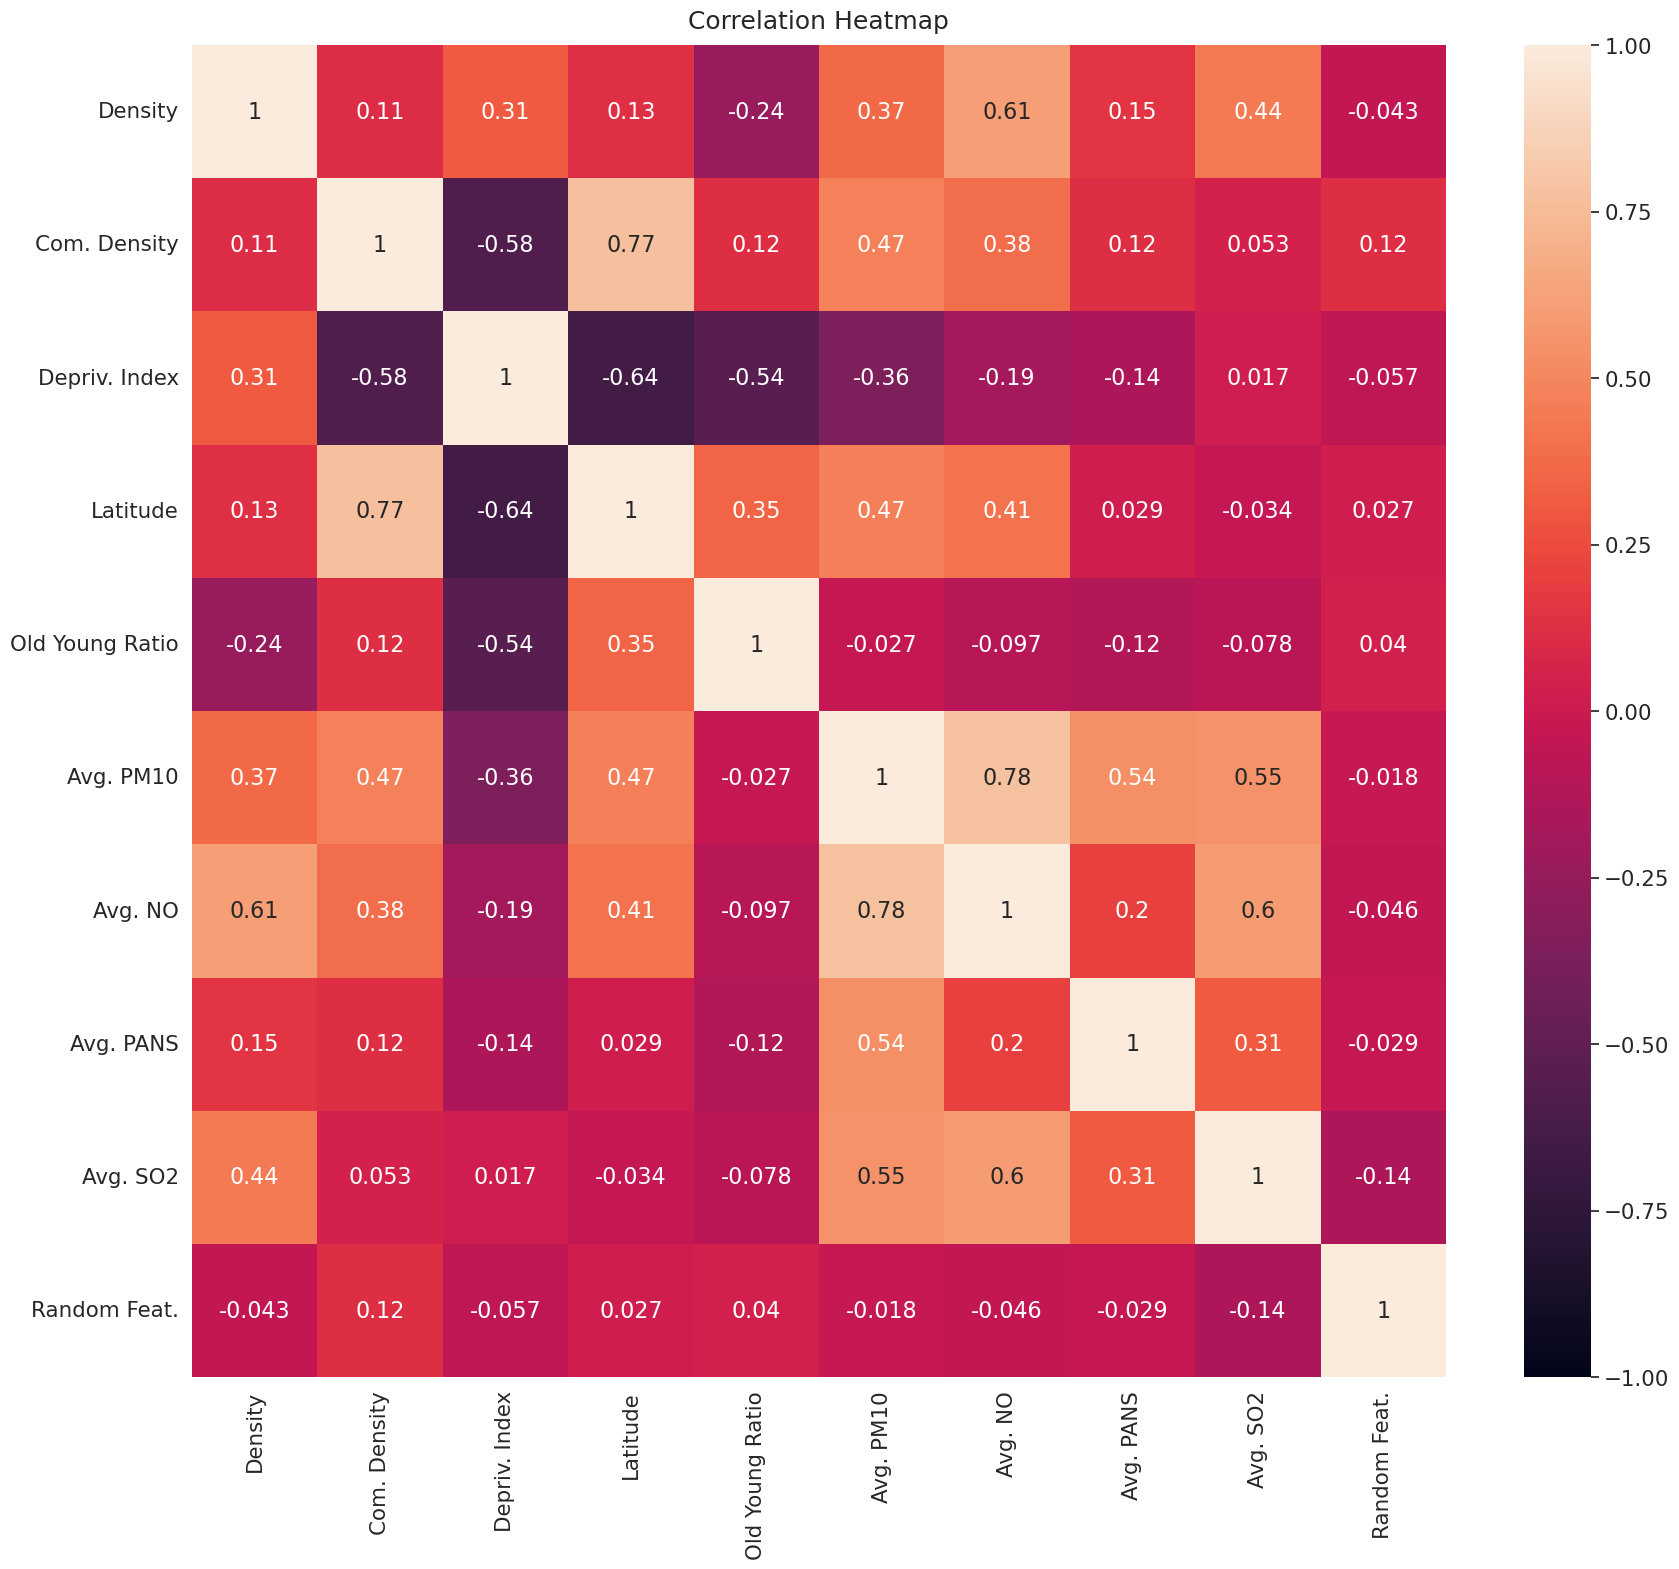

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.34220  0.03062 
    Test set average RMSE:  0.90561  0.07425 

Prediction STD :    1.25450
True value STD :    1.43281
Difference in percentage:   12.44492

             Fullset RMSE:    0.32334
                       R2:    0.94907


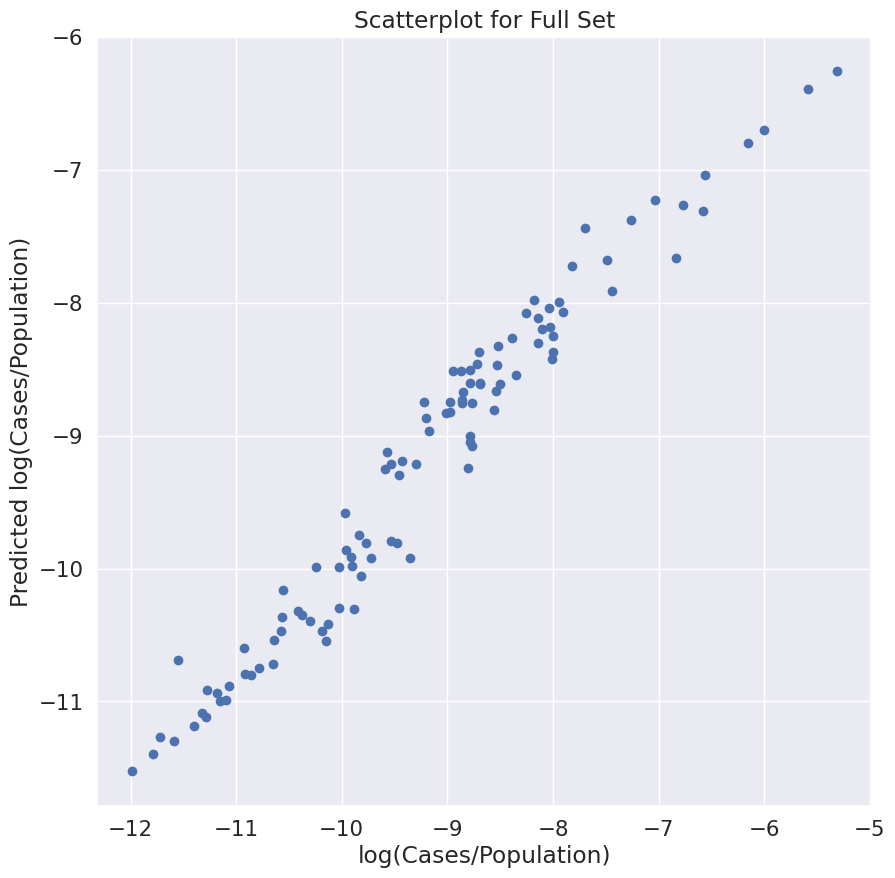

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.22691 +/- 0.03812
Feature:                  Depriv. Index, Score: 0.10964 +/- 0.01315
Feature:                       Latitude, Score: 0.83729 +/- 0.10212
Feature:                Old Young Ratio, Score: 0.10034 +/- 0.01153
Feature:                      Avg. PM10, Score: 0.17812 +/- 0.02167
Feature:                        Avg. NO, Score: 0.18483 +/- 0.02240
Feature:                       Avg. SO2, Score: 0.07659 +/- 0.00946


<Figure size 640x480 with 0 Axes>

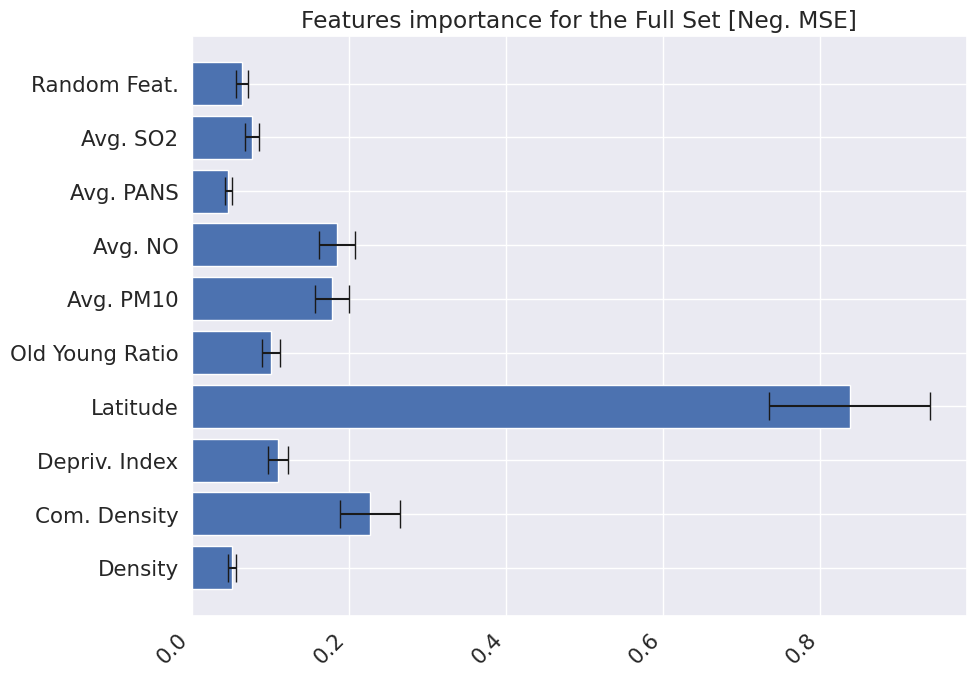

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.11053 +/- 0.01857
Feature:                  Depriv. Index, Score: 0.05340 +/- 0.00641
Feature:                       Latitude, Score: 0.40785 +/- 0.04975
Feature:                Old Young Ratio, Score: 0.04888 +/- 0.00562
Feature:                      Avg. PM10, Score: 0.08676 +/- 0.01056
Feature:                        Avg. NO, Score: 0.09003 +/- 0.01091
Feature:                       Avg. SO2, Score: 0.03731 +/- 0.00461


<Figure size 640x480 with 0 Axes>

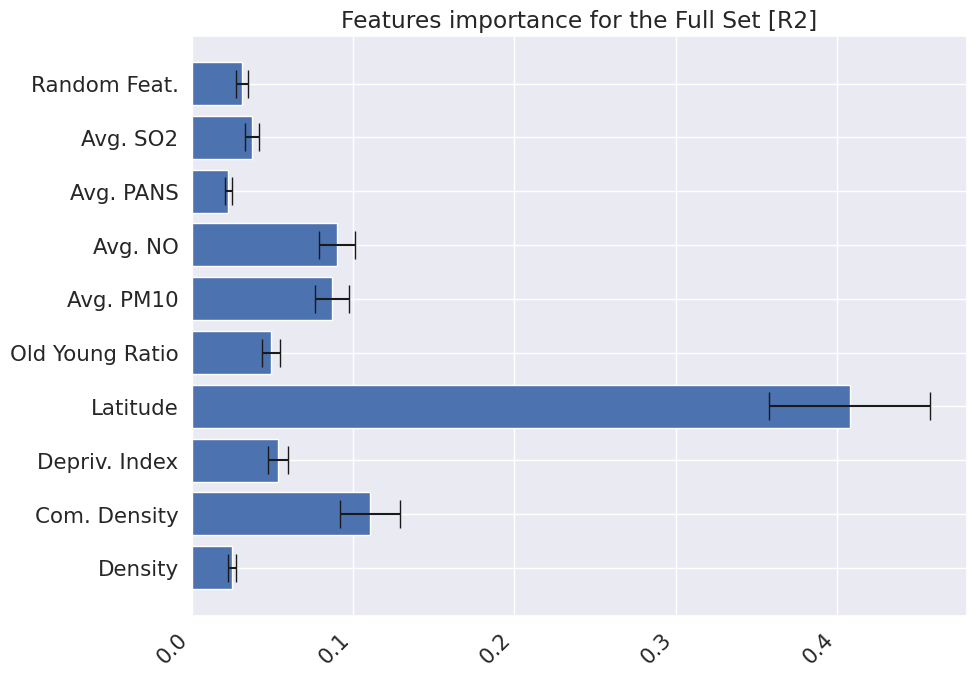

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.34137
                       R2:    0.93482


<Figure size 640x480 with 0 Axes>

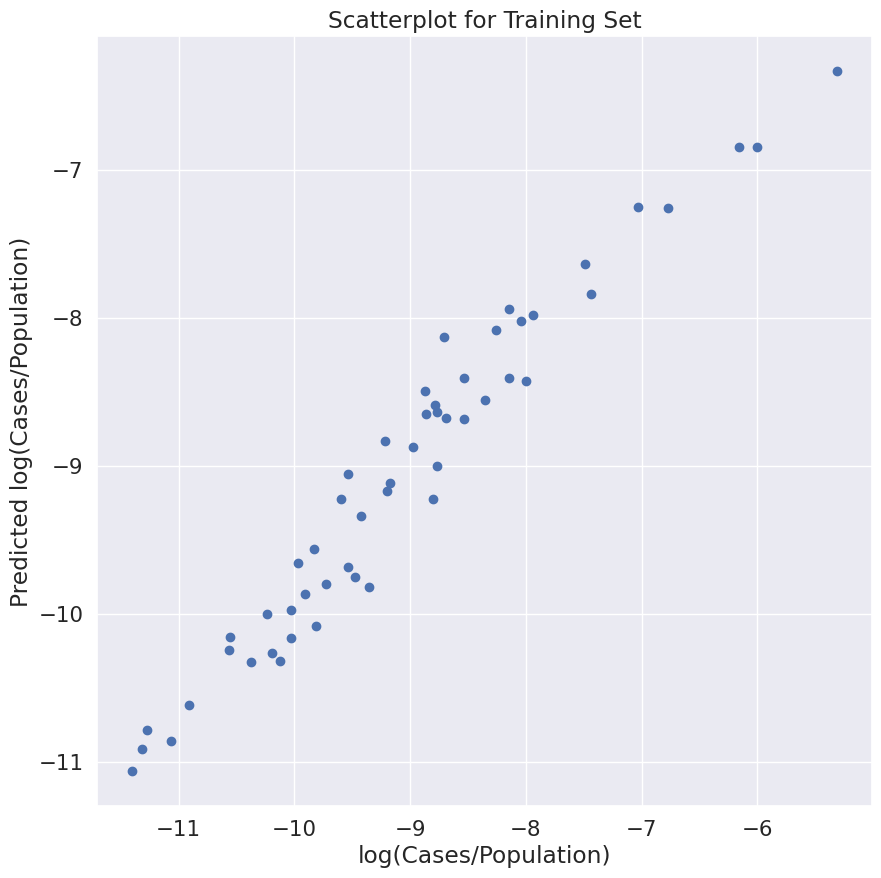

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    0.92150
                       R2:    0.62764


<Figure size 640x480 with 0 Axes>

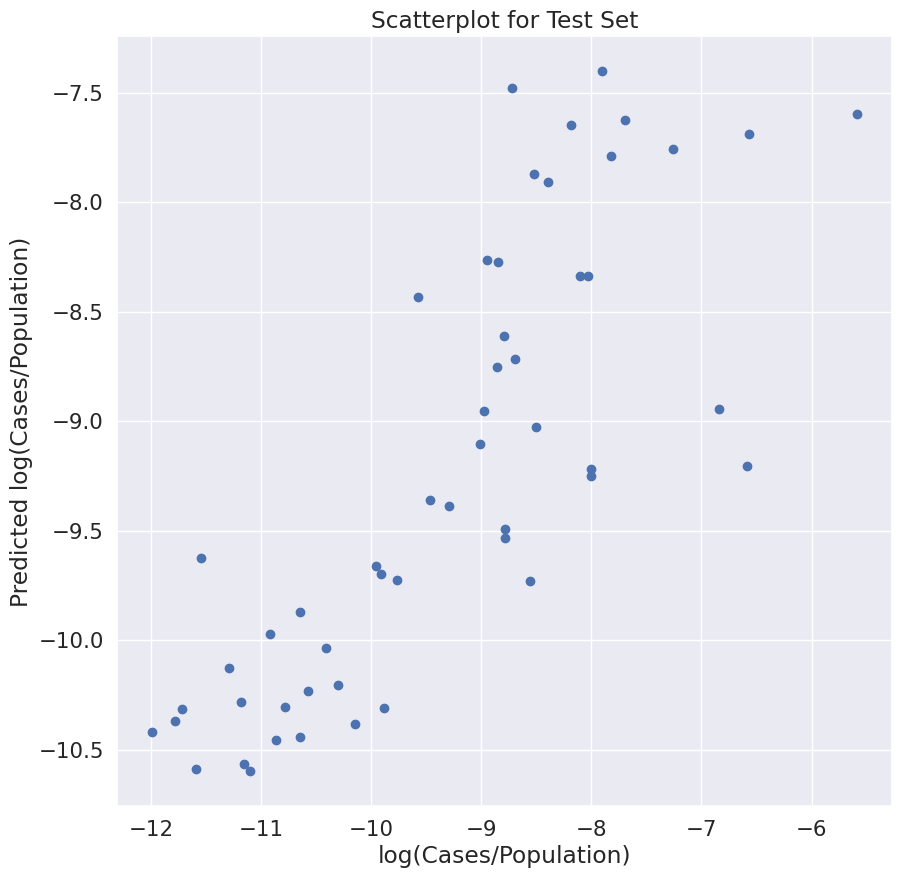

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00707 +/- 0.00895
Feature:                   Com. Density, Score: 0.15236 +/- 0.05394
Feature:                  Depriv. Index, Score: 0.08094 +/- 0.03221
Feature:                       Latitude, Score: 0.52881 +/- 0.13710
Feature:                Old Young Ratio, Score: 0.01536 +/- 0.02618
Feature:                      Avg. PM10, Score: 0.10005 +/- 0.03255
Feature:                        Avg. NO, Score: 0.14940 +/- 0.06209
Feature:                       Avg. SO2, Score: 0.00226 +/- 0.01037


<Figure size 640x480 with 0 Axes>

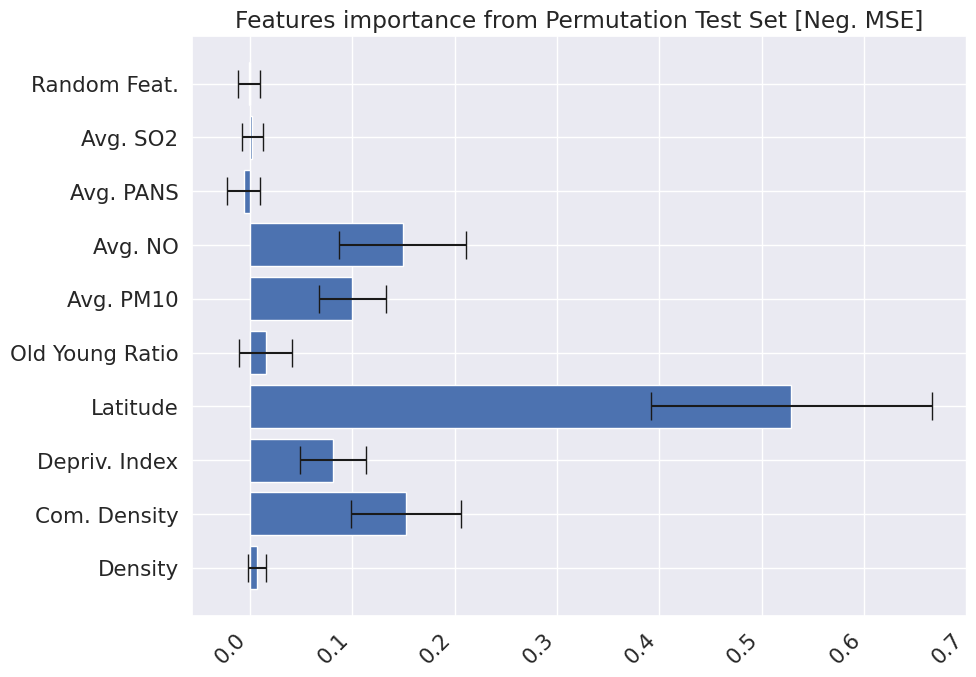

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00310 +/- 0.00392
Feature:                   Com. Density, Score: 0.06681 +/- 0.02365
Feature:                  Depriv. Index, Score: 0.03549 +/- 0.01412
Feature:                       Latitude, Score: 0.23188 +/- 0.06012
Feature:                Old Young Ratio, Score: 0.00674 +/- 0.01148
Feature:                      Avg. PM10, Score: 0.04387 +/- 0.01427
Feature:                        Avg. NO, Score: 0.06551 +/- 0.02723
Feature:                       Avg. SO2, Score: 0.00099 +/- 0.00455


<Figure size 640x480 with 0 Axes>

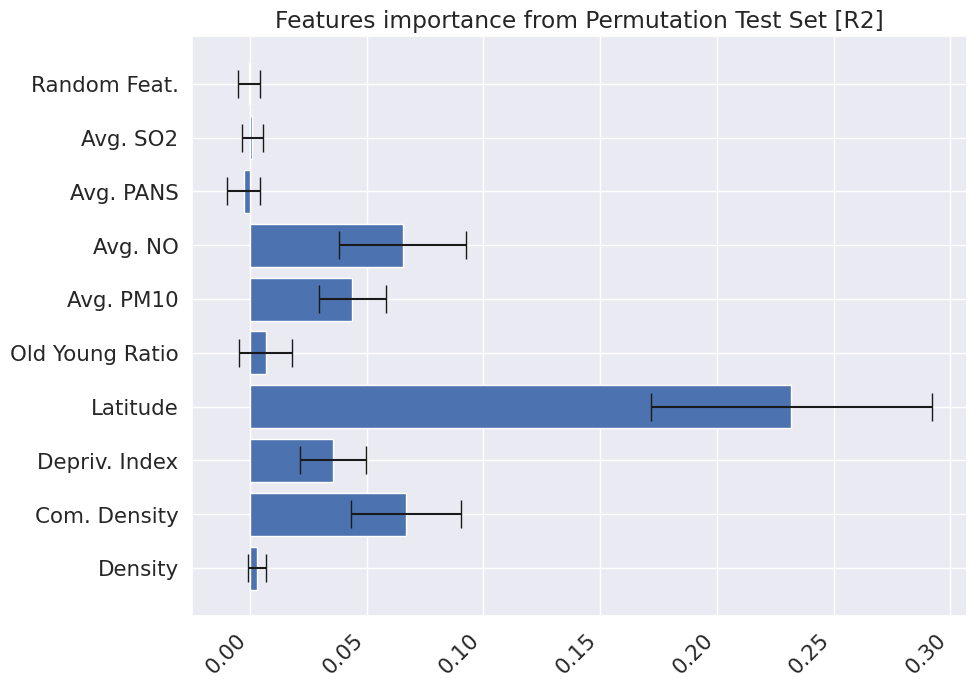

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.14879 +/- 0.03451
Feature:                  Depriv. Index, Score: 0.09848 +/- 0.02015
Feature:                       Latitude, Score: 0.50143 +/- 0.10103
Feature:                Old Young Ratio, Score: 0.08617 +/- 0.02070
Feature:                      Avg. PM10, Score: 0.11330 +/- 0.02124
Feature:                        Avg. NO, Score: 0.26222 +/- 0.04831
Feature:                      Avg. PANS, Score: 0.07375 +/- 0.01572


<Figure size 640x480 with 0 Axes>

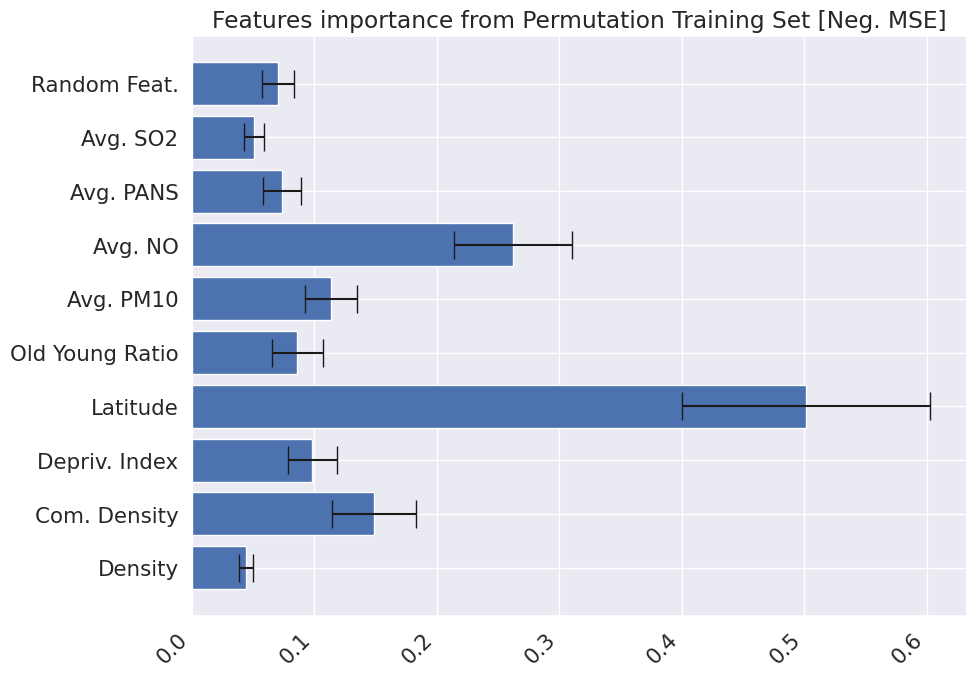

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.08322 +/- 0.01930
Feature:                  Depriv. Index, Score: 0.05508 +/- 0.01127
Feature:                       Latitude, Score: 0.28046 +/- 0.05650
Feature:                Old Young Ratio, Score: 0.04819 +/- 0.01158
Feature:                      Avg. PM10, Score: 0.06337 +/- 0.01188
Feature:                        Avg. NO, Score: 0.14666 +/- 0.02702
Feature:                      Avg. PANS, Score: 0.04125 +/- 0.00879


<Figure size 640x480 with 0 Axes>

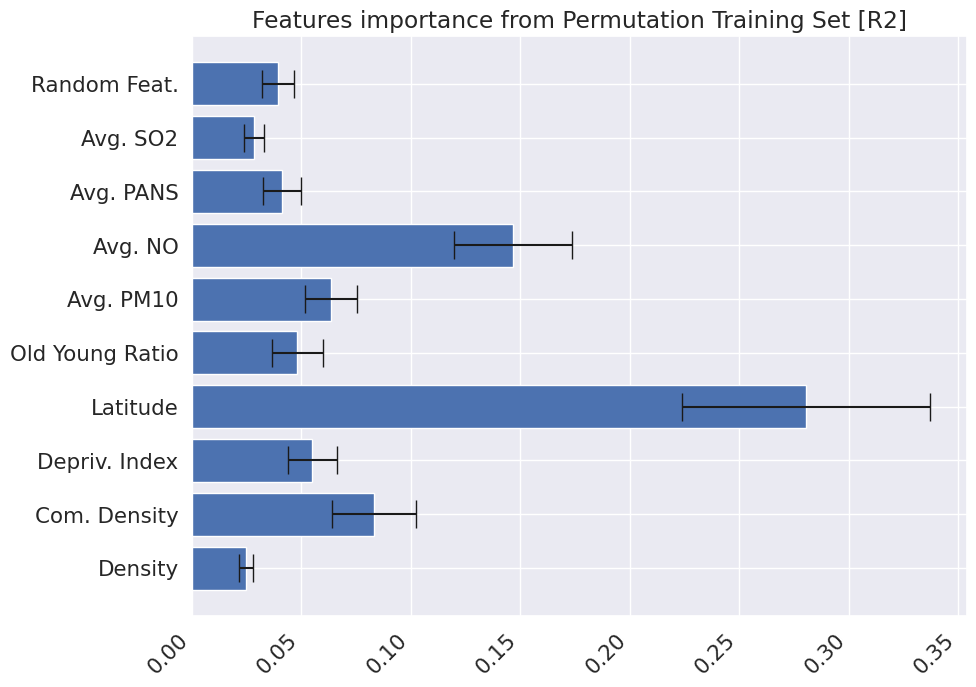

<Figure size 1000x1000 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36330  0.03018 
    Test set average RMSE:  0.98493  0.08346 

Prediction STD :    1.22383
True value STD :    1.43281
Difference in percentage:   14.58535

             Fullset RMSE:    0.34178
                       R2:    0.94310


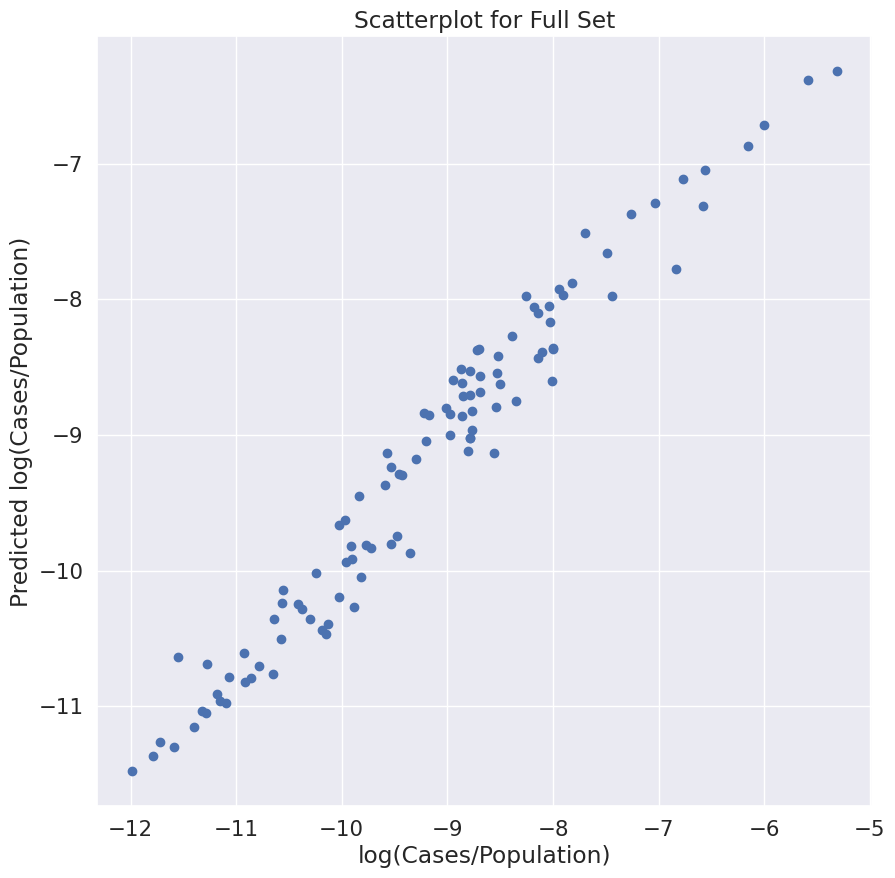

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.65568 +/- 0.09420
Feature:                  Depriv. Index, Score: 0.23741 +/- 0.03178
Feature:                Old Young Ratio, Score: 0.12721 +/- 0.01311
Feature:                      Avg. PM10, Score: 0.30355 +/- 0.03870
Feature:                        Avg. NO, Score: 0.29848 +/- 0.03478
Feature:                      Avg. PANS, Score: 0.08352 +/- 0.00952
Feature:                       Avg. SO2, Score: 0.12529 +/- 0.01771


<Figure size 640x480 with 0 Axes>

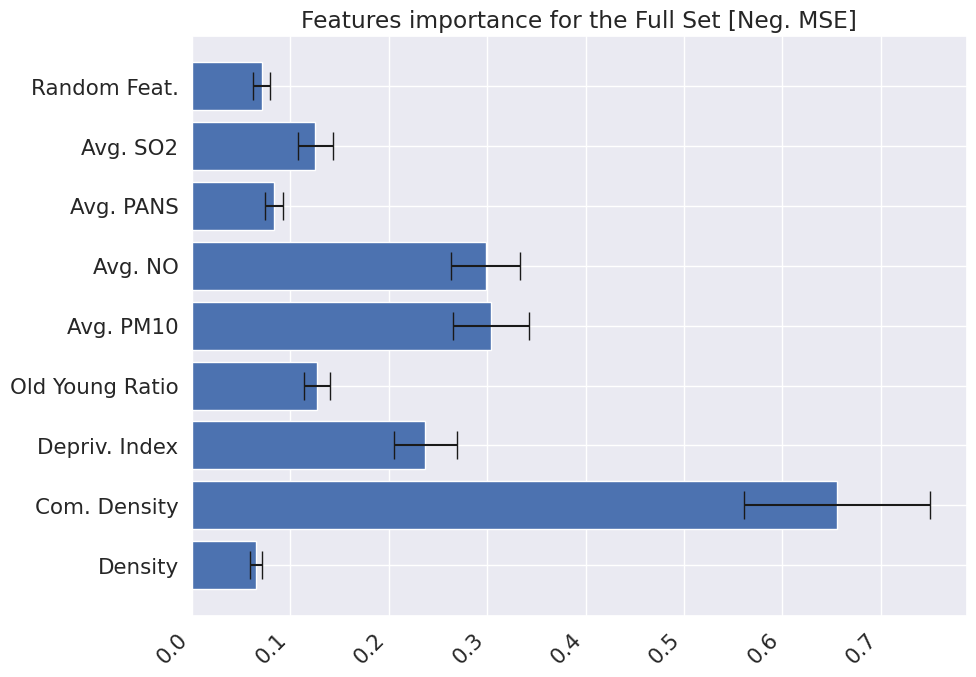

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.31939 +/- 0.04588
Feature:                  Depriv. Index, Score: 0.11564 +/- 0.01548
Feature:                Old Young Ratio, Score: 0.06196 +/- 0.00639
Feature:                      Avg. PM10, Score: 0.14786 +/- 0.01885
Feature:                        Avg. NO, Score: 0.14539 +/- 0.01694
Feature:                      Avg. PANS, Score: 0.04068 +/- 0.00464
Feature:                       Avg. SO2, Score: 0.06103 +/- 0.00863


<Figure size 640x480 with 0 Axes>

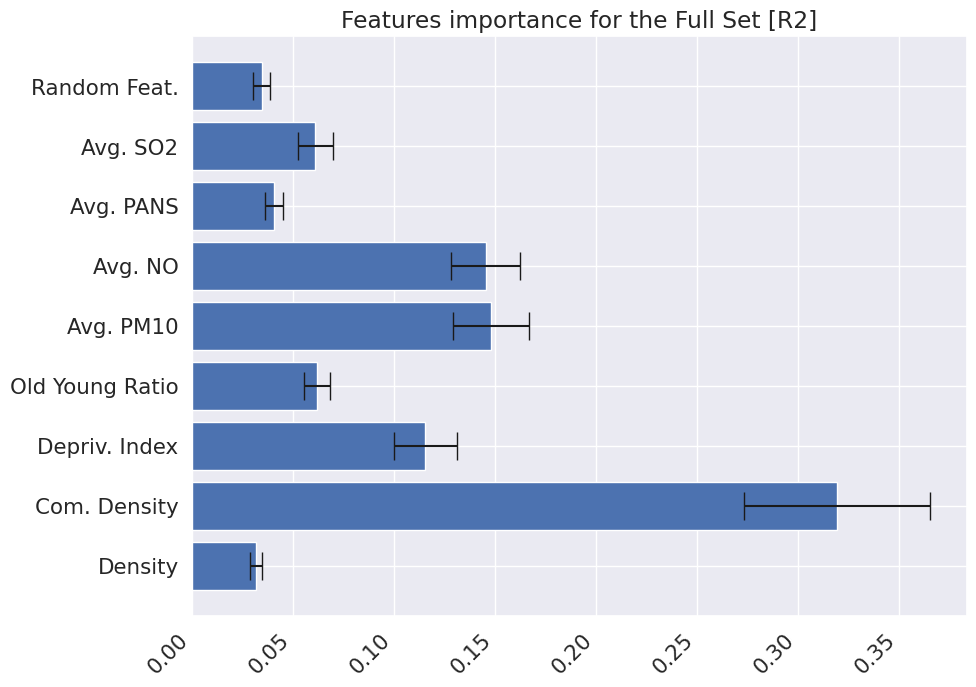

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.37814
                       R2:    0.92218


<Figure size 640x480 with 0 Axes>

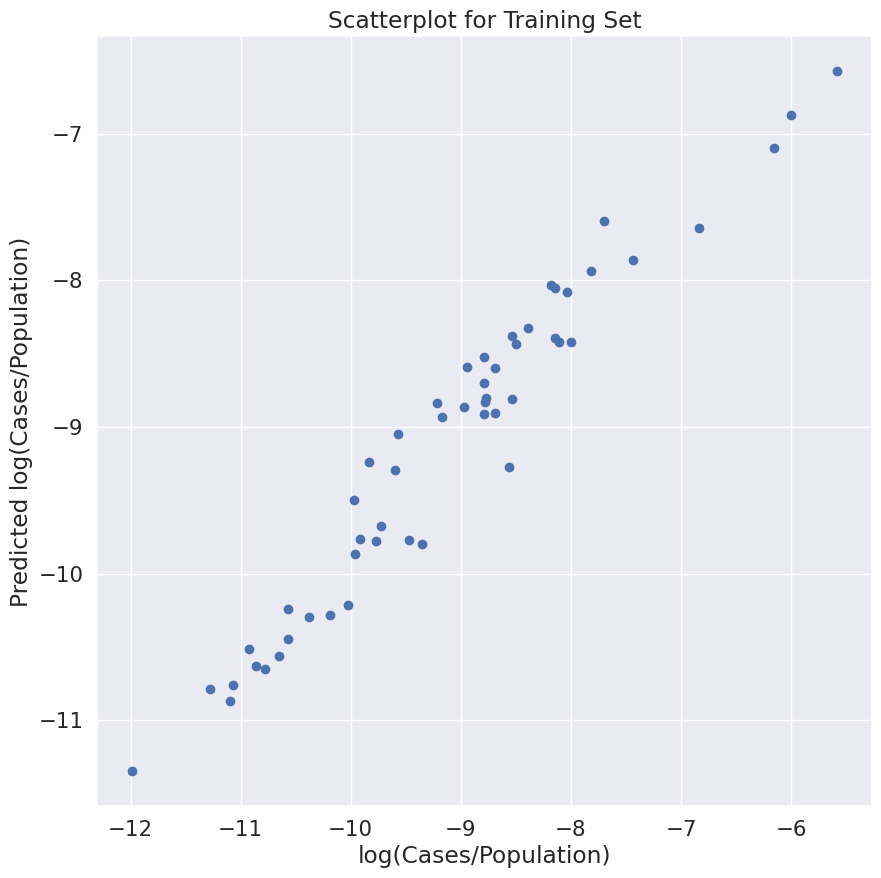

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    0.90780
                       R2:    0.63428


<Figure size 640x480 with 0 Axes>

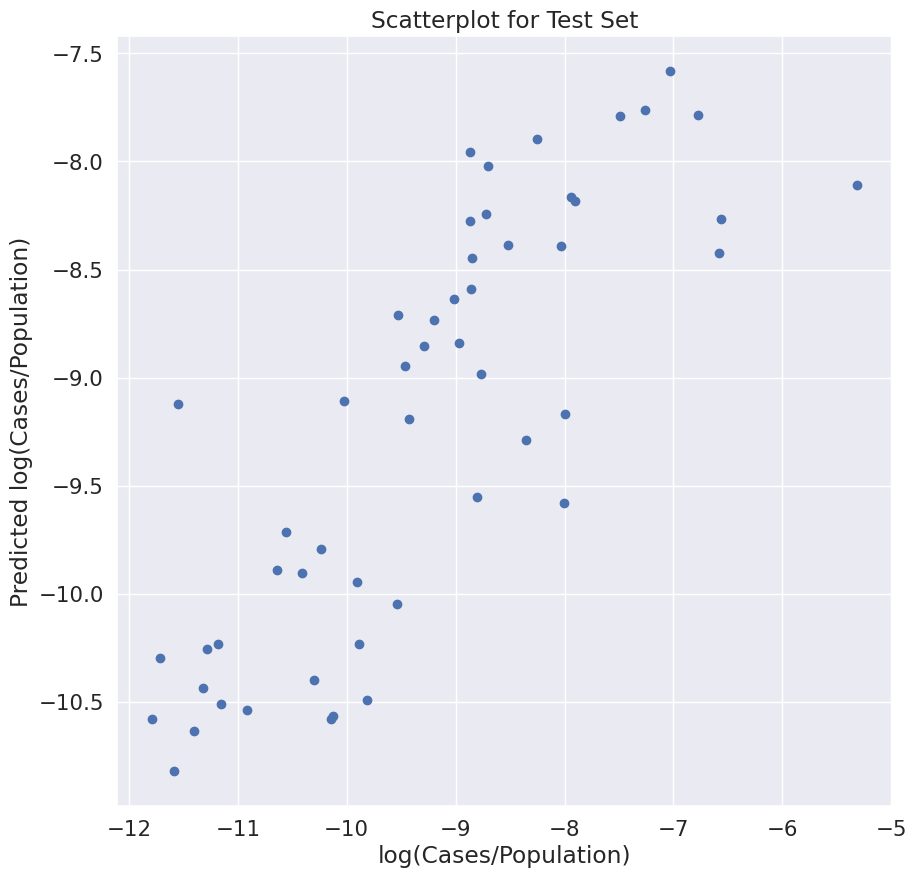

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.66263 +/- 0.15152
Feature:                  Depriv. Index, Score: 0.18554 +/- 0.06366
Feature:                Old Young Ratio, Score: 0.05444 +/- 0.02042
Feature:                      Avg. PM10, Score: 0.14491 +/- 0.04135
Feature:                        Avg. NO, Score: 0.23948 +/- 0.06599
Feature:                      Avg. PANS, Score: 0.02519 +/- 0.01775
Feature:                       Avg. SO2, Score: 0.04327 +/- 0.02274


<Figure size 640x480 with 0 Axes>

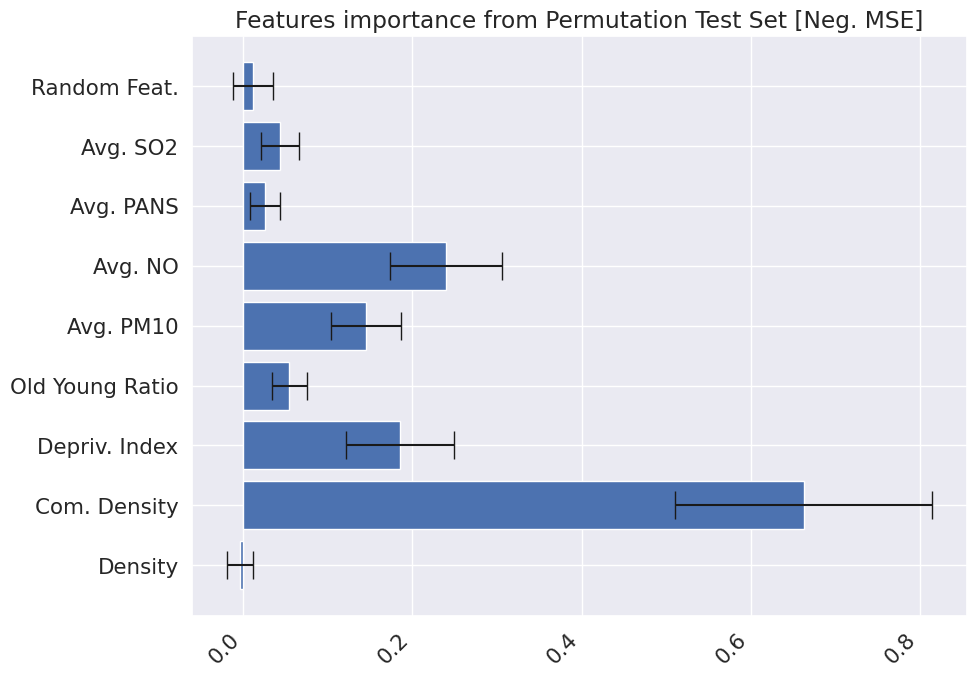

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.29406 +/- 0.06724
Feature:                  Depriv. Index, Score: 0.08234 +/- 0.02825
Feature:                Old Young Ratio, Score: 0.02416 +/- 0.00906
Feature:                      Avg. PM10, Score: 0.06431 +/- 0.01835
Feature:                        Avg. NO, Score: 0.10628 +/- 0.02929
Feature:                      Avg. PANS, Score: 0.01118 +/- 0.00788
Feature:                       Avg. SO2, Score: 0.01920 +/- 0.01009


<Figure size 640x480 with 0 Axes>

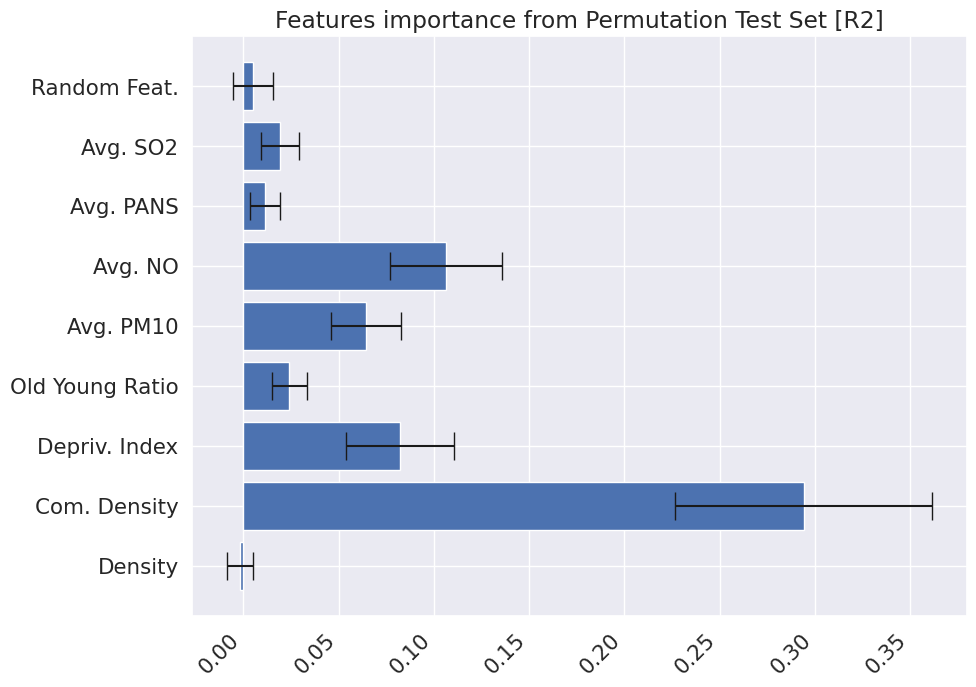

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.61156 +/- 0.11878
Feature:                  Depriv. Index, Score: 0.21563 +/- 0.04037
Feature:                      Avg. PM10, Score: 0.18745 +/- 0.03194
Feature:                        Avg. NO, Score: 0.22823 +/- 0.04563


<Figure size 640x480 with 0 Axes>

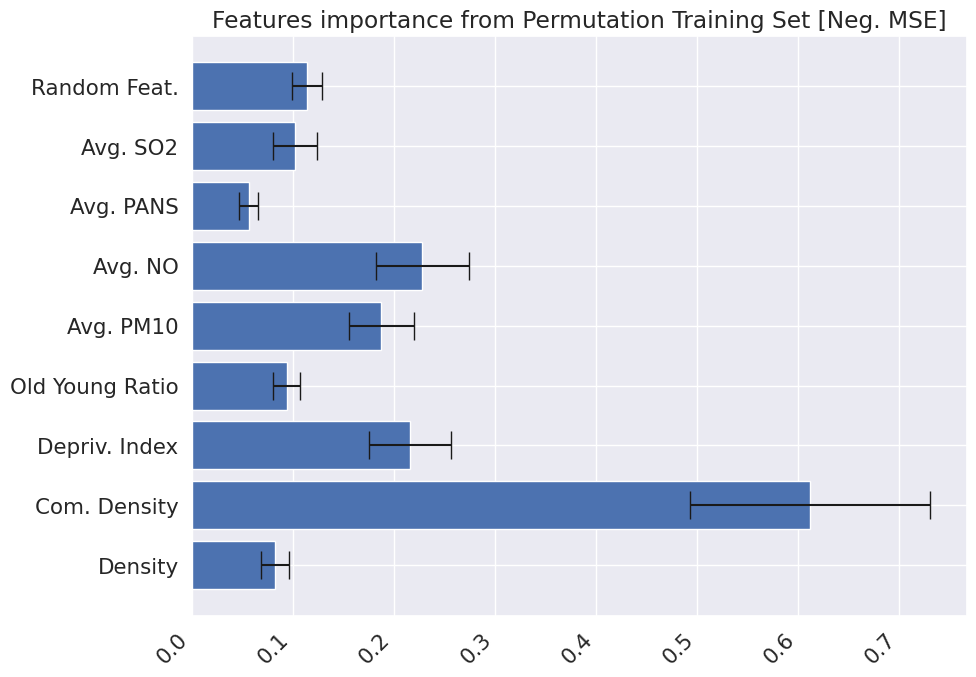

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.33283 +/- 0.06465
Feature:                  Depriv. Index, Score: 0.11736 +/- 0.02197
Feature:                      Avg. PM10, Score: 0.10202 +/- 0.01738
Feature:                        Avg. NO, Score: 0.12421 +/- 0.02484


<Figure size 640x480 with 0 Axes>

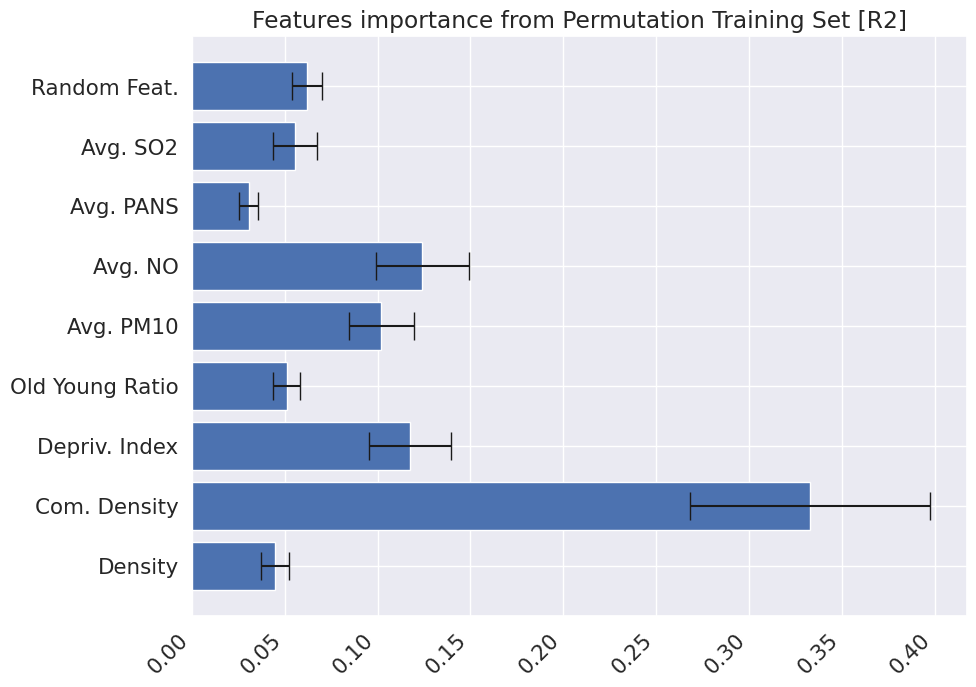

<Figure size 1000x1000 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37395  0.03015 
    Test set average RMSE:  1.06755  0.08852 

Prediction STD :    1.18183
True value STD :    1.43281
Difference in percentage:   17.51625

             Fullset RMSE:    0.36385
                       R2:    0.93551


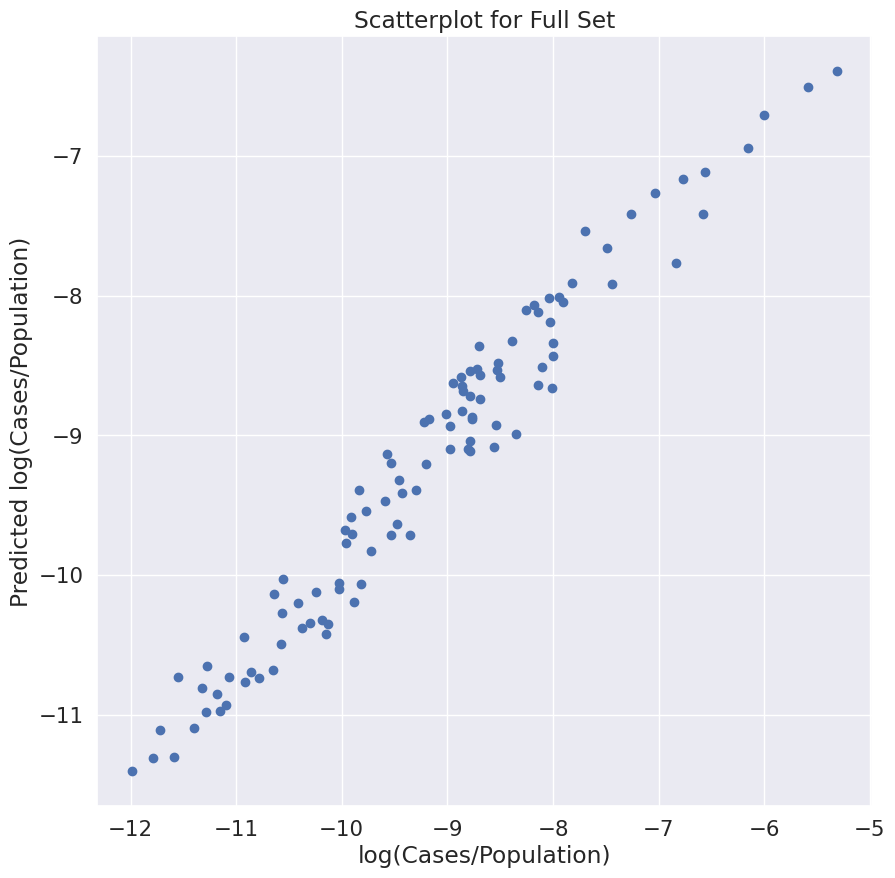

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12073 +/- 0.01435
Feature:                  Depriv. Index, Score: 0.48086 +/- 0.06454
Feature:                Old Young Ratio, Score: 0.15959 +/- 0.01795
Feature:                      Avg. PM10, Score: 0.44492 +/- 0.05634
Feature:                        Avg. NO, Score: 0.48039 +/- 0.06517
Feature:                      Avg. PANS, Score: 0.11962 +/- 0.01228
Feature:                       Avg. SO2, Score: 0.16392 +/- 0.02129


<Figure size 640x480 with 0 Axes>

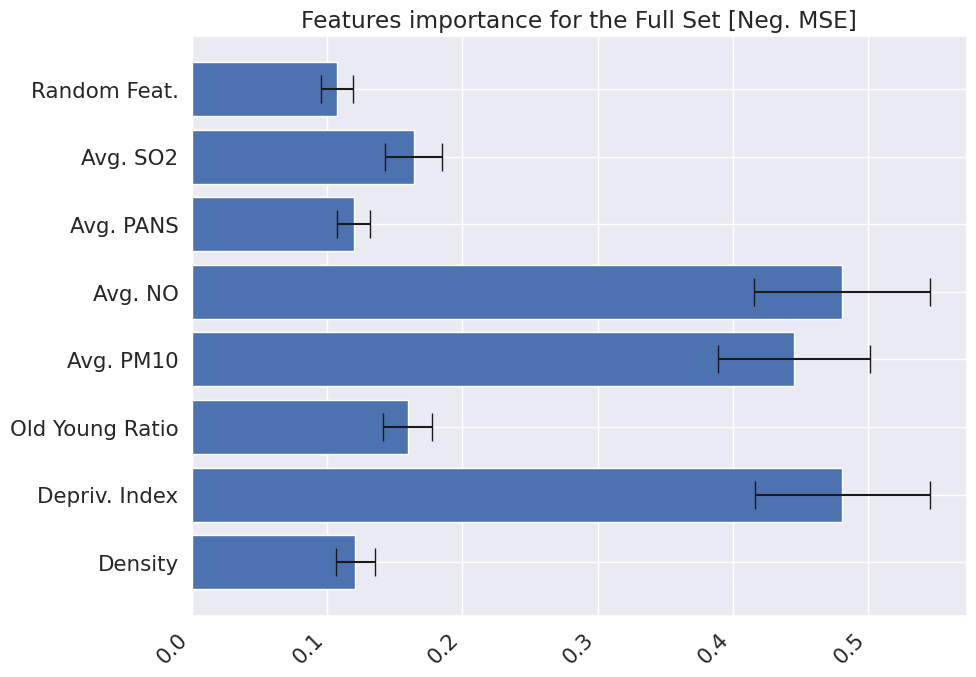

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.05881 +/- 0.00699
Feature:                  Depriv. Index, Score: 0.23423 +/- 0.03144
Feature:                Old Young Ratio, Score: 0.07774 +/- 0.00875
Feature:                      Avg. PM10, Score: 0.21672 +/- 0.02744
Feature:                        Avg. NO, Score: 0.23400 +/- 0.03175
Feature:                      Avg. PANS, Score: 0.05827 +/- 0.00598
Feature:                       Avg. SO2, Score: 0.07985 +/- 0.01037


<Figure size 640x480 with 0 Axes>

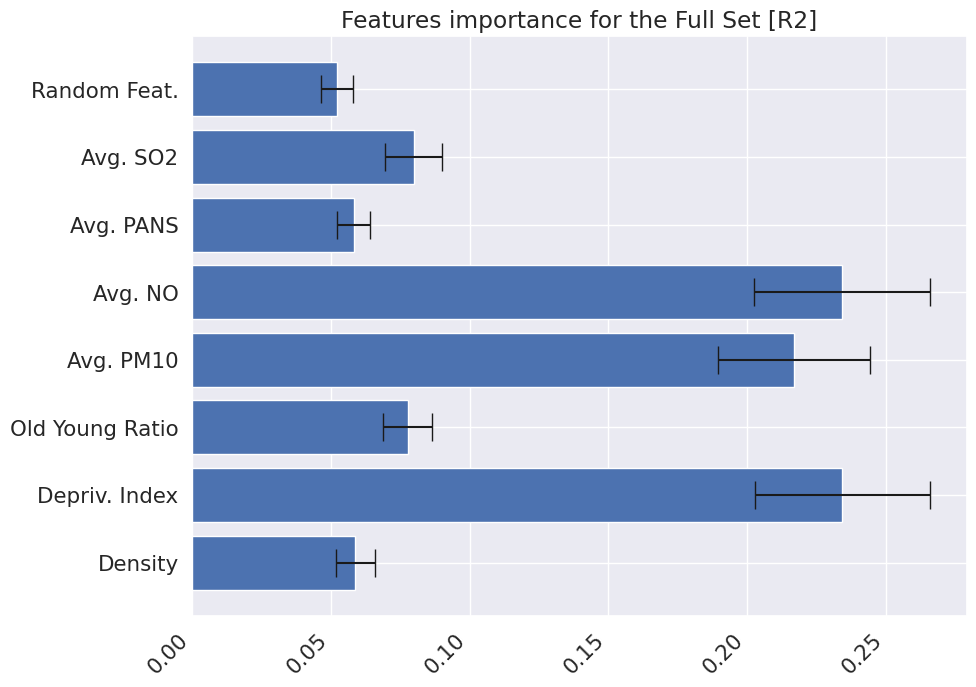

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.38236
                       R2:    0.91334


<Figure size 640x480 with 0 Axes>

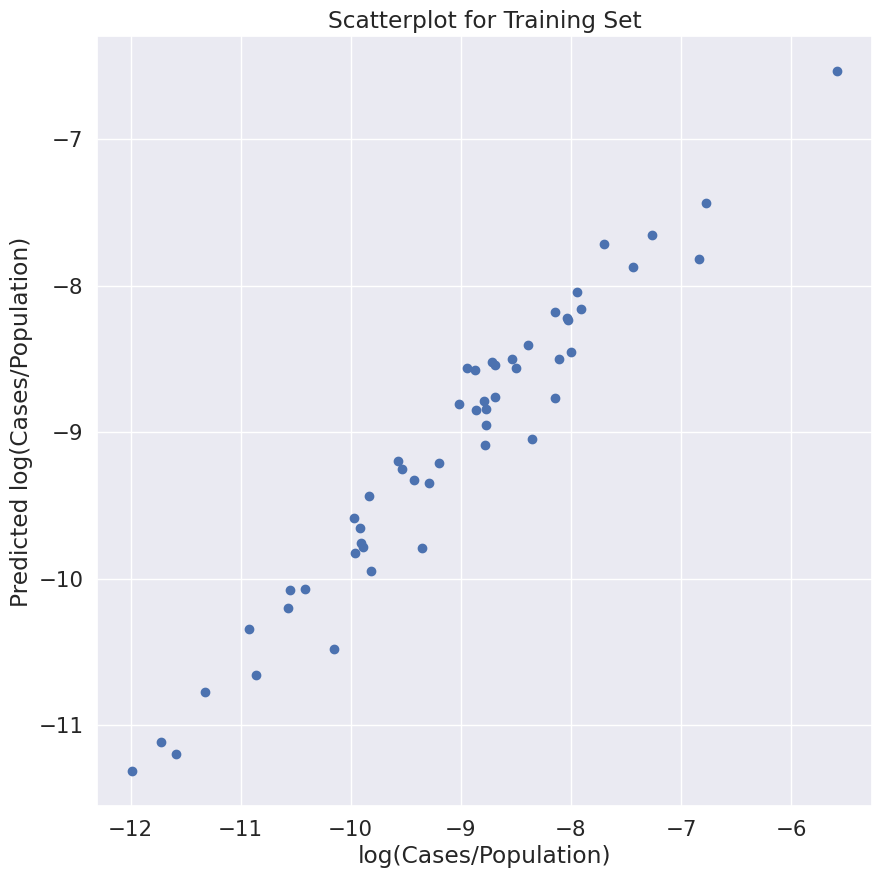

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    1.07650
                       R2:    0.51555


<Figure size 640x480 with 0 Axes>

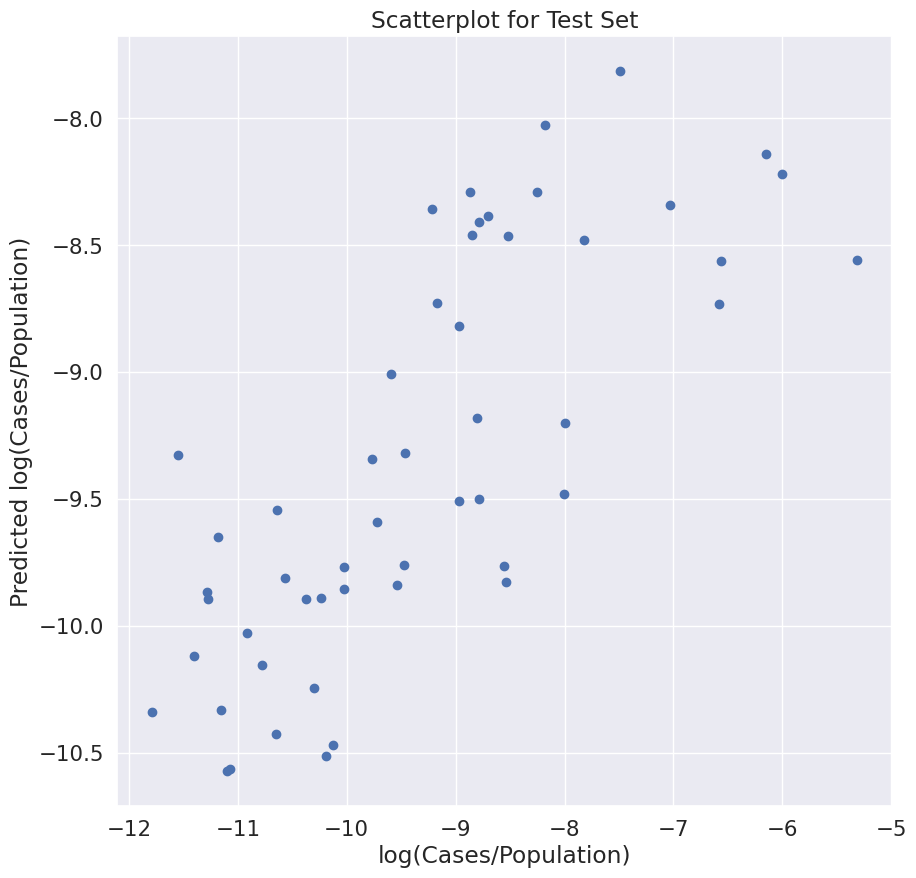

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.04584 +/- 0.02696
Feature:                  Depriv. Index, Score: 0.39456 +/- 0.10802
Feature:                Old Young Ratio, Score: 0.02729 +/- 0.02110
Feature:                      Avg. PM10, Score: 0.24770 +/- 0.05749
Feature:                        Avg. NO, Score: 0.51565 +/- 0.11466
Feature:                      Avg. PANS, Score: 0.04646 +/- 0.02687
Feature:                       Avg. SO2, Score: 0.06504 +/- 0.01792


<Figure size 640x480 with 0 Axes>

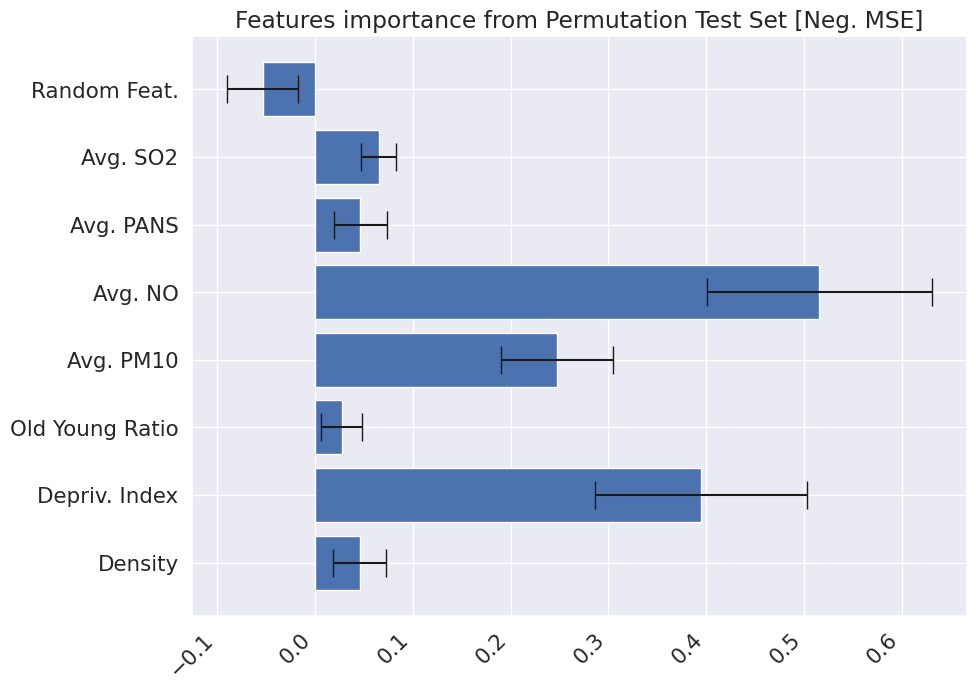

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.01916 +/- 0.01127
Feature:                  Depriv. Index, Score: 0.16494 +/- 0.04516
Feature:                Old Young Ratio, Score: 0.01141 +/- 0.00882
Feature:                      Avg. PM10, Score: 0.10355 +/- 0.02403
Feature:                        Avg. NO, Score: 0.21557 +/- 0.04793
Feature:                      Avg. PANS, Score: 0.01942 +/- 0.01123
Feature:                       Avg. SO2, Score: 0.02719 +/- 0.00749


<Figure size 640x480 with 0 Axes>

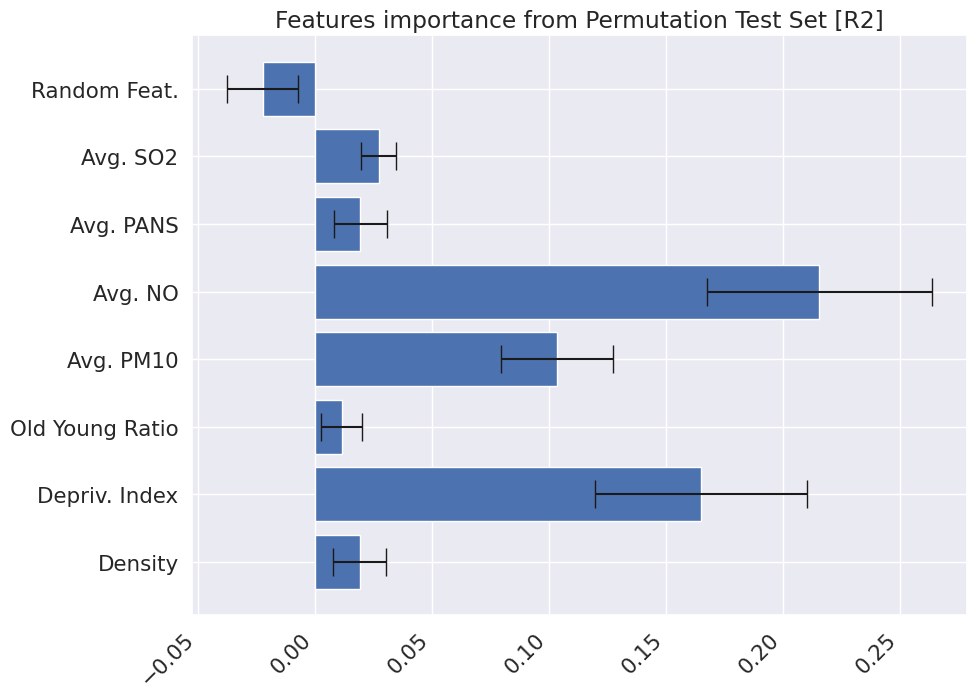

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.14085 +/- 0.02526
Feature:                  Depriv. Index, Score: 0.41371 +/- 0.07530
Feature:                      Avg. PM10, Score: 0.22576 +/- 0.04517
Feature:                        Avg. NO, Score: 0.38621 +/- 0.08426


<Figure size 640x480 with 0 Axes>

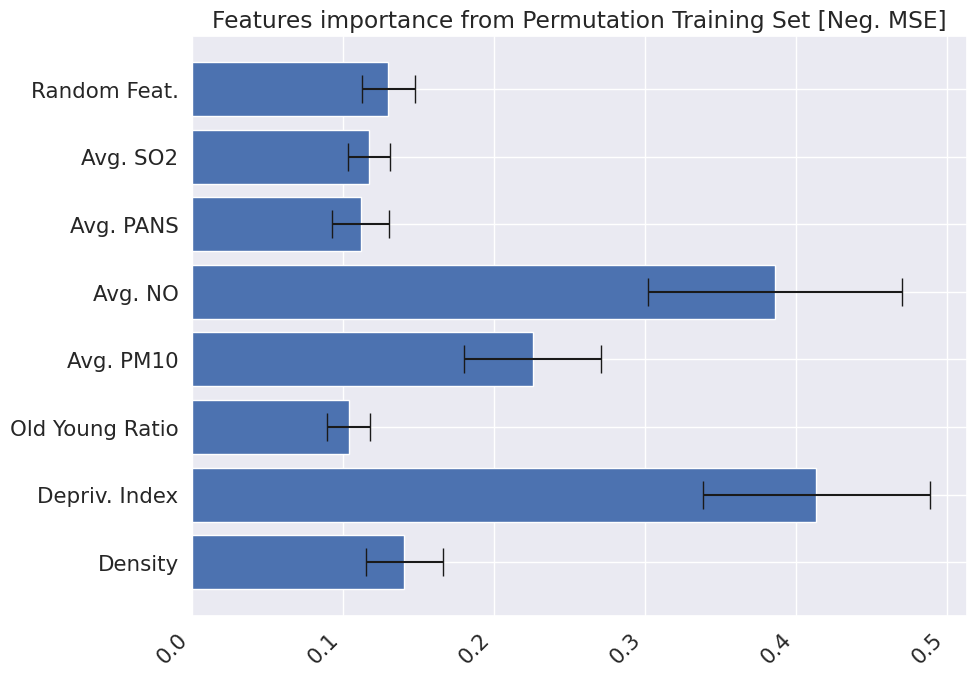

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.08349 +/- 0.01497
Feature:                  Depriv. Index, Score: 0.24523 +/- 0.04463
Feature:                      Avg. PM10, Score: 0.13382 +/- 0.02678
Feature:                        Avg. NO, Score: 0.22893 +/- 0.04995


<Figure size 640x480 with 0 Axes>

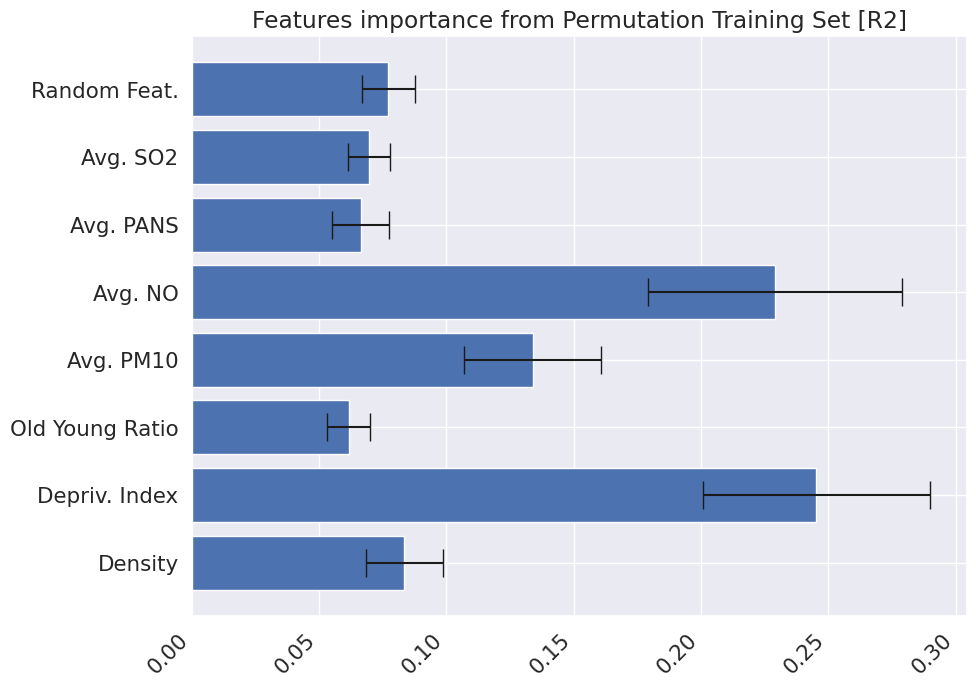

<Figure size 1000x1000 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.34056  0.02847 
    Test set average RMSE:  0.92005  0.06252 

Prediction STD :    1.25982
True value STD :    1.43281
Difference in percentage:   12.07340

             Fullset RMSE:    0.32624
                       R2:    0.94816


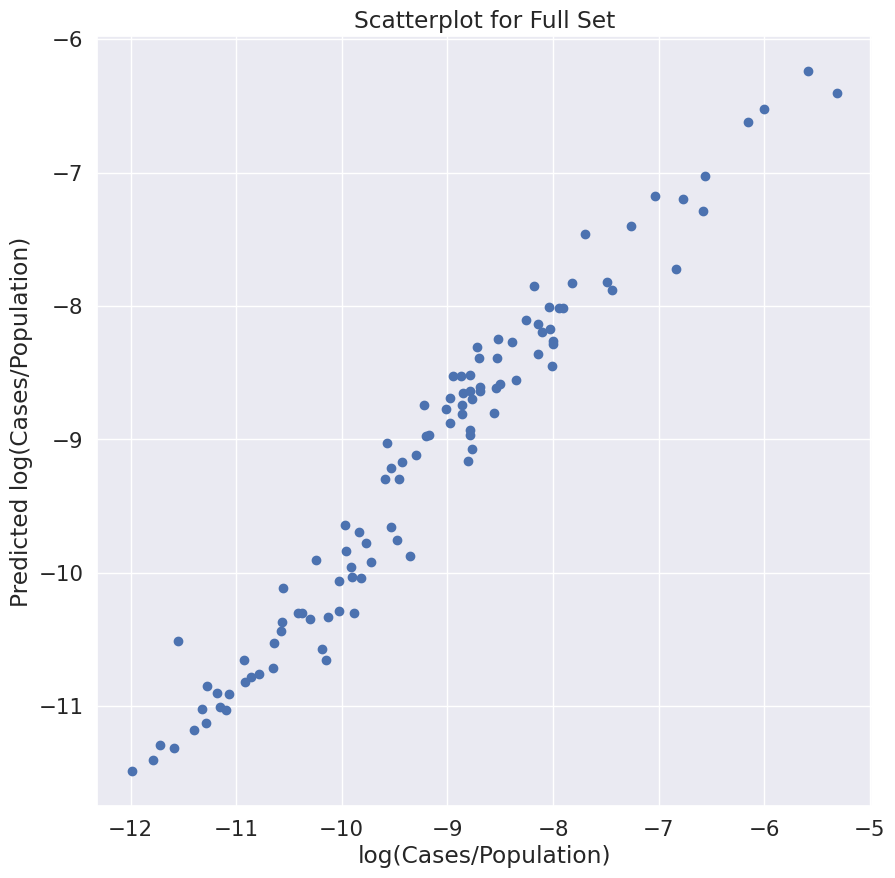

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.28573 +/- 0.04558
Feature:                  Depriv. Index, Score: 0.13348 +/- 0.01736
Feature:                       Latitude, Score: 0.66224 +/- 0.08159
Feature:                Old Young Ratio, Score: 0.11068 +/- 0.01190
Feature:                      Avg. PM10, Score: 0.19449 +/- 0.02304
Feature:                        Avg. NO, Score: 0.17673 +/- 0.02376
Feature:                       Avg. SO2, Score: 0.08488 +/- 0.01091


<Figure size 640x480 with 0 Axes>

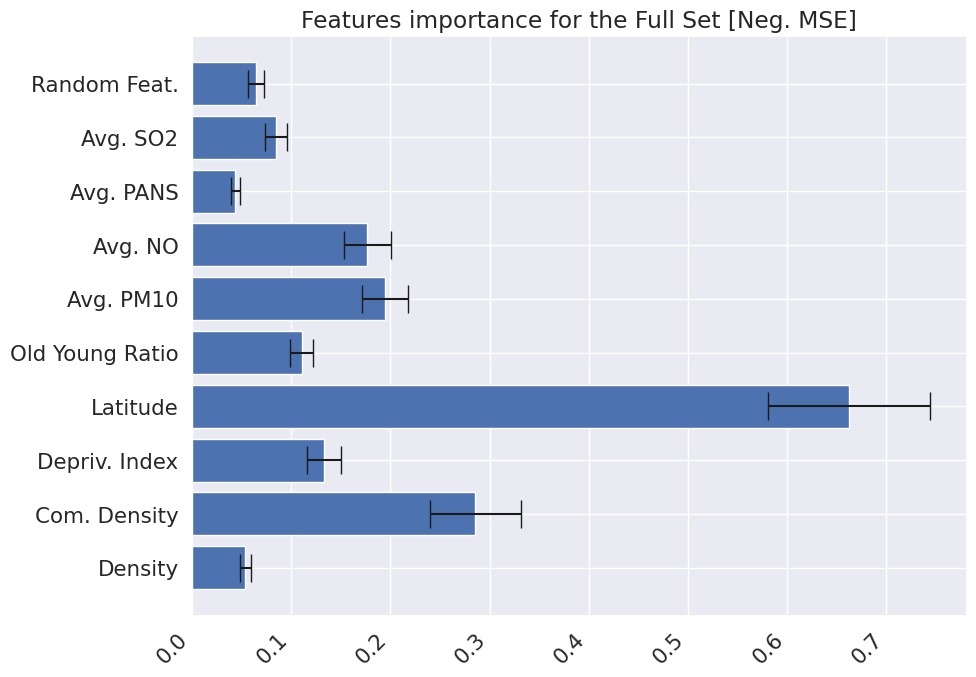

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.13918 +/- 0.02220
Feature:                  Depriv. Index, Score: 0.06502 +/- 0.00845
Feature:                       Latitude, Score: 0.32258 +/- 0.03974
Feature:                Old Young Ratio, Score: 0.05391 +/- 0.00580
Feature:                      Avg. PM10, Score: 0.09474 +/- 0.01122
Feature:                        Avg. NO, Score: 0.08609 +/- 0.01157
Feature:                       Avg. SO2, Score: 0.04135 +/- 0.00532


<Figure size 640x480 with 0 Axes>

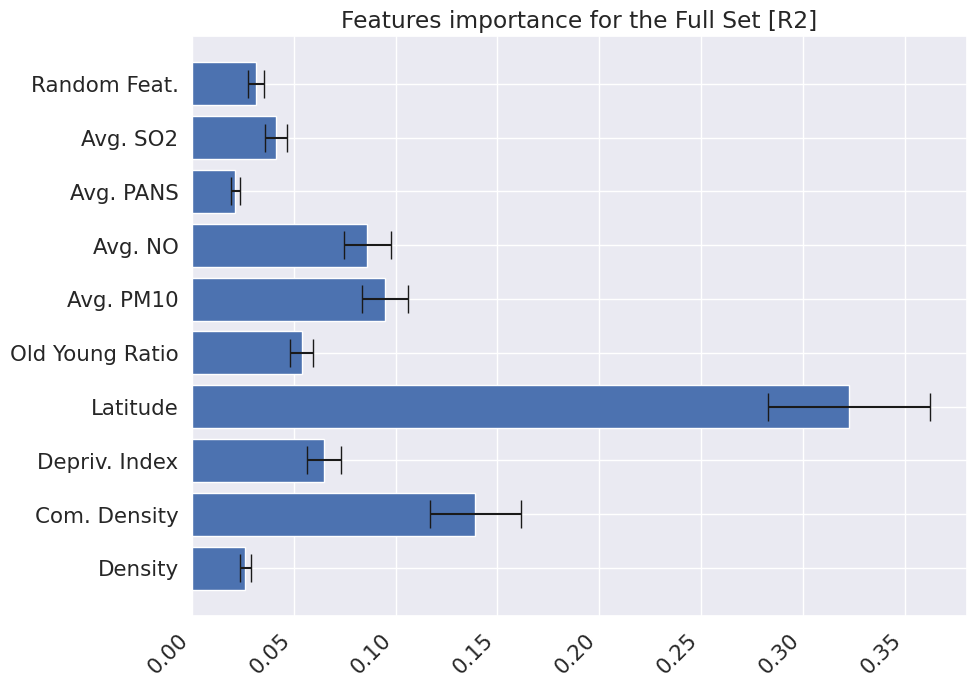

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.35283
                       R2:    0.94746


<Figure size 640x480 with 0 Axes>

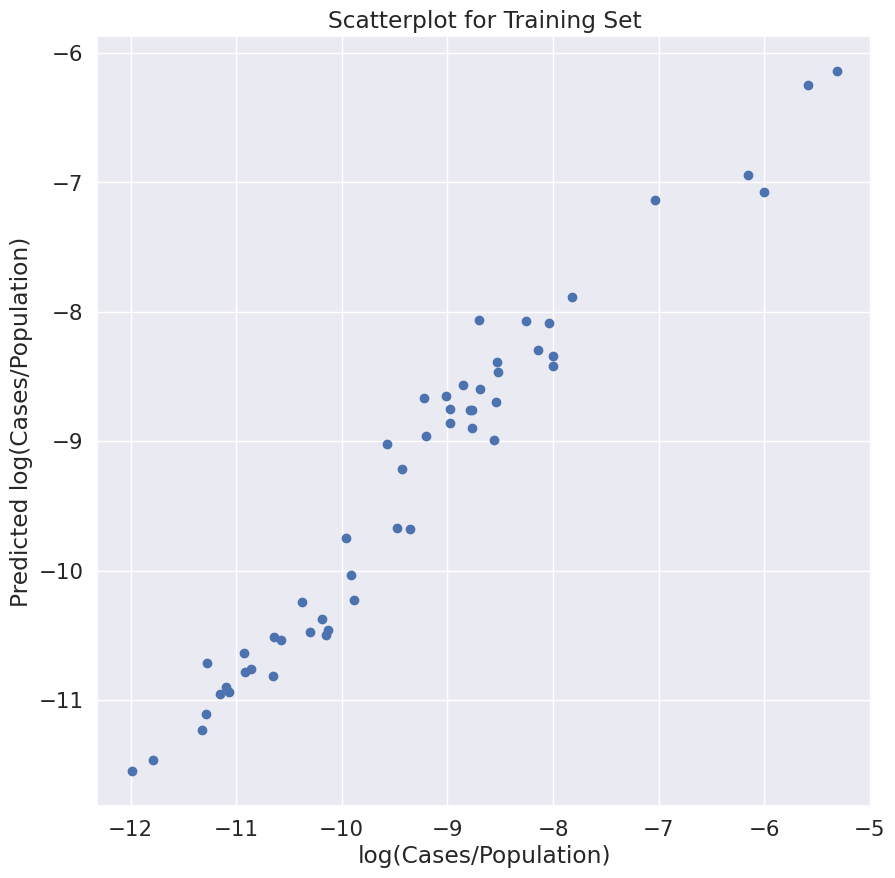

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    0.90402
                       R2:    0.52111


<Figure size 640x480 with 0 Axes>

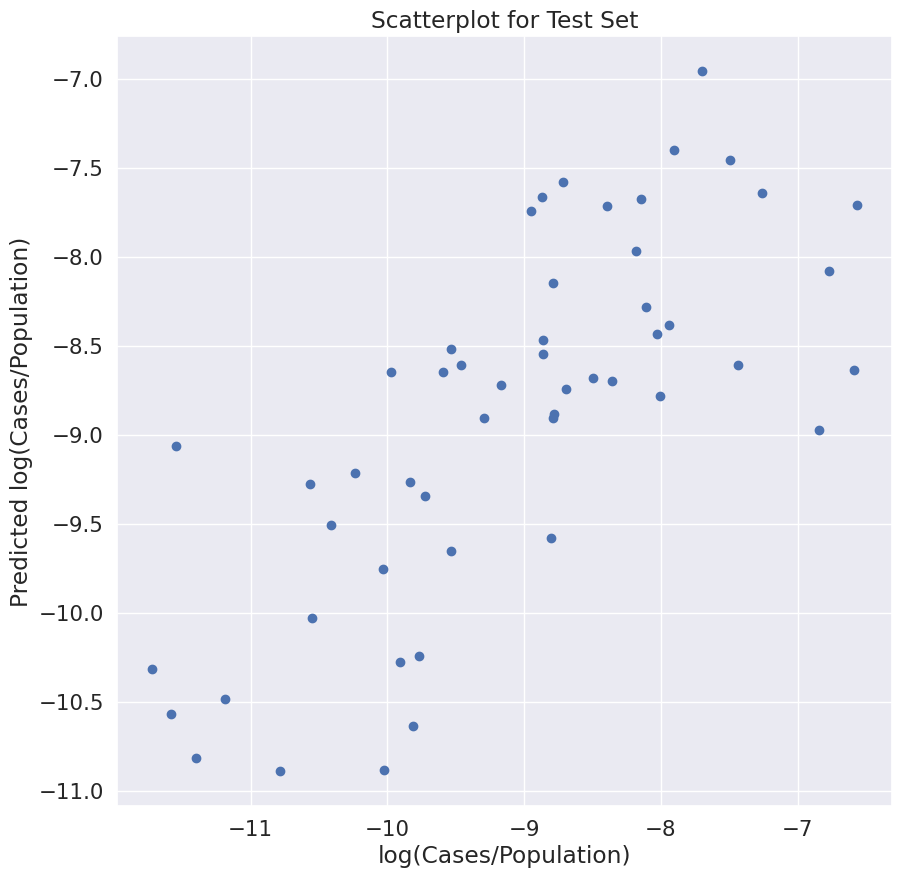

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00439 +/- 0.00647
Feature:                   Com. Density, Score: 0.16900 +/- 0.08153
Feature:                  Depriv. Index, Score: 0.03540 +/- 0.04369
Feature:                       Latitude, Score: 0.29494 +/- 0.09158
Feature:                      Avg. PM10, Score: 0.04668 +/- 0.03778
Feature:                        Avg. NO, Score: 0.05201 +/- 0.06259
Feature:                      Avg. PANS, Score: 0.02130 +/- 0.01549
Feature:                       Avg. SO2, Score: 0.00889 +/- 0.00982


<Figure size 640x480 with 0 Axes>

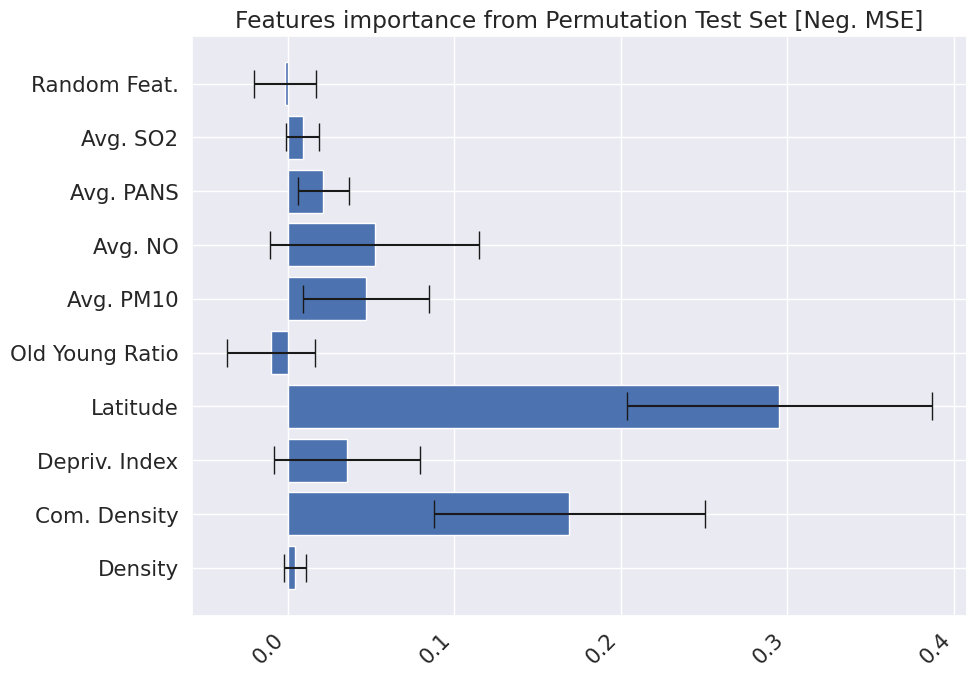

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00257 +/- 0.00379
Feature:                   Com. Density, Score: 0.09903 +/- 0.04778
Feature:                  Depriv. Index, Score: 0.02074 +/- 0.02560
Feature:                       Latitude, Score: 0.17283 +/- 0.05366
Feature:                      Avg. PM10, Score: 0.02735 +/- 0.02214
Feature:                        Avg. NO, Score: 0.03048 +/- 0.03668
Feature:                      Avg. PANS, Score: 0.01248 +/- 0.00908
Feature:                       Avg. SO2, Score: 0.00521 +/- 0.00575


<Figure size 640x480 with 0 Axes>

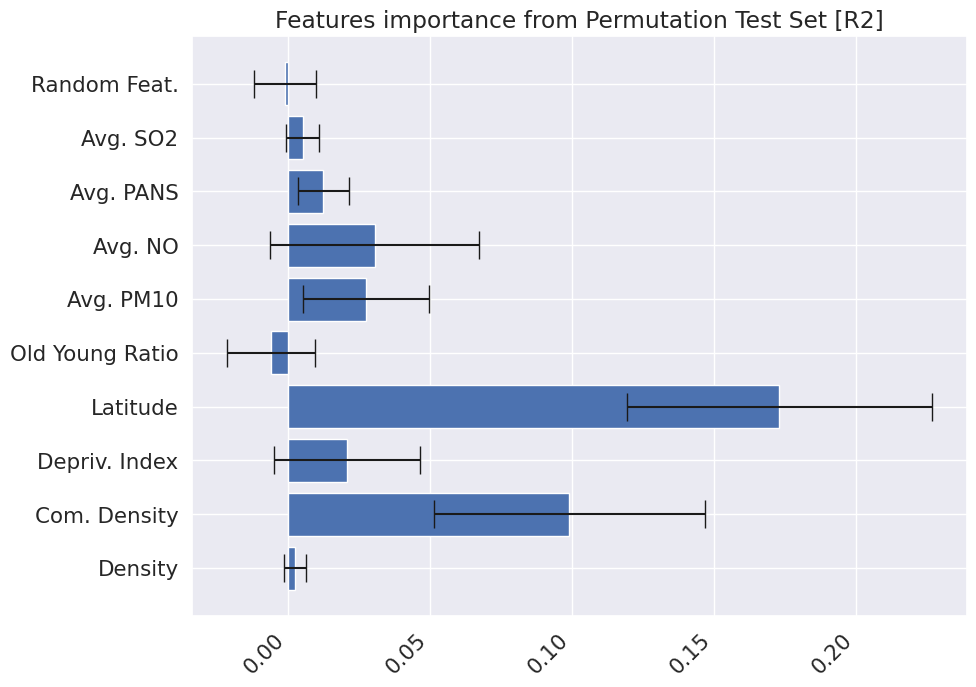

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.41648 +/- 0.07649
Feature:                  Depriv. Index, Score: 0.14204 +/- 0.03038
Feature:                       Latitude, Score: 0.54959 +/- 0.08390
Feature:                Old Young Ratio, Score: 0.08973 +/- 0.01625
Feature:                      Avg. PM10, Score: 0.16042 +/- 0.02618
Feature:                        Avg. NO, Score: 0.19285 +/- 0.04077


<Figure size 640x480 with 0 Axes>

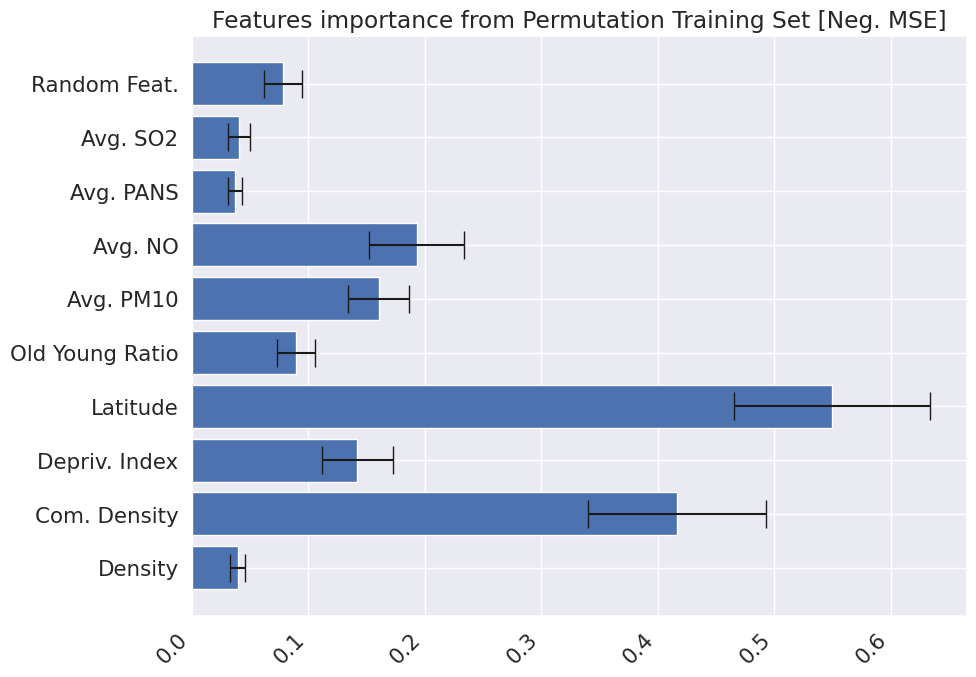

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.17578 +/- 0.03228
Feature:                  Depriv. Index, Score: 0.05995 +/- 0.01282
Feature:                       Latitude, Score: 0.23195 +/- 0.03541
Feature:                Old Young Ratio, Score: 0.03787 +/- 0.00686
Feature:                      Avg. PM10, Score: 0.06771 +/- 0.01105
Feature:                        Avg. NO, Score: 0.08139 +/- 0.01721


<Figure size 640x480 with 0 Axes>

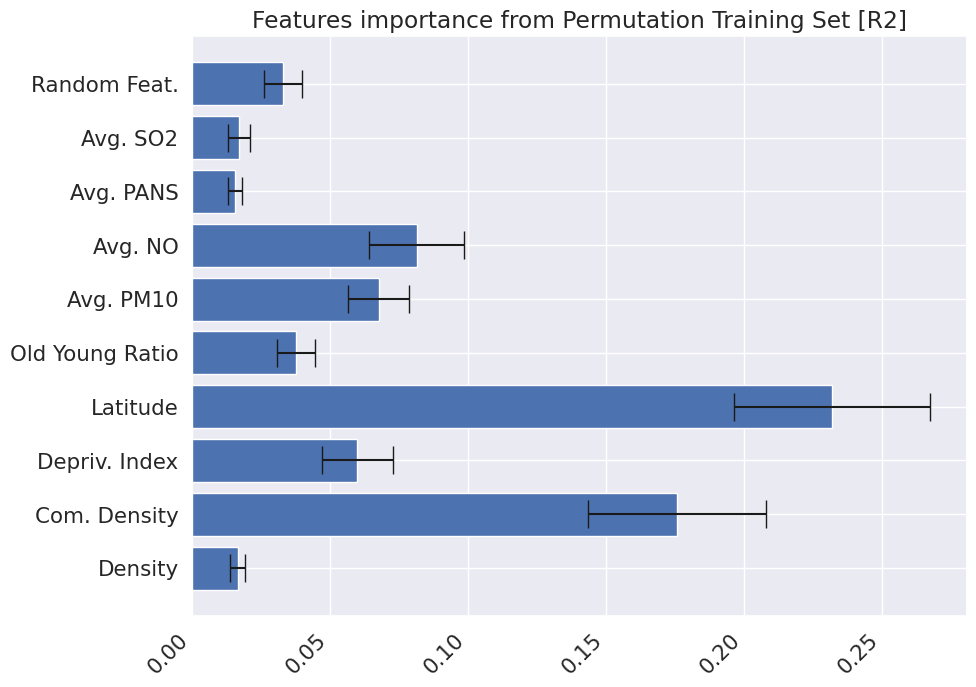

<Figure size 1000x1000 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37110  0.02560 
    Test set average RMSE:  0.98520  0.07172 

Prediction STD :    1.23700
True value STD :    1.43281
Difference in percentage:   13.66626

             Fullset RMSE:    0.34995
                       R2:    0.94035


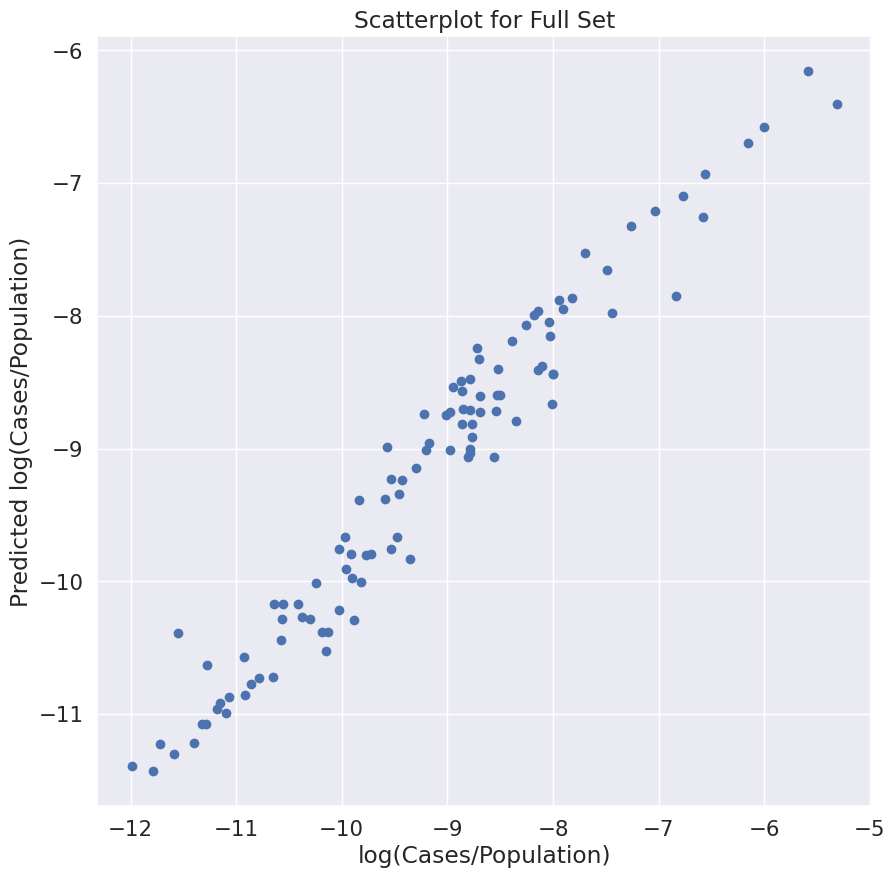

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.63596 +/- 0.09091
Feature:                  Depriv. Index, Score: 0.25236 +/- 0.03307
Feature:                Old Young Ratio, Score: 0.12332 +/- 0.01339
Feature:                      Avg. PM10, Score: 0.27859 +/- 0.03527
Feature:                        Avg. NO, Score: 0.34541 +/- 0.04328
Feature:                       Avg. SO2, Score: 0.11789 +/- 0.01682


<Figure size 640x480 with 0 Axes>

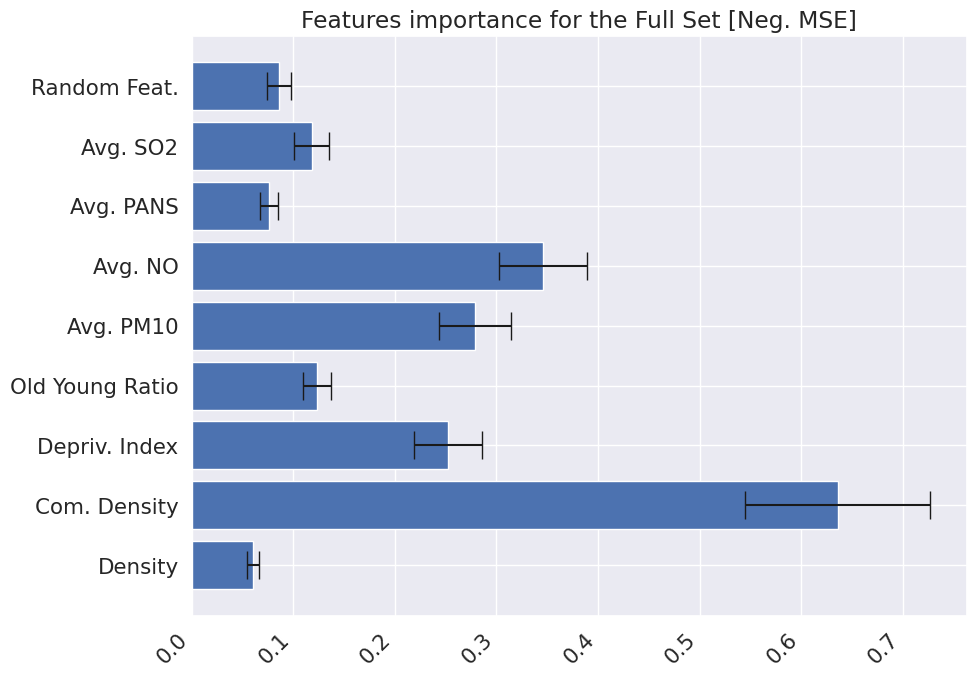

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.30978 +/- 0.04428
Feature:                  Depriv. Index, Score: 0.12293 +/- 0.01611
Feature:                Old Young Ratio, Score: 0.06007 +/- 0.00652
Feature:                      Avg. PM10, Score: 0.13571 +/- 0.01718
Feature:                        Avg. NO, Score: 0.16825 +/- 0.02108
Feature:                       Avg. SO2, Score: 0.05743 +/- 0.00820


<Figure size 640x480 with 0 Axes>

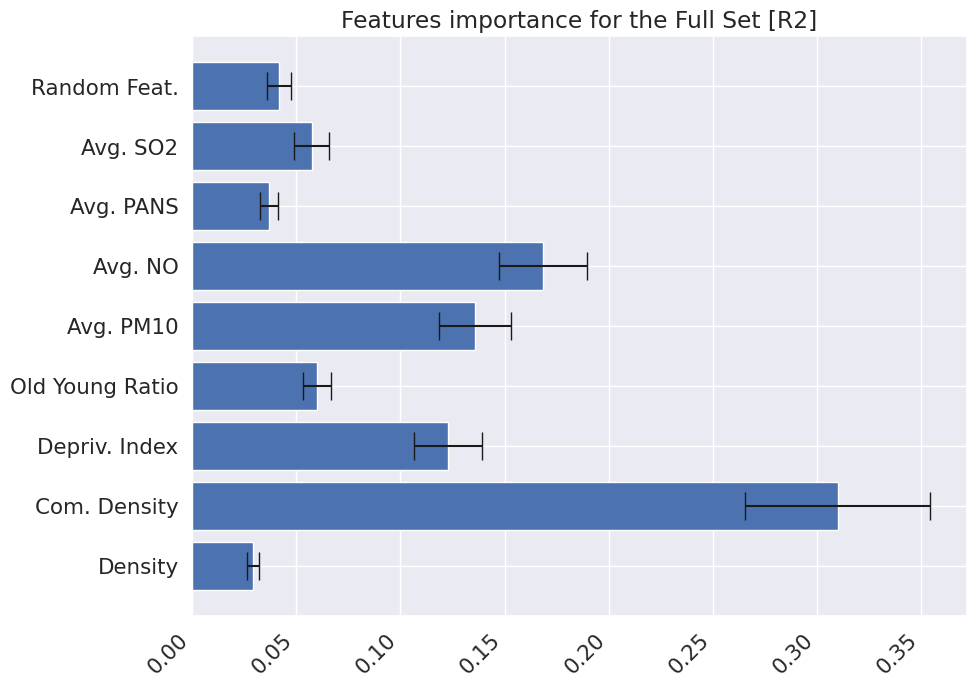

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.36091
                       R2:    0.92163


<Figure size 640x480 with 0 Axes>

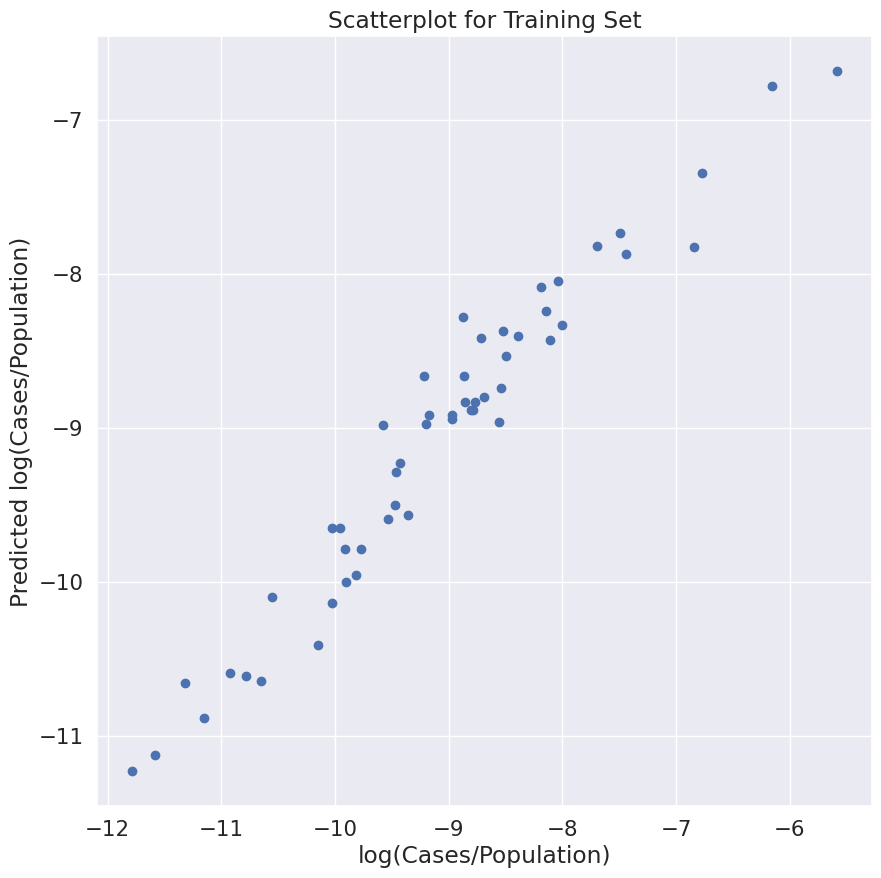

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    1.09870
                       R2:    0.49992


<Figure size 640x480 with 0 Axes>

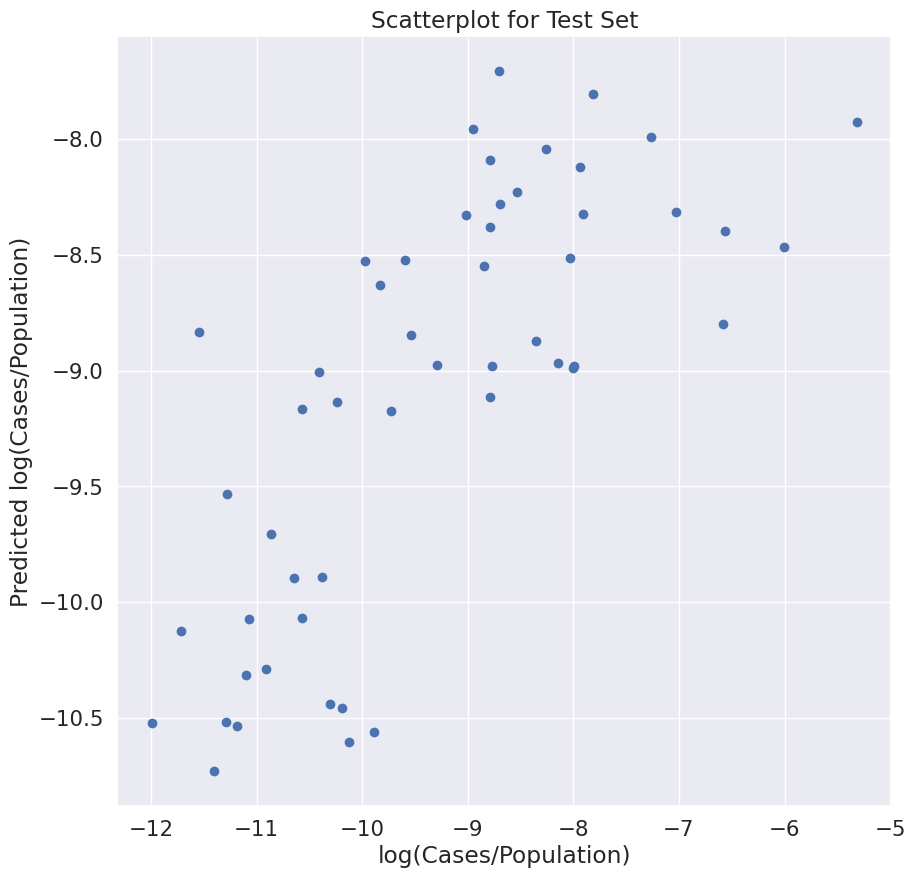

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.01457 +/- 0.01685
Feature:                   Com. Density, Score: 0.61000 +/- 0.13919
Feature:                  Depriv. Index, Score: 0.22615 +/- 0.07086
Feature:                Old Young Ratio, Score: 0.05076 +/- 0.02740
Feature:                      Avg. PM10, Score: 0.13555 +/- 0.03971
Feature:                        Avg. NO, Score: 0.24823 +/- 0.05348
Feature:                      Avg. PANS, Score: 0.00192 +/- 0.02358


<Figure size 640x480 with 0 Axes>

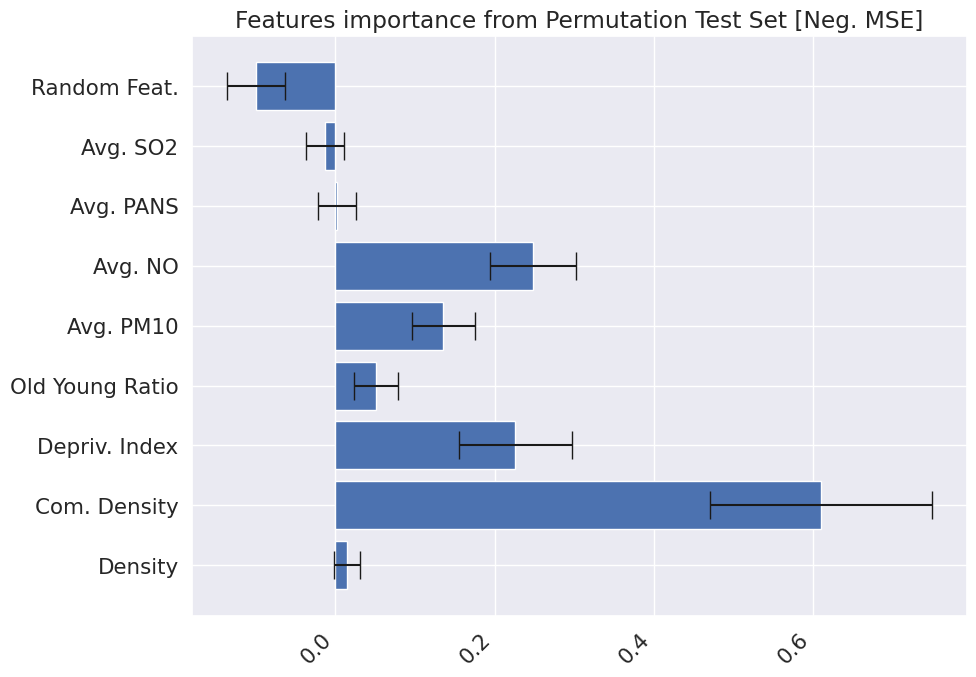

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00604 +/- 0.00698
Feature:                   Com. Density, Score: 0.25270 +/- 0.05766
Feature:                  Depriv. Index, Score: 0.09369 +/- 0.02935
Feature:                Old Young Ratio, Score: 0.02103 +/- 0.01135
Feature:                      Avg. PM10, Score: 0.05615 +/- 0.01645
Feature:                        Avg. NO, Score: 0.10283 +/- 0.02215
Feature:                      Avg. PANS, Score: 0.00079 +/- 0.00977


<Figure size 640x480 with 0 Axes>

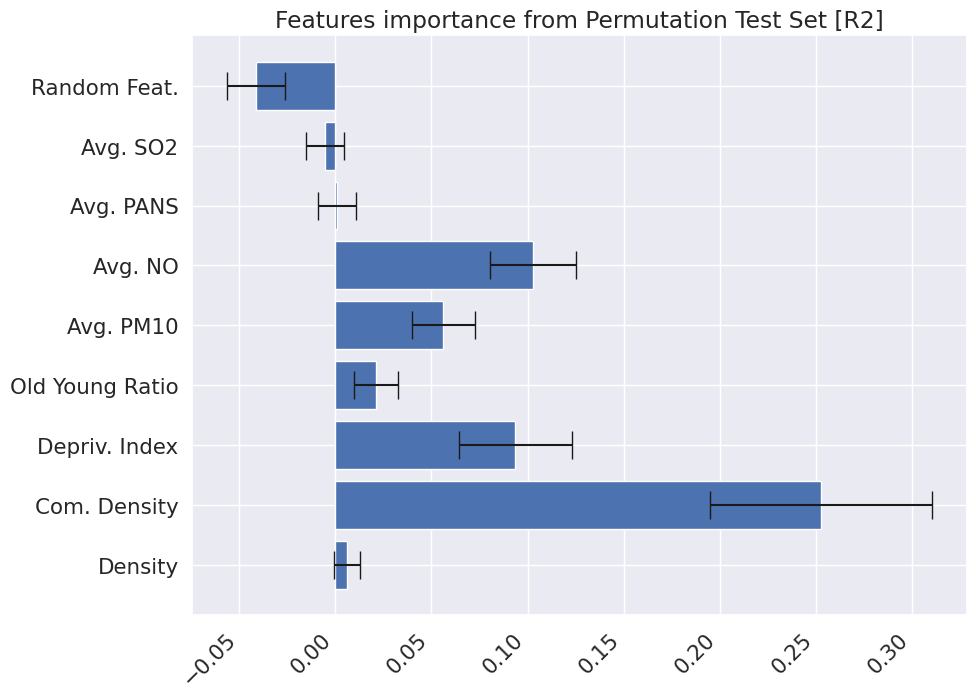

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.45672 +/- 0.09499
Feature:                  Depriv. Index, Score: 0.27792 +/- 0.05220
Feature:                        Avg. NO, Score: 0.17771 +/- 0.03704


<Figure size 640x480 with 0 Axes>

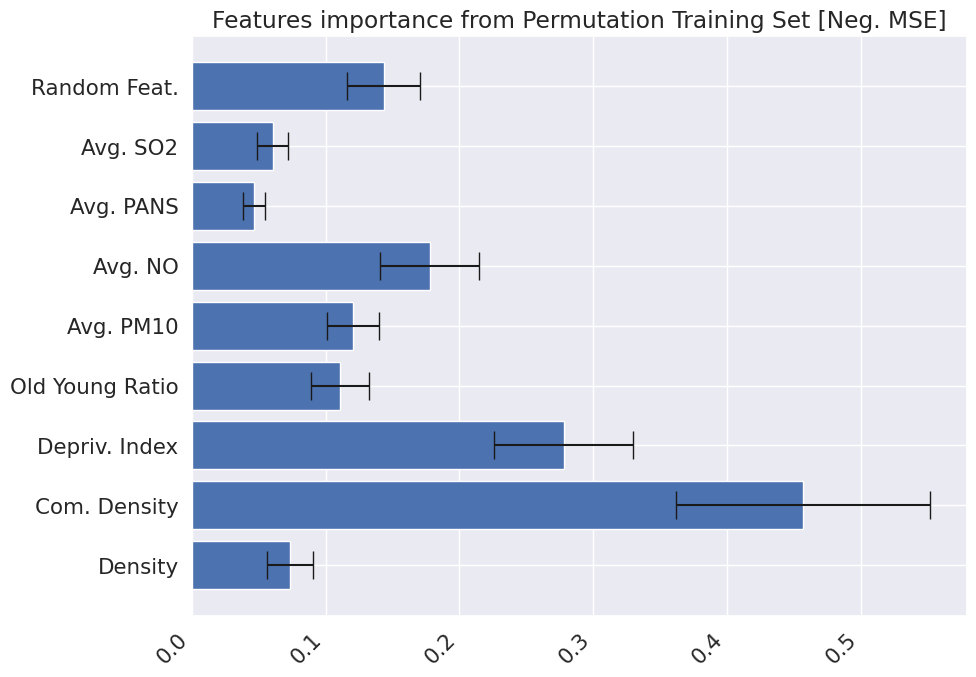

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.27478 +/- 0.05715
Feature:                  Depriv. Index, Score: 0.16720 +/- 0.03140
Feature:                        Avg. NO, Score: 0.10692 +/- 0.02229


<Figure size 640x480 with 0 Axes>

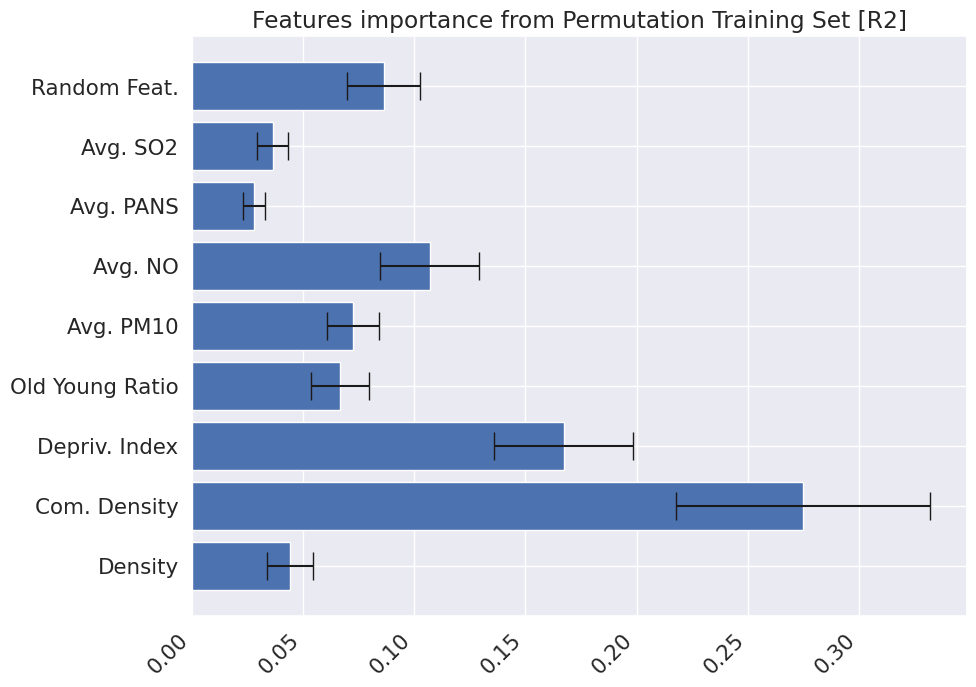

<Figure size 1000x1000 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37698  0.03326 
    Test set average RMSE:  1.05280  0.07941 

Prediction STD :    1.18151
True value STD :    1.43281
Difference in percentage:   17.53856

             Fullset RMSE:    0.36724
                       R2:    0.93431


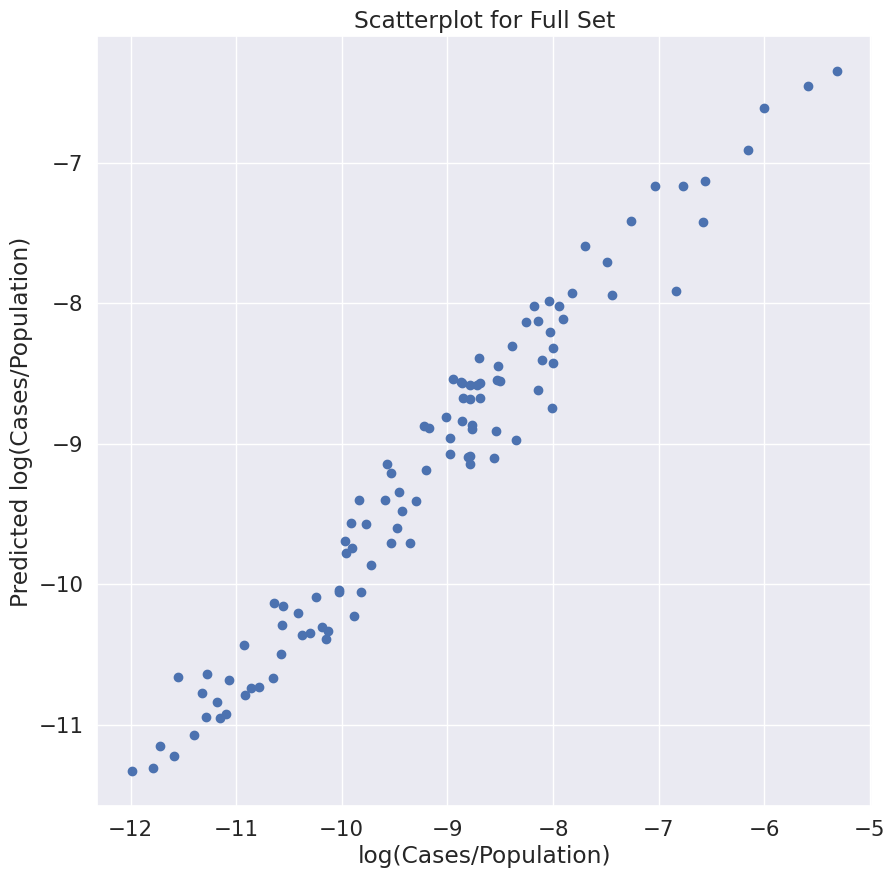

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12041 +/- 0.01301
Feature:                  Depriv. Index, Score: 0.48631 +/- 0.06783
Feature:                Old Young Ratio, Score: 0.15277 +/- 0.01716
Feature:                      Avg. PM10, Score: 0.38987 +/- 0.04868
Feature:                        Avg. NO, Score: 0.54715 +/- 0.07534
Feature:                      Avg. PANS, Score: 0.12626 +/- 0.01398
Feature:                       Avg. SO2, Score: 0.16078 +/- 0.02167


<Figure size 640x480 with 0 Axes>

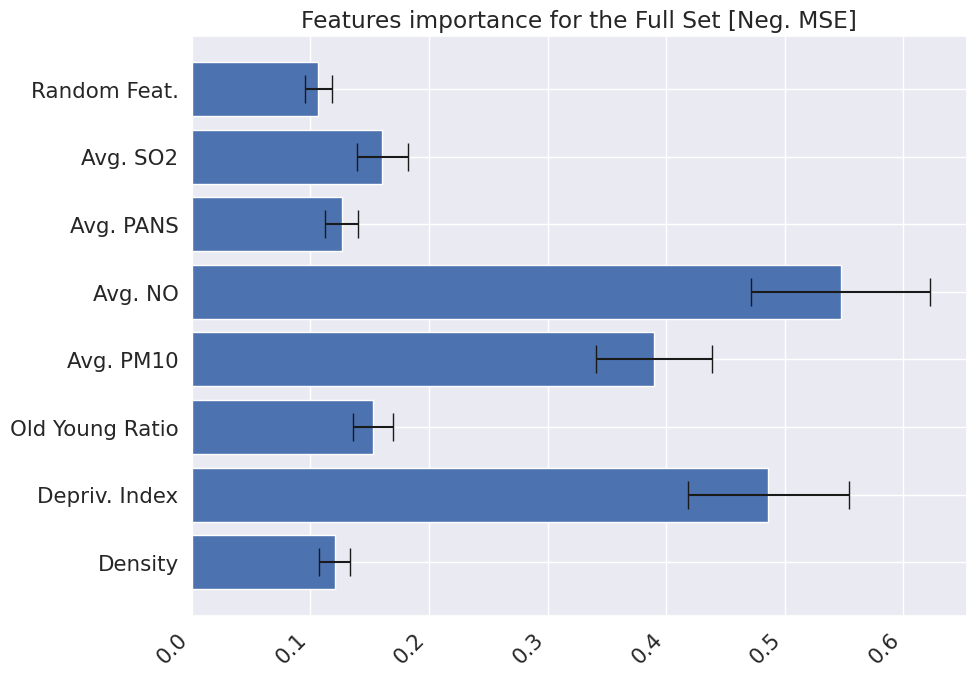

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.05865 +/- 0.00634
Feature:                  Depriv. Index, Score: 0.23688 +/- 0.03304
Feature:                Old Young Ratio, Score: 0.07441 +/- 0.00836
Feature:                      Avg. PM10, Score: 0.18991 +/- 0.02371
Feature:                        Avg. NO, Score: 0.26652 +/- 0.03670
Feature:                      Avg. PANS, Score: 0.06150 +/- 0.00681
Feature:                       Avg. SO2, Score: 0.07832 +/- 0.01056


<Figure size 640x480 with 0 Axes>

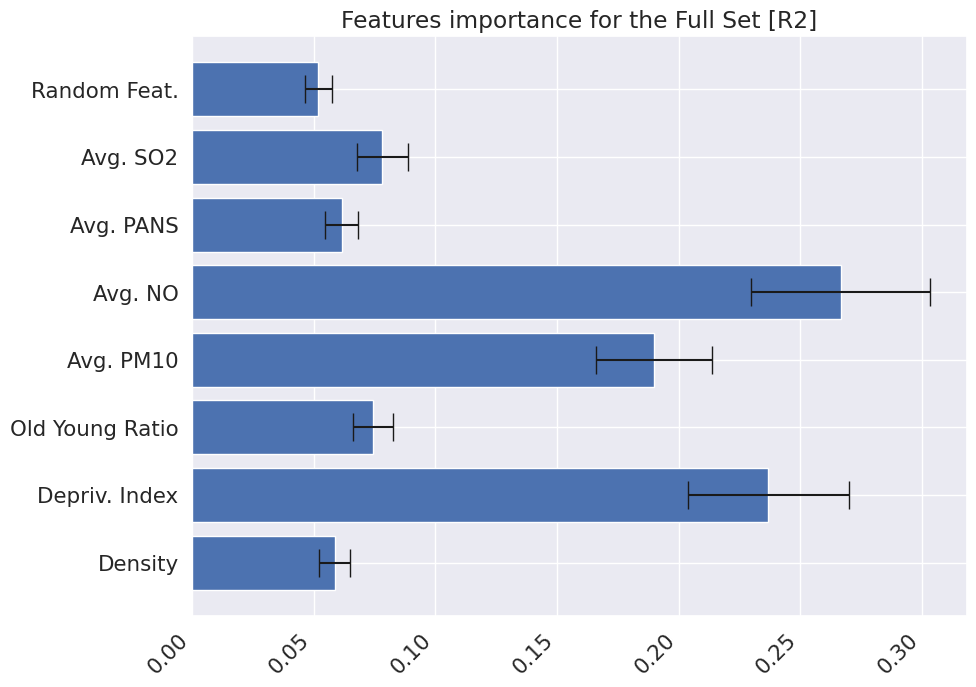

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.41594
                       R2:    0.91577


<Figure size 640x480 with 0 Axes>

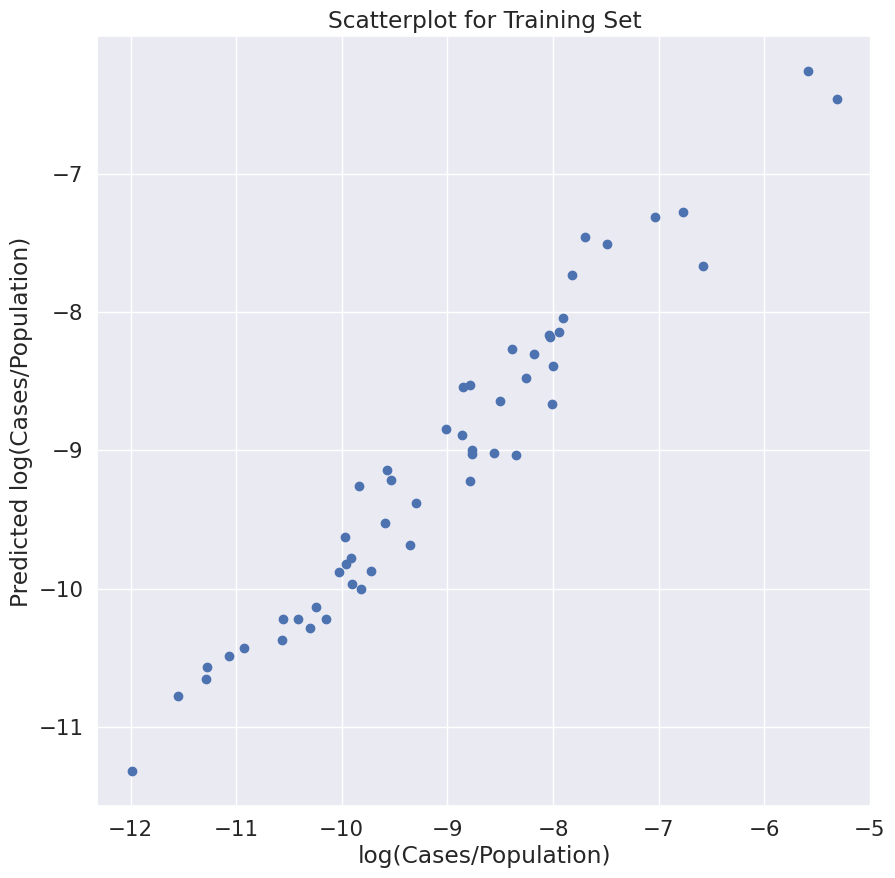

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    1.08231
                       R2:    0.41810


<Figure size 640x480 with 0 Axes>

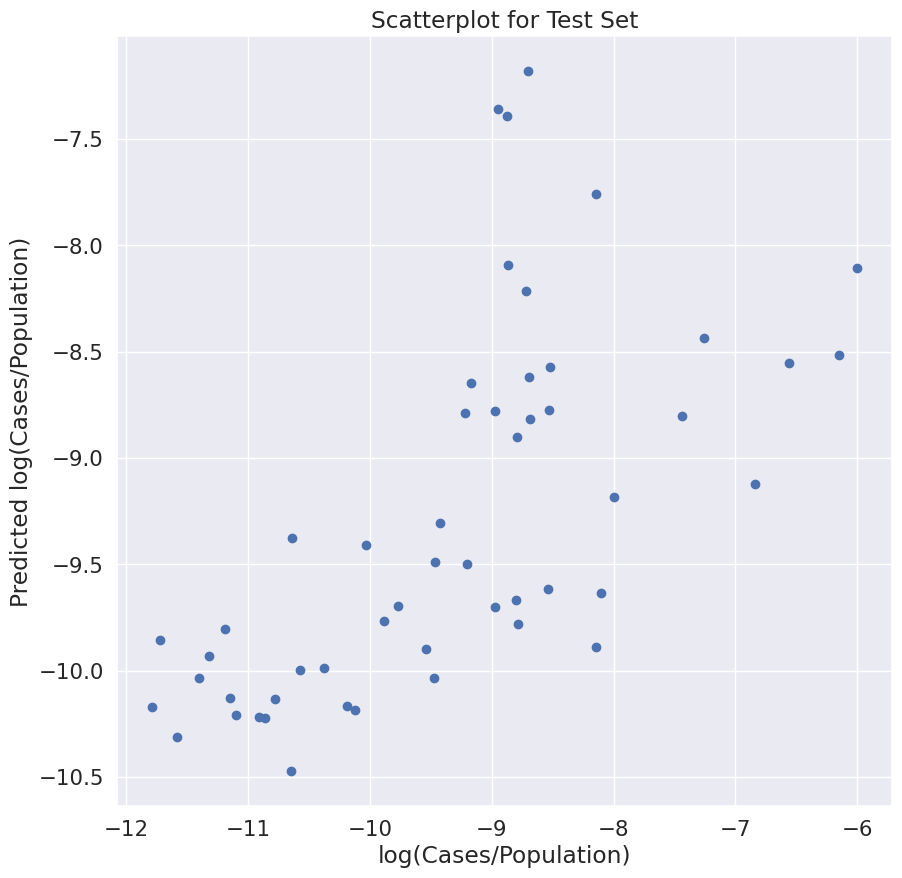

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.25631 +/- 0.08097
Feature:                      Avg. PM10, Score: 0.15364 +/- 0.08068
Feature:                        Avg. NO, Score: 0.15644 +/- 0.09149
Feature:                      Avg. PANS, Score: 0.02998 +/- 0.03197


<Figure size 640x480 with 0 Axes>

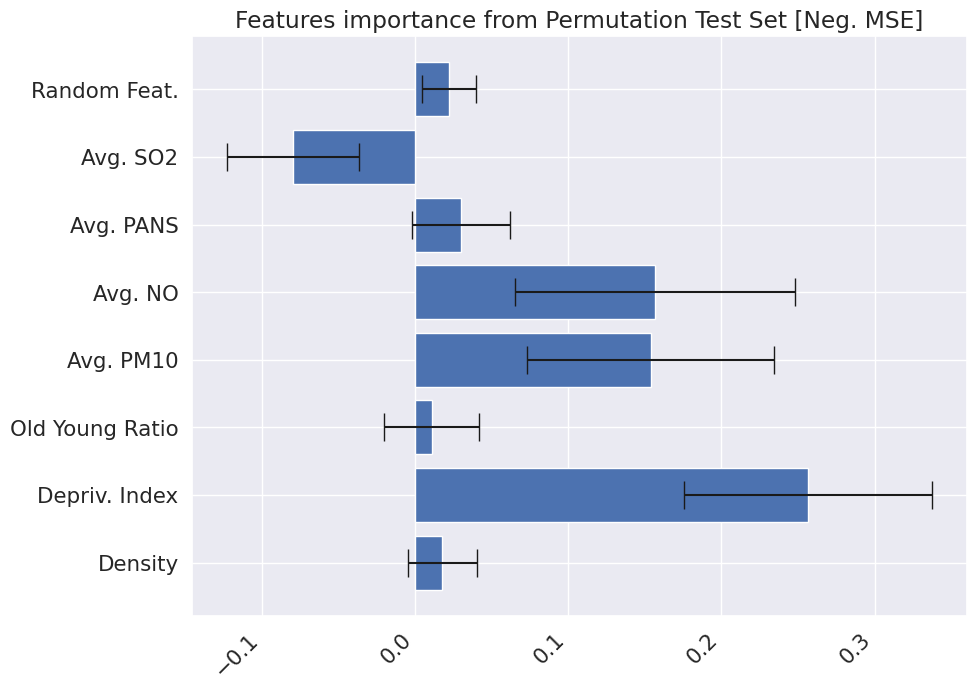

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.12732 +/- 0.04022
Feature:                      Avg. PM10, Score: 0.07632 +/- 0.04008
Feature:                        Avg. NO, Score: 0.07771 +/- 0.04545
Feature:                      Avg. PANS, Score: 0.01489 +/- 0.01588


<Figure size 640x480 with 0 Axes>

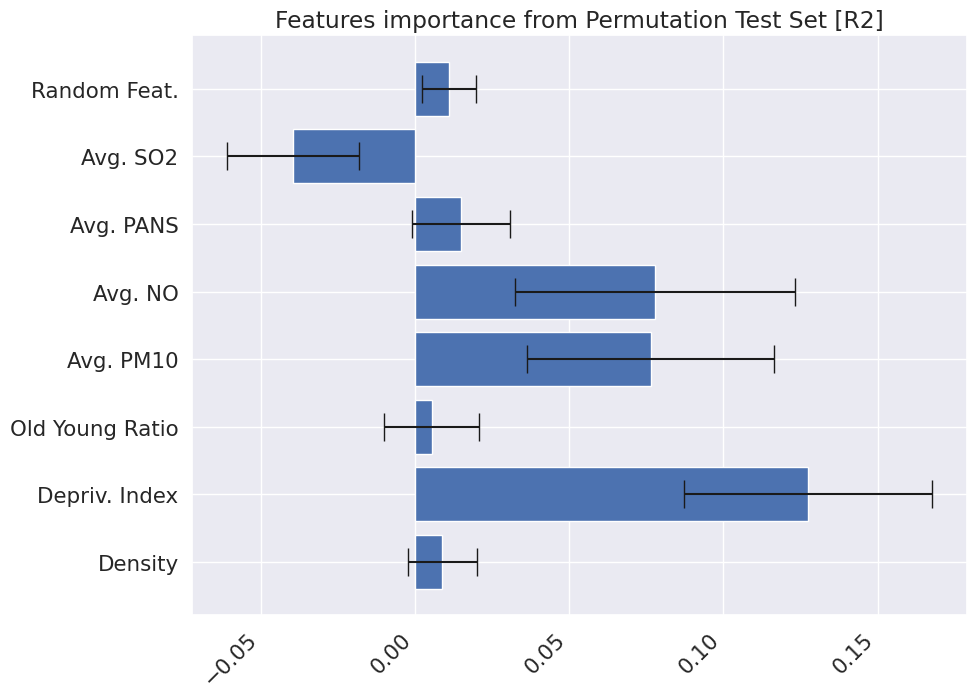

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.09544 +/- 0.01525
Feature:                  Depriv. Index, Score: 0.33987 +/- 0.06996
Feature:                Old Young Ratio, Score: 0.17878 +/- 0.02655
Feature:                      Avg. PM10, Score: 0.47939 +/- 0.09891
Feature:                        Avg. NO, Score: 0.43947 +/- 0.07906
Feature:                      Avg. PANS, Score: 0.14984 +/- 0.02798
Feature:                       Avg. SO2, Score: 0.25620 +/- 0.04052


<Figure size 640x480 with 0 Axes>

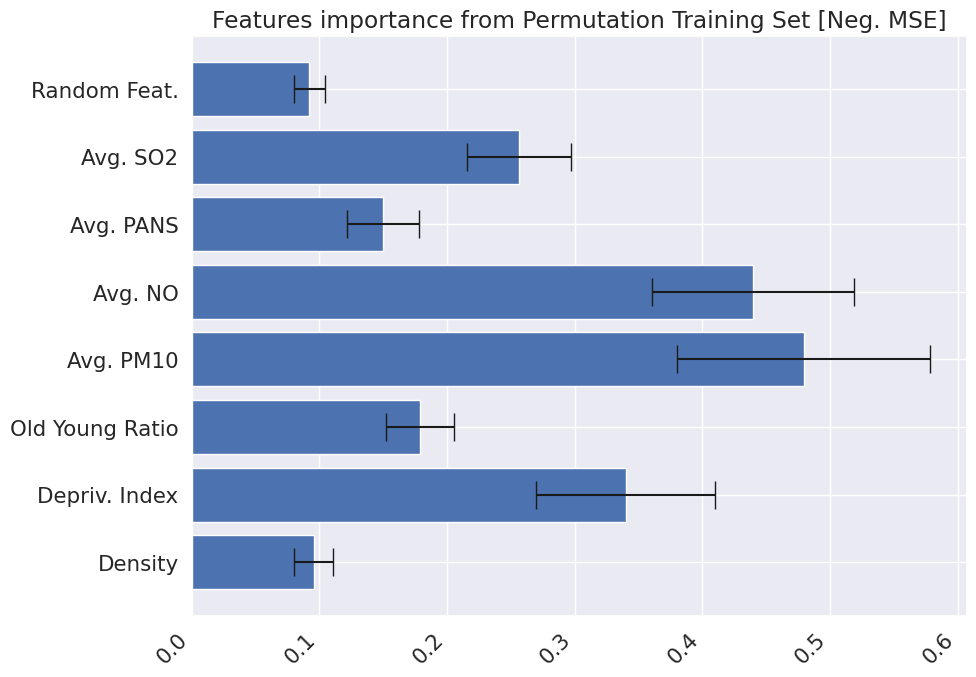

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.04646 +/- 0.00742
Feature:                  Depriv. Index, Score: 0.16546 +/- 0.03406
Feature:                Old Young Ratio, Score: 0.08704 +/- 0.01292
Feature:                      Avg. PM10, Score: 0.23338 +/- 0.04815
Feature:                        Avg. NO, Score: 0.21395 +/- 0.03849
Feature:                      Avg. PANS, Score: 0.07295 +/- 0.01362
Feature:                       Avg. SO2, Score: 0.12473 +/- 0.01973


<Figure size 640x480 with 0 Axes>

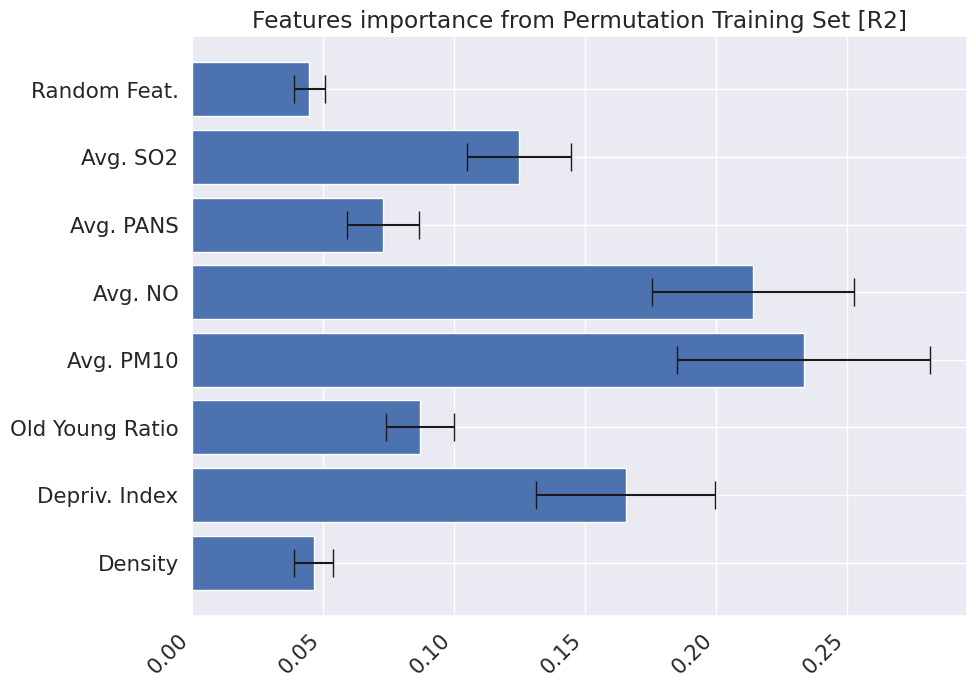

<Figure size 1000x1000 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.82289  0.06049 
    Test set average RMSE:  0.88185  0.07751 

Prediction STD :    1.16651
True value STD :    1.43281
Difference in percentage:   18.58597

             Fullset RMSE:    0.74623
                       R2:    0.72875


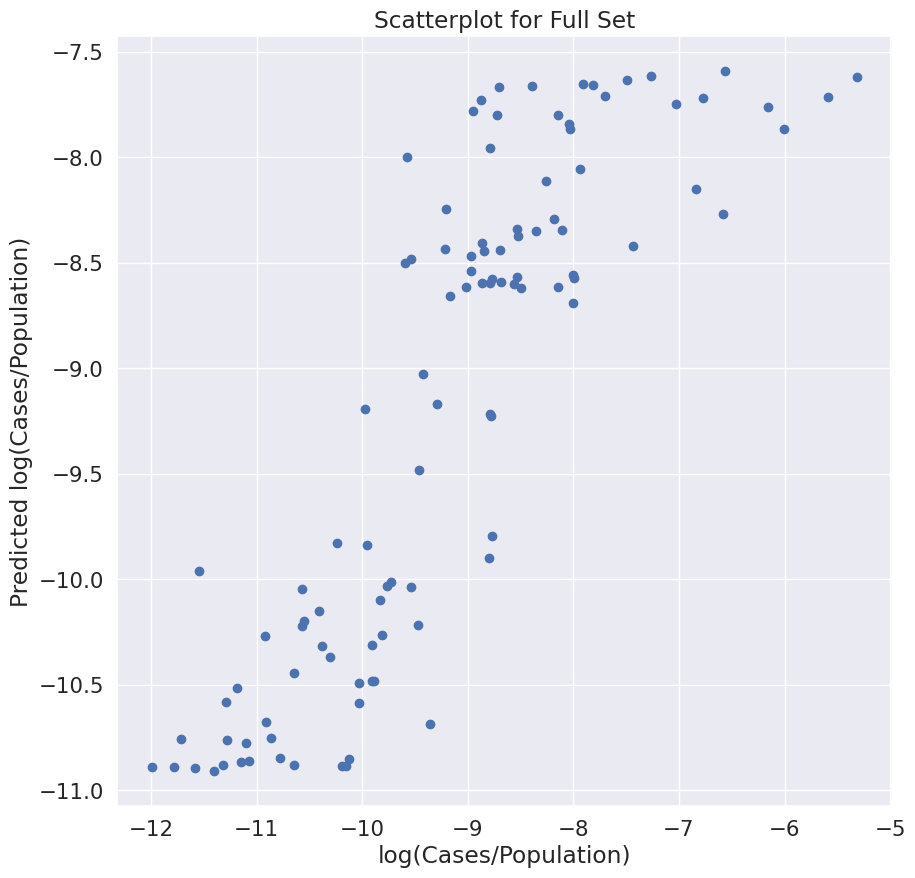

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00310 +/- 0.00118
Feature:                   Com. Density, Score: 0.00183 +/- 0.00099
Feature:                  Depriv. Index, Score: 0.00488 +/- 0.00154
Feature:                       Latitude, Score: 2.24246 +/- 0.29164
Feature:                Old Young Ratio, Score: 0.02932 +/- 0.01281
Feature:                      Avg. PM10, Score: 0.01668 +/- 0.00944
Feature:                        Avg. NO, Score: 0.11236 +/- 0.02988
Feature:                      Avg. PANS, Score: 0.00264 +/- 0.00119
Feature:                       Avg. SO2, Score: 0.00682 +/- 0.00148


<Figure size 640x480 with 0 Axes>

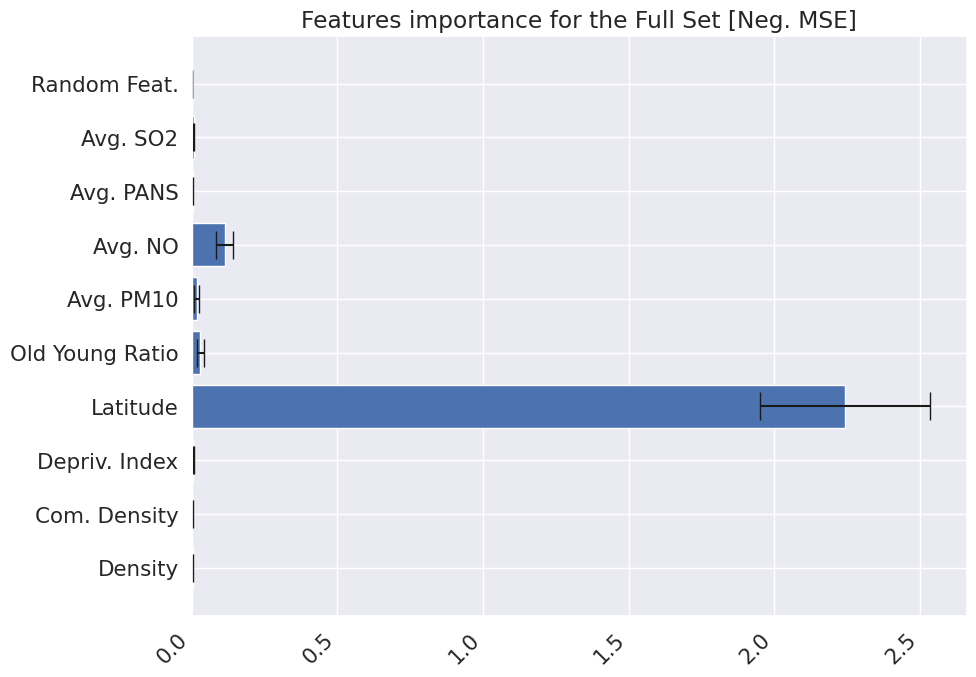

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.00151 +/- 0.00057
Feature:                   Com. Density, Score: 0.00089 +/- 0.00048
Feature:                  Depriv. Index, Score: 0.00237 +/- 0.00075
Feature:                       Latitude, Score: 1.09232 +/- 0.14206
Feature:                Old Young Ratio, Score: 0.01428 +/- 0.00624
Feature:                      Avg. PM10, Score: 0.00812 +/- 0.00460
Feature:                        Avg. NO, Score: 0.05473 +/- 0.01455
Feature:                      Avg. PANS, Score: 0.00129 +/- 0.00058
Feature:                       Avg. SO2, Score: 0.00332 +/- 0.00072


<Figure size 640x480 with 0 Axes>

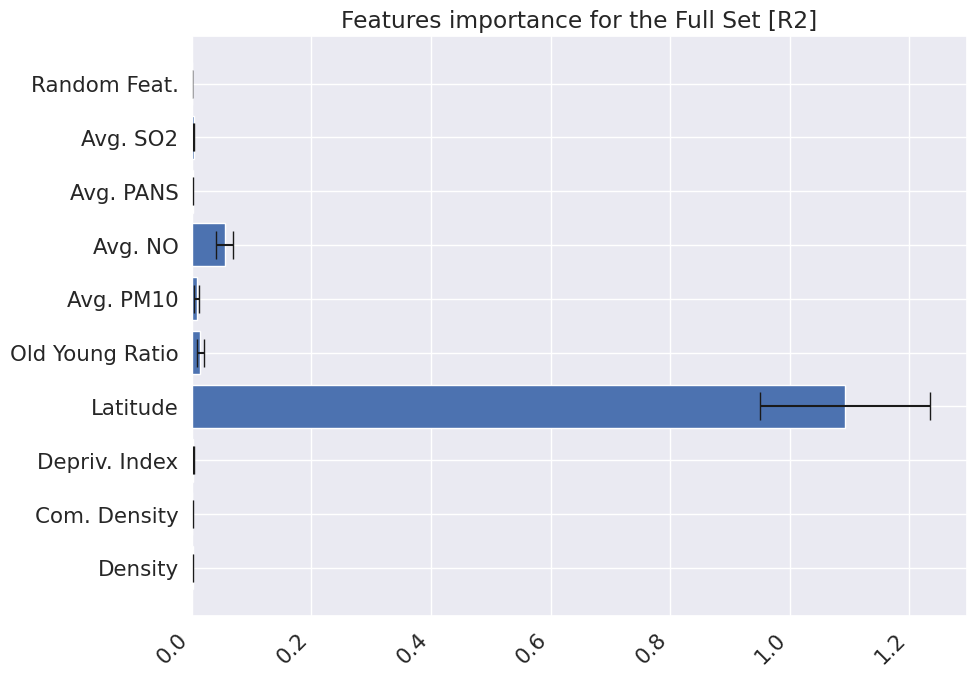

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.93134
                       R2:    0.62588


<Figure size 640x480 with 0 Axes>

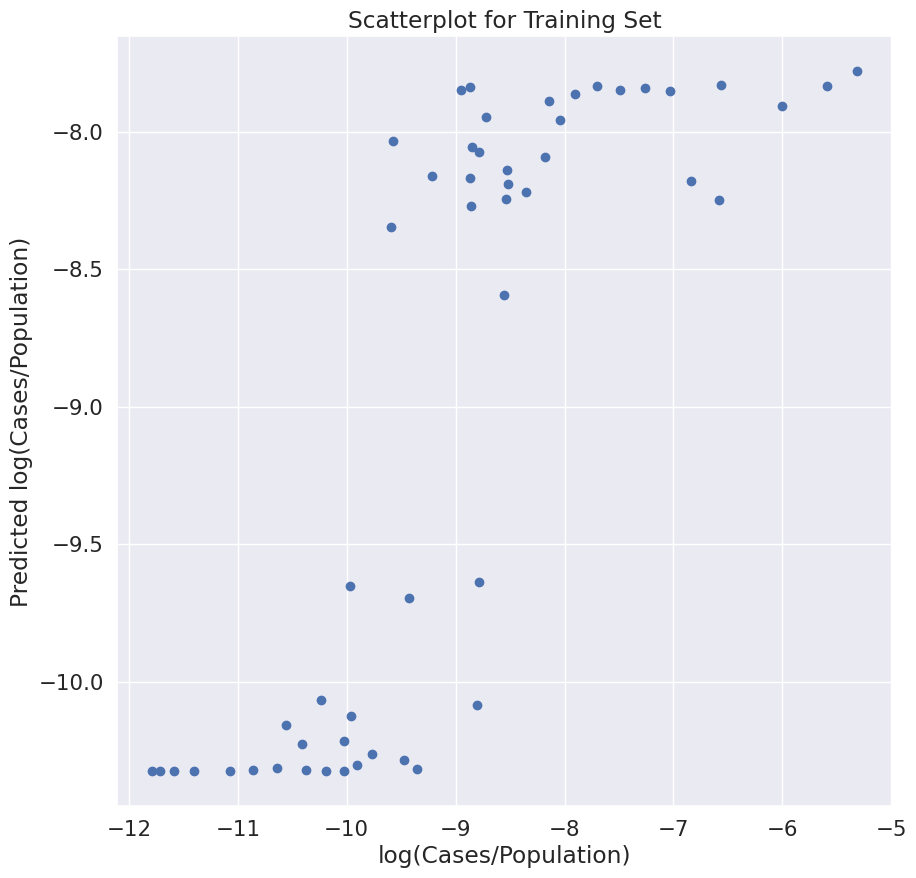

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    0.76619
                       R2:    0.65565


<Figure size 640x480 with 0 Axes>

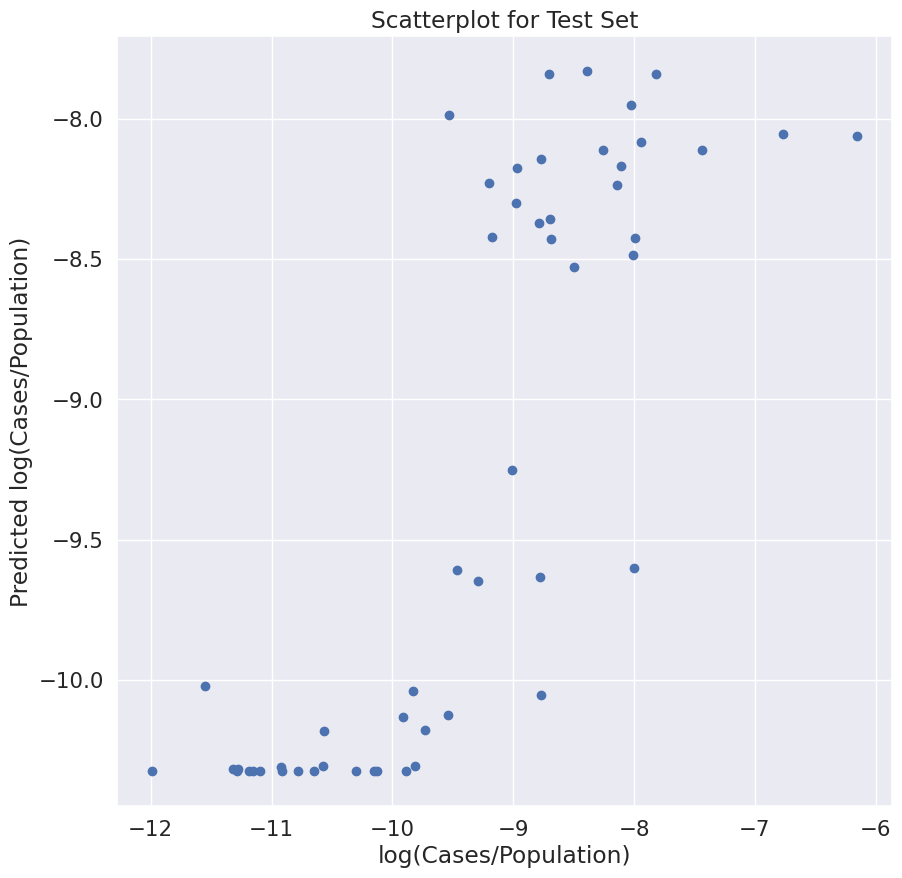

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.01745 +/- 0.00971
Feature:                  Depriv. Index, Score: 0.00146 +/- 0.00059
Feature:                       Latitude, Score: 1.76347 +/- 0.29861
Feature:                Old Young Ratio, Score: 0.00265 +/- 0.00436
Feature:                      Avg. PM10, Score: 0.01032 +/- 0.01309
Feature:                        Avg. NO, Score: 0.00976 +/- 0.00592
Feature:                       Avg. SO2, Score: 0.00000 +/- 0.00011


<Figure size 640x480 with 0 Axes>

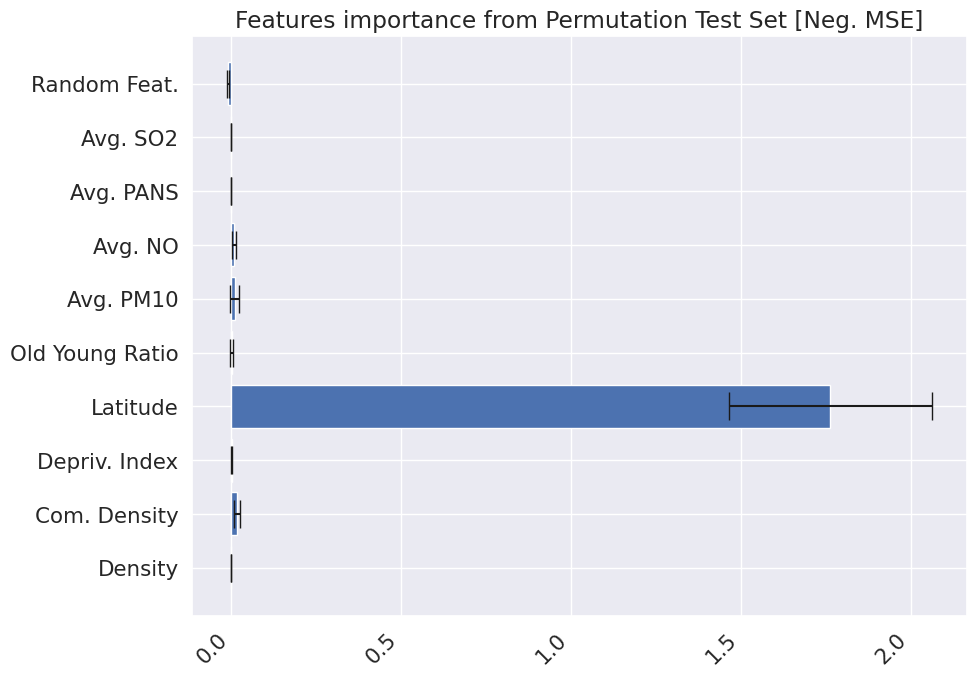

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.01024 +/- 0.00570
Feature:                  Depriv. Index, Score: 0.00085 +/- 0.00034
Feature:                       Latitude, Score: 1.03442 +/- 0.17516
Feature:                Old Young Ratio, Score: 0.00155 +/- 0.00256
Feature:                      Avg. PM10, Score: 0.00606 +/- 0.00768
Feature:                        Avg. NO, Score: 0.00573 +/- 0.00347
Feature:                       Avg. SO2, Score: 0.00000 +/- 0.00006


<Figure size 640x480 with 0 Axes>

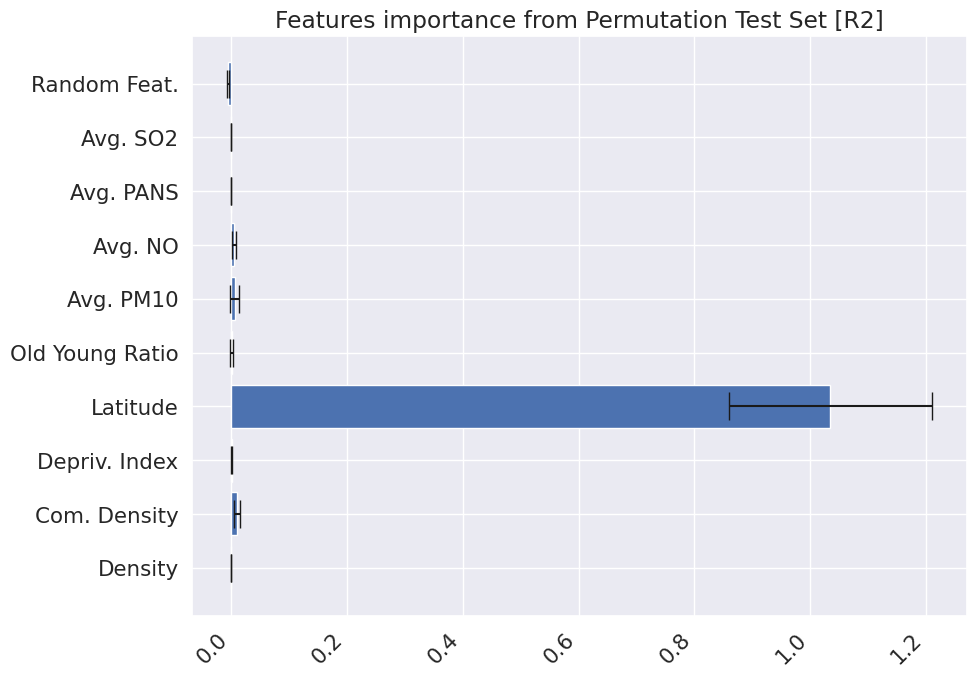

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.02462 +/- 0.01698
Feature:                       Latitude, Score: 2.12320 +/- 0.40201
Feature:                      Avg. PM10, Score: 0.04545 +/- 0.02275
Feature:                        Avg. NO, Score: 0.03047 +/- 0.01595


<Figure size 640x480 with 0 Axes>

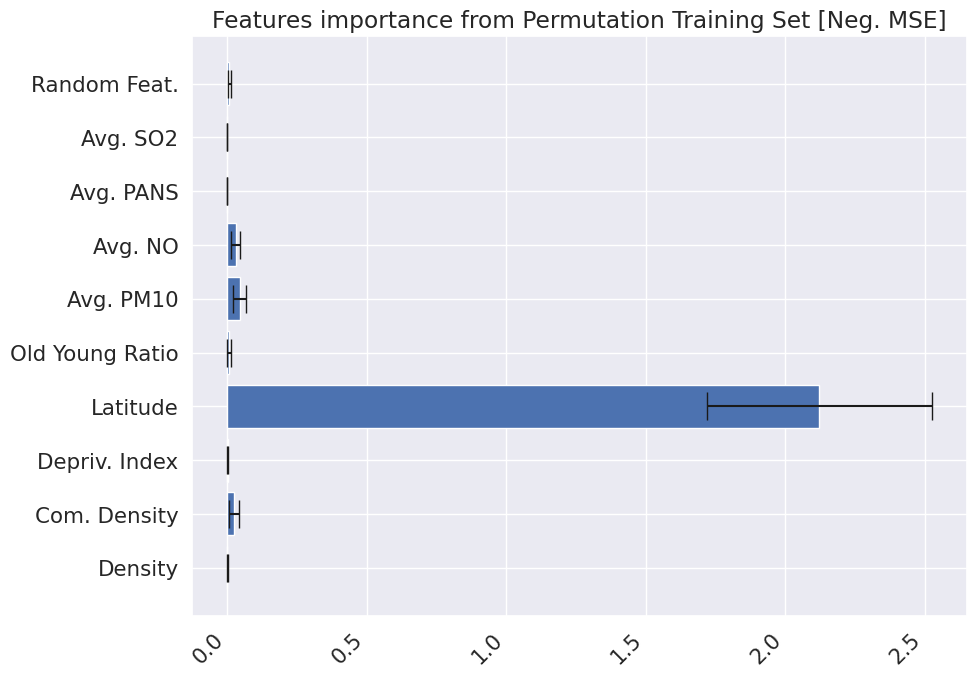

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.01062 +/- 0.00732
Feature:                       Latitude, Score: 0.91576 +/- 0.17339
Feature:                      Avg. PM10, Score: 0.01960 +/- 0.00981
Feature:                        Avg. NO, Score: 0.01314 +/- 0.00688


<Figure size 640x480 with 0 Axes>

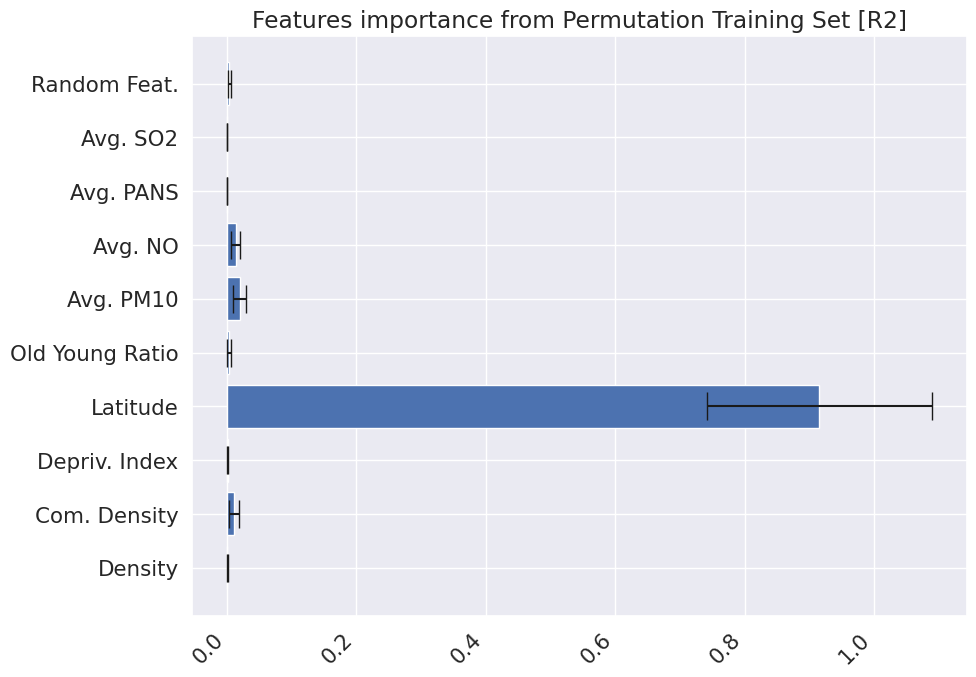

<Figure size 1000x1000 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.52645  0.04569 
    Test set average RMSE:  0.99166  0.08043 

Prediction STD :    1.16053
True value STD :    1.43281
Difference in percentage:   19.00316

             Fullset RMSE:    0.49344
                       R2:    0.88140


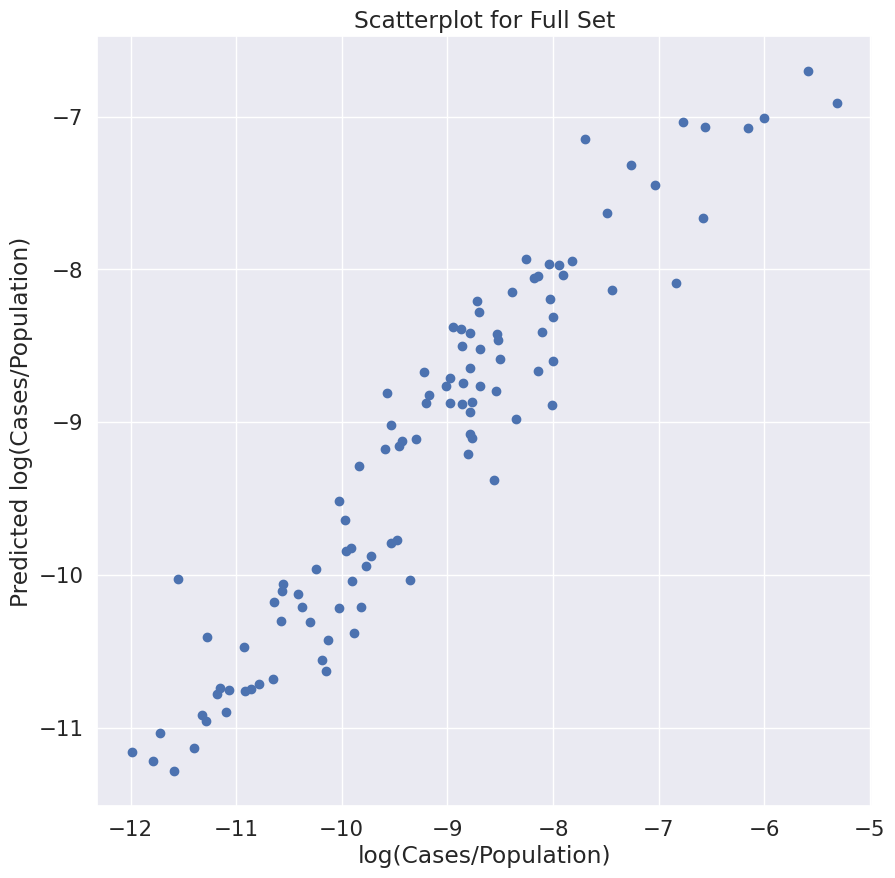

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.64759 +/- 0.09785
Feature:                  Depriv. Index, Score: 0.22194 +/- 0.03216
Feature:                Old Young Ratio, Score: 0.10376 +/- 0.01234
Feature:                      Avg. PM10, Score: 0.26594 +/- 0.03497
Feature:                        Avg. NO, Score: 0.29363 +/- 0.04119
Feature:                       Avg. SO2, Score: 0.10165 +/- 0.01731


<Figure size 640x480 with 0 Axes>

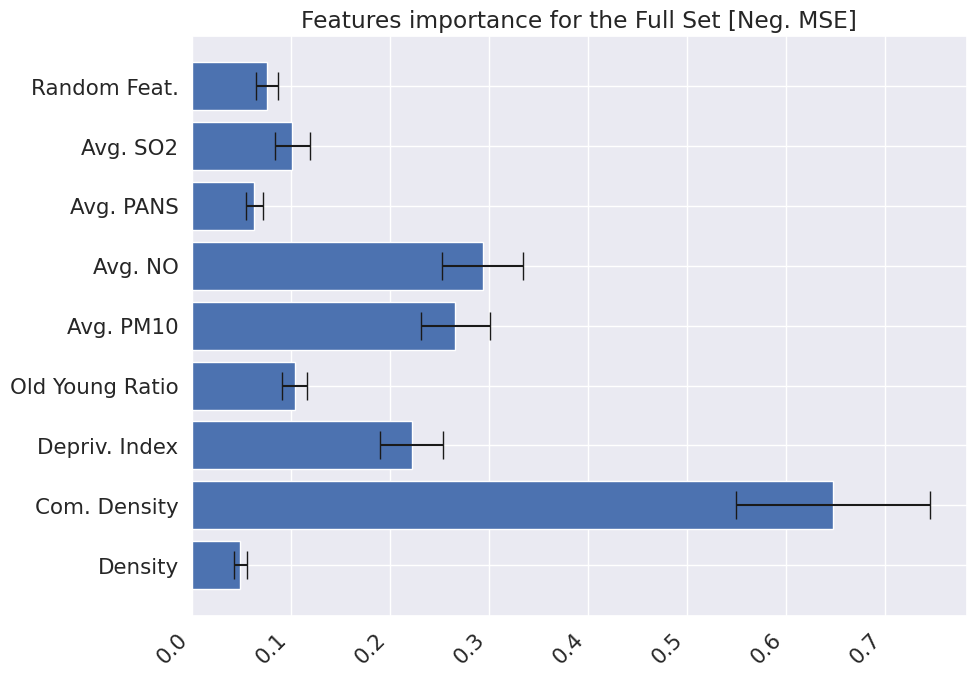

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.31545 +/- 0.04767
Feature:                  Depriv. Index, Score: 0.10811 +/- 0.01566
Feature:                Old Young Ratio, Score: 0.05054 +/- 0.00601
Feature:                      Avg. PM10, Score: 0.12954 +/- 0.01703
Feature:                        Avg. NO, Score: 0.14303 +/- 0.02006
Feature:                       Avg. SO2, Score: 0.04951 +/- 0.00843


<Figure size 640x480 with 0 Axes>

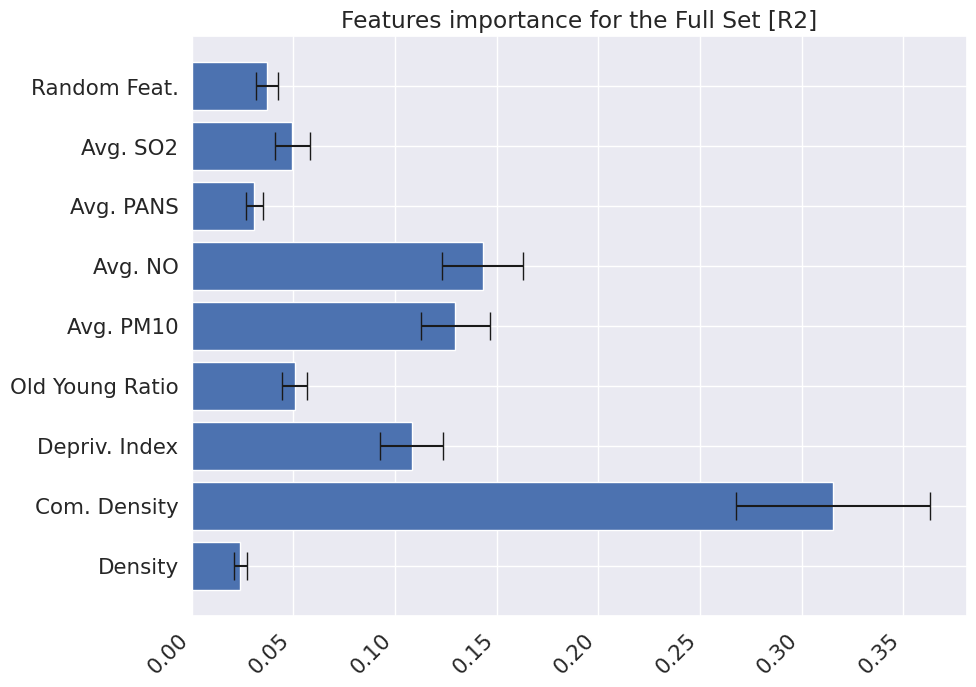

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.53888
                       R2:    0.85382


<Figure size 640x480 with 0 Axes>

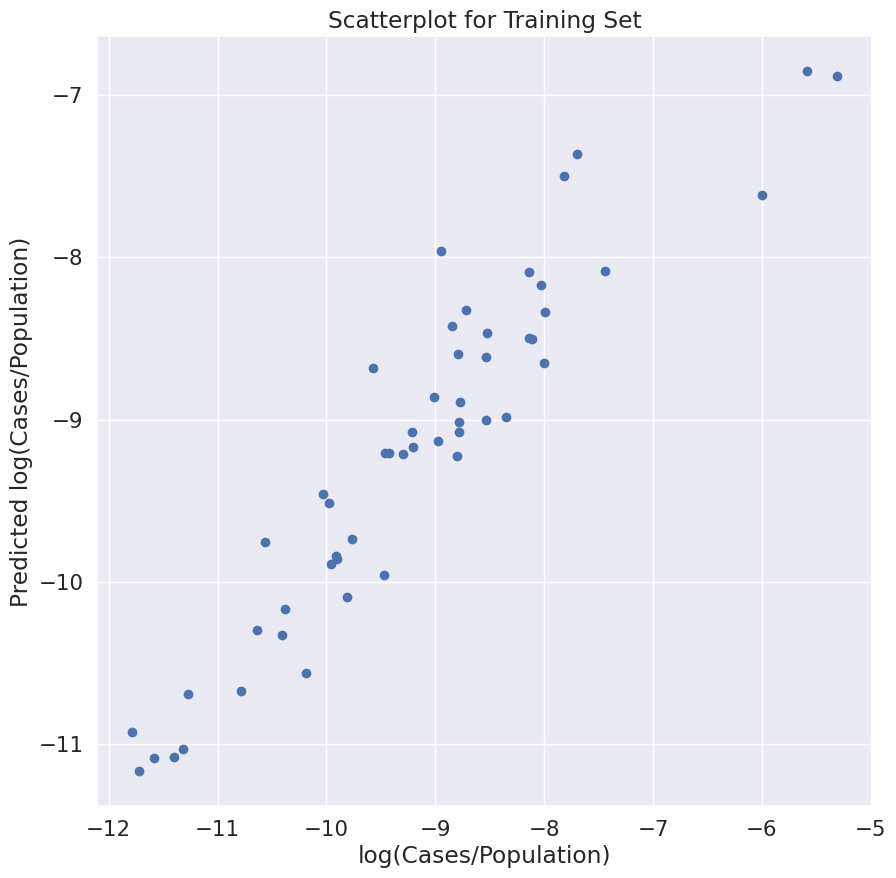

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    1.00793
                       R2:    0.52058


<Figure size 640x480 with 0 Axes>

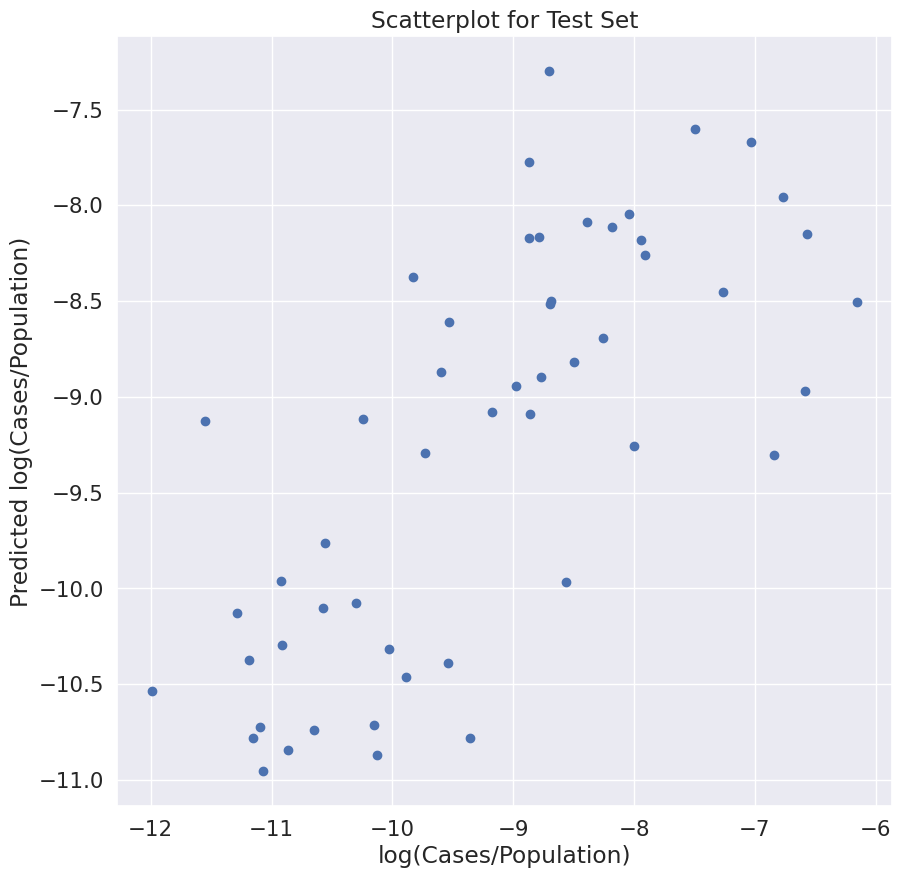

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.48700 +/- 0.13272
Feature:                  Depriv. Index, Score: 0.10921 +/- 0.04281
Feature:                Old Young Ratio, Score: 0.01989 +/- 0.01449
Feature:                      Avg. PM10, Score: 0.06901 +/- 0.07729
Feature:                        Avg. NO, Score: 0.17534 +/- 0.09394


<Figure size 640x480 with 0 Axes>

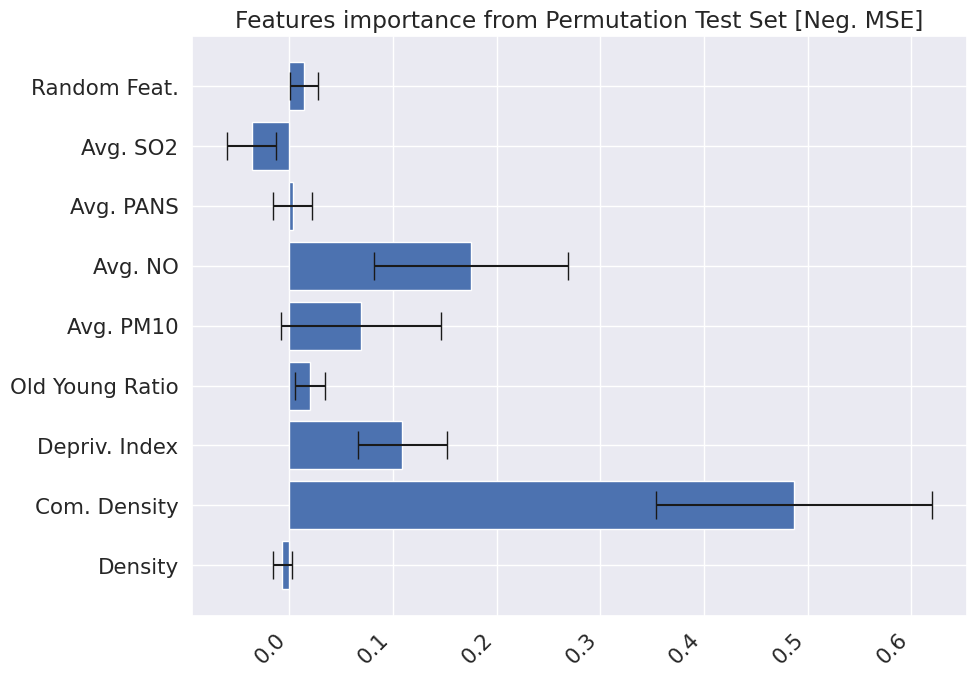

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.22982 +/- 0.06263
Feature:                  Depriv. Index, Score: 0.05154 +/- 0.02020
Feature:                Old Young Ratio, Score: 0.00939 +/- 0.00684
Feature:                      Avg. PM10, Score: 0.03256 +/- 0.03648
Feature:                        Avg. NO, Score: 0.08275 +/- 0.04433


<Figure size 640x480 with 0 Axes>

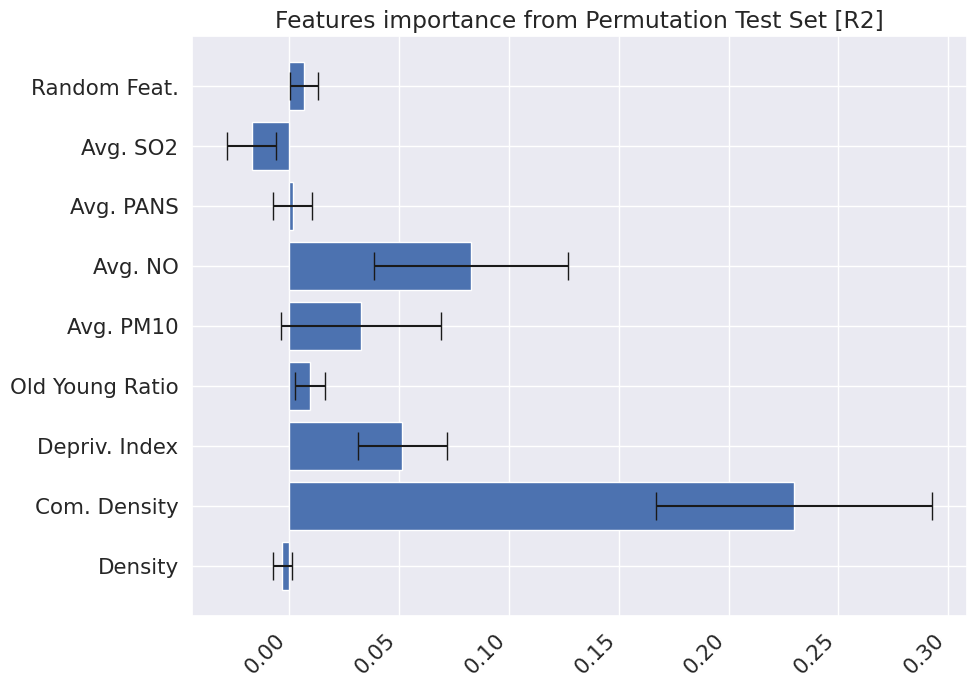

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.57416 +/- 0.10094
Feature:                  Depriv. Index, Score: 0.13618 +/- 0.02962
Feature:                      Avg. PM10, Score: 0.32423 +/- 0.06622
Feature:                        Avg. NO, Score: 0.29820 +/- 0.04715
Feature:                      Avg. PANS, Score: 0.08866 +/- 0.01424
Feature:                       Avg. SO2, Score: 0.07536 +/- 0.02031


<Figure size 640x480 with 0 Axes>

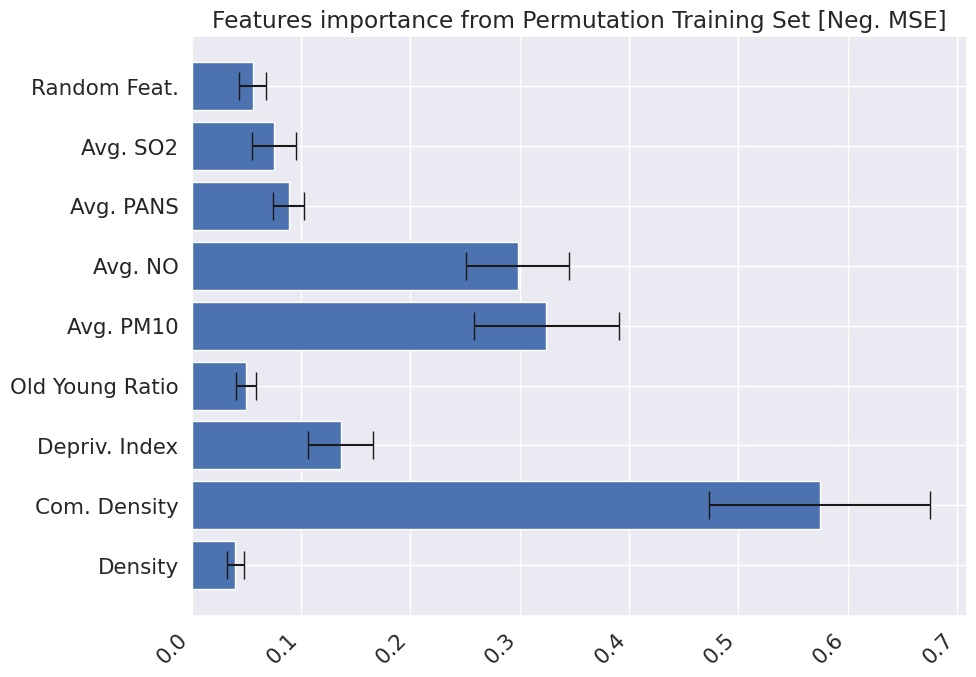

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.28903 +/- 0.05081
Feature:                  Depriv. Index, Score: 0.06855 +/- 0.01491
Feature:                      Avg. PM10, Score: 0.16321 +/- 0.03333
Feature:                        Avg. NO, Score: 0.15011 +/- 0.02374
Feature:                      Avg. PANS, Score: 0.04463 +/- 0.00717
Feature:                       Avg. SO2, Score: 0.03793 +/- 0.01022


<Figure size 640x480 with 0 Axes>

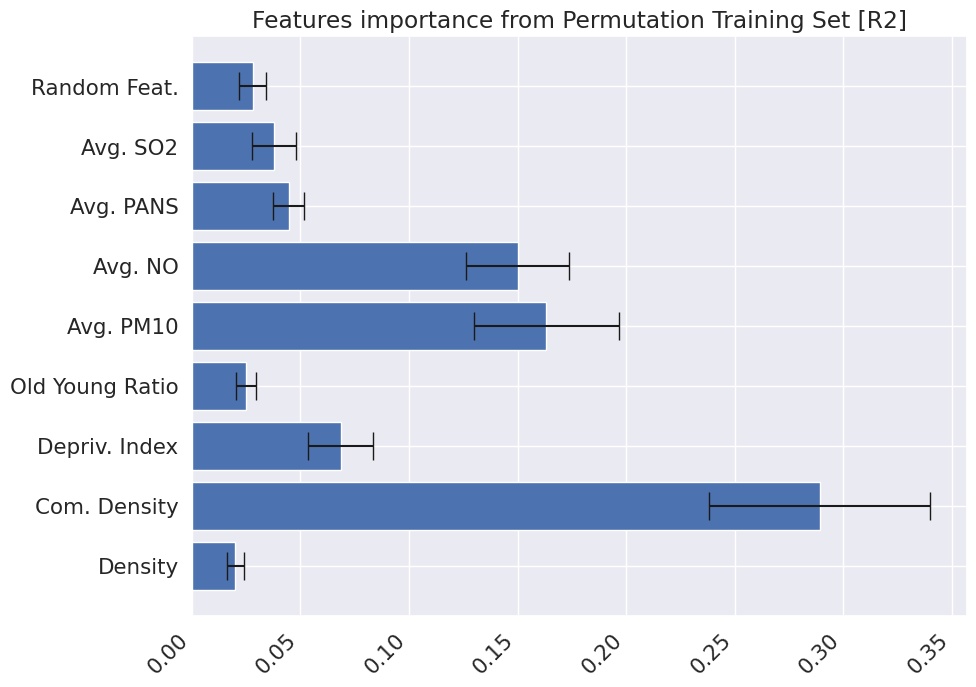

<Figure size 1000x1000 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_testset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38352  0.02441 
    Test set average RMSE:  1.04060  0.07170 

Prediction STD :    1.18033
True value STD :    1.43281
Difference in percentage:   17.62136

             Fullset RMSE:    0.36659
                       R2:    0.93454


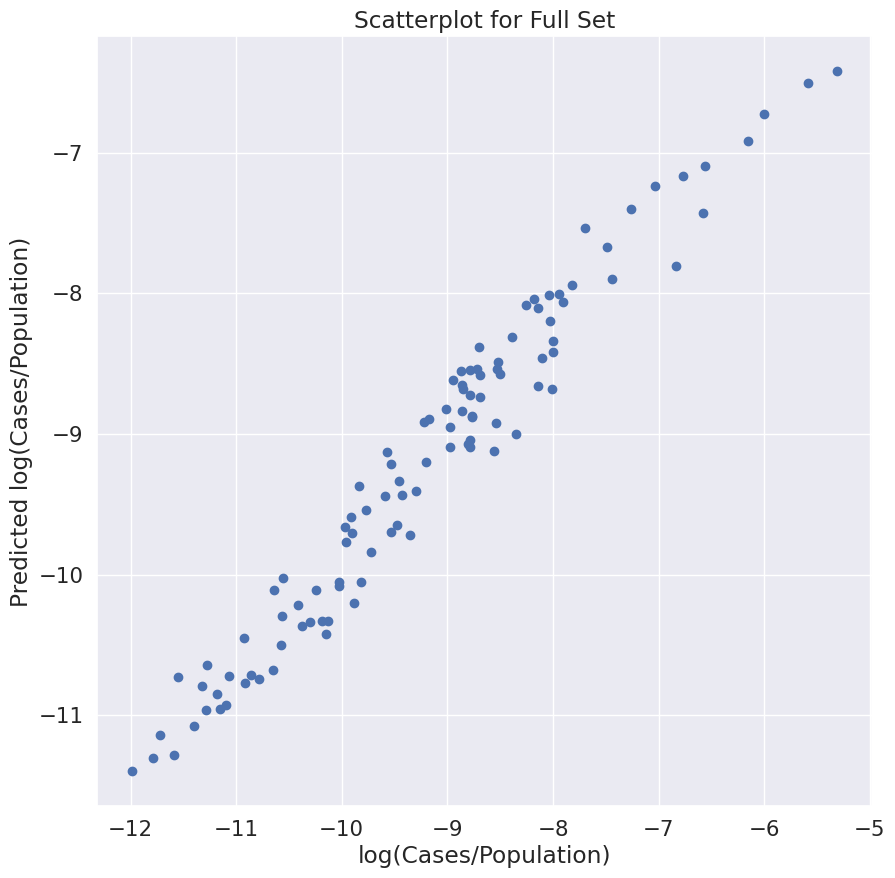

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.11786 +/- 0.01359
Feature:                  Depriv. Index, Score: 0.49298 +/- 0.06619
Feature:                Old Young Ratio, Score: 0.15934 +/- 0.01758
Feature:                      Avg. PM10, Score: 0.45088 +/- 0.05692
Feature:                        Avg. NO, Score: 0.47148 +/- 0.06439
Feature:                      Avg. PANS, Score: 0.12113 +/- 0.01254
Feature:                       Avg. SO2, Score: 0.16386 +/- 0.02149


<Figure size 640x480 with 0 Axes>

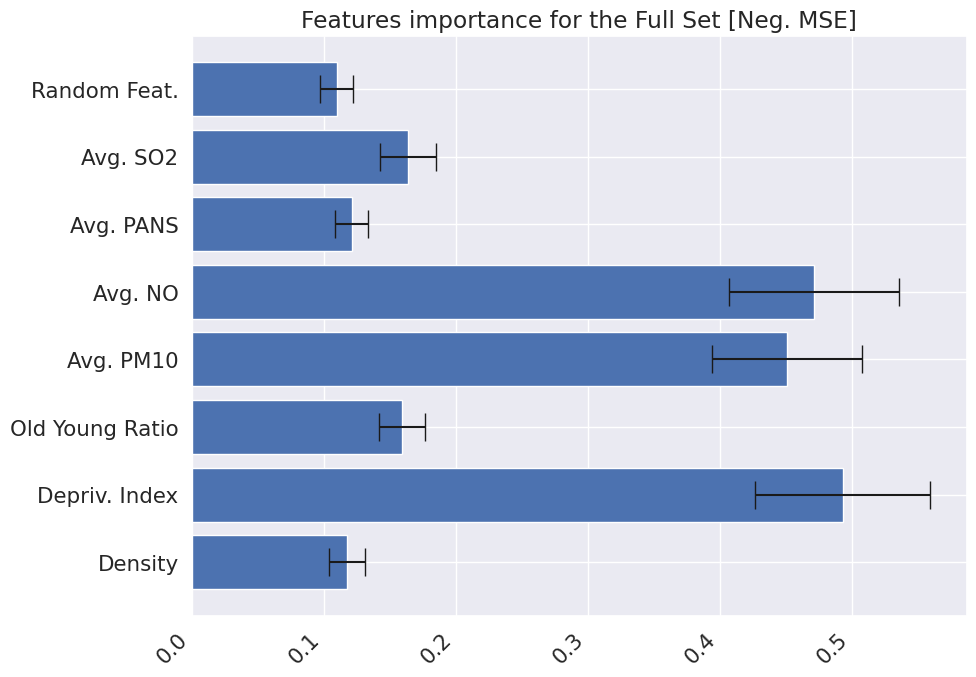

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.05741 +/- 0.00662
Feature:                  Depriv. Index, Score: 0.24013 +/- 0.03224
Feature:                Old Young Ratio, Score: 0.07762 +/- 0.00857
Feature:                      Avg. PM10, Score: 0.21963 +/- 0.02773
Feature:                        Avg. NO, Score: 0.22966 +/- 0.03137
Feature:                      Avg. PANS, Score: 0.05900 +/- 0.00611
Feature:                       Avg. SO2, Score: 0.07982 +/- 0.01047


<Figure size 640x480 with 0 Axes>

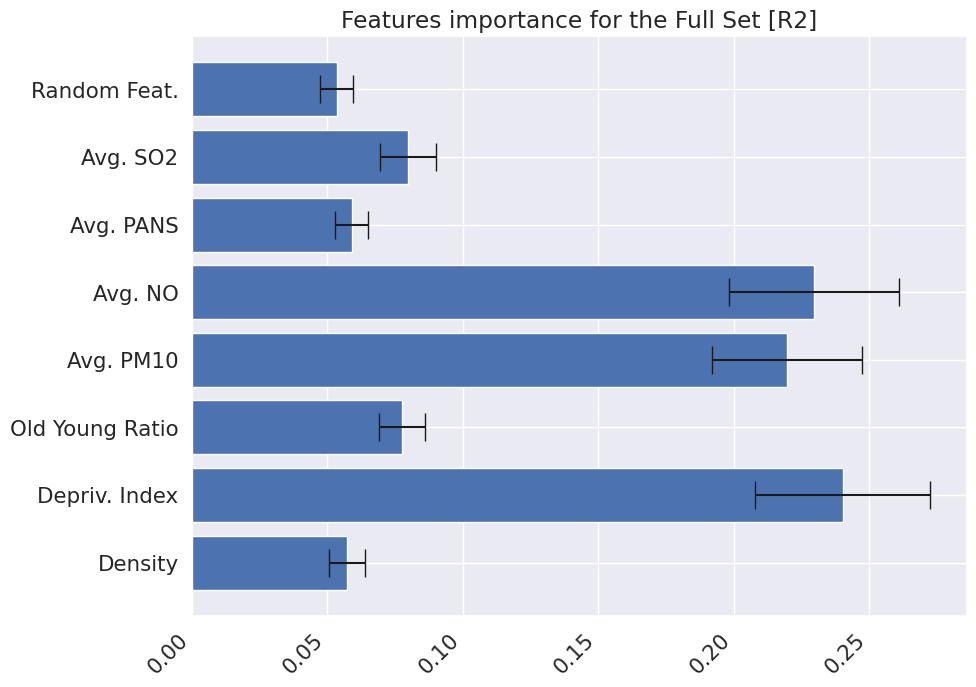

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.38031
                       R2:    0.92700


<Figure size 640x480 with 0 Axes>

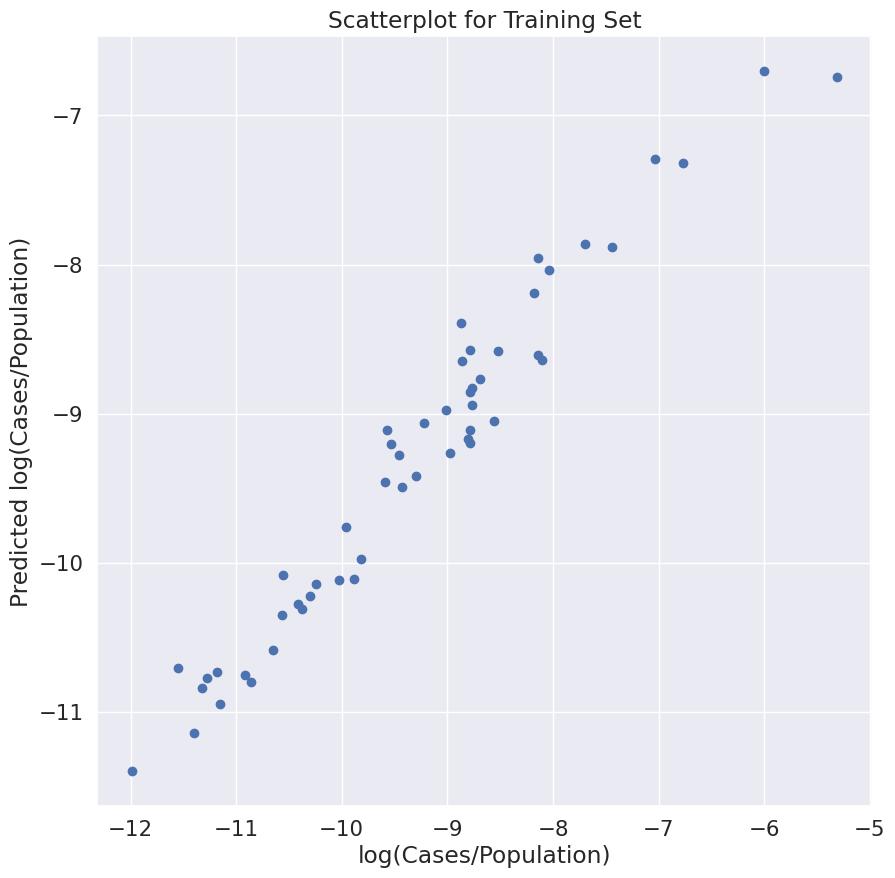

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    1.06788
                       R2:    0.45635


<Figure size 640x480 with 0 Axes>

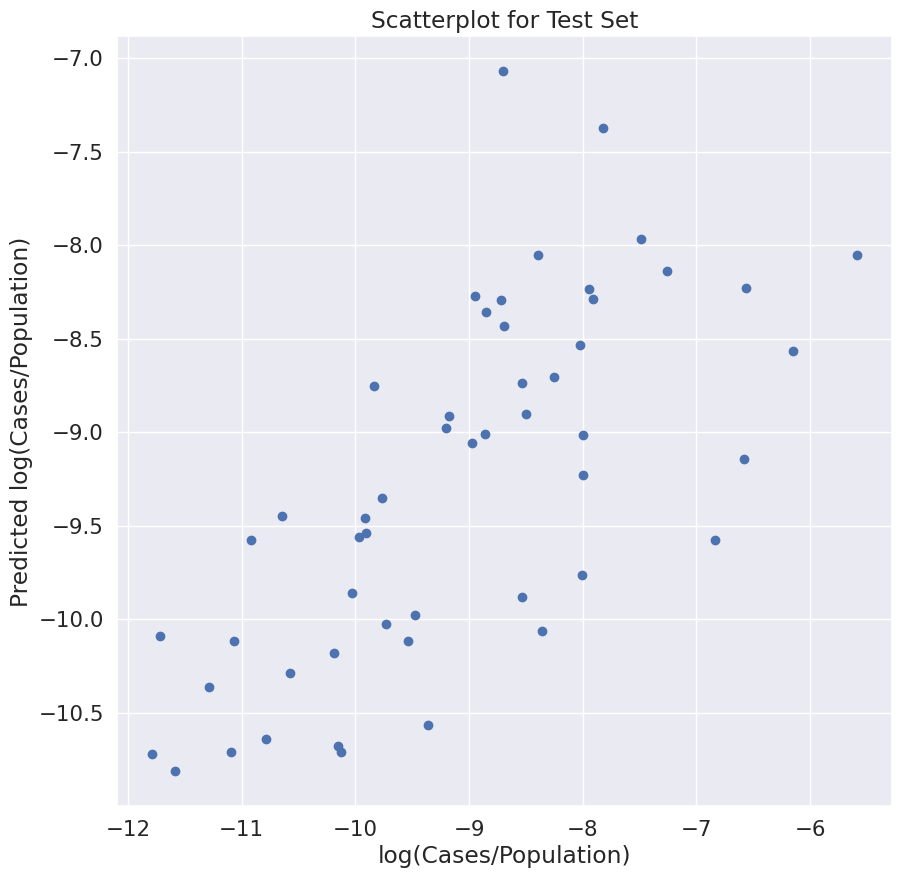

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.34542 +/- 0.08973
Feature:                Old Young Ratio, Score: 0.01225 +/- 0.02865
Feature:                      Avg. PM10, Score: 0.20209 +/- 0.10479
Feature:                        Avg. NO, Score: 0.38656 +/- 0.13728
Feature:                      Avg. PANS, Score: 0.02988 +/- 0.02423
Feature:                       Avg. SO2, Score: 0.00294 +/- 0.01850


<Figure size 640x480 with 0 Axes>

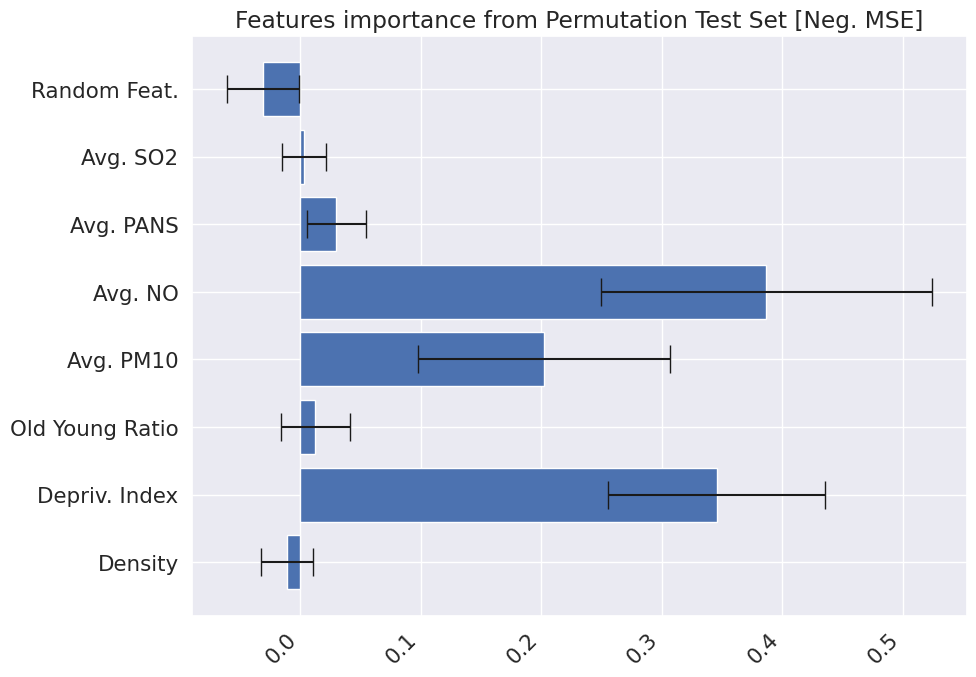

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.16468 +/- 0.04278
Feature:                Old Young Ratio, Score: 0.00584 +/- 0.01366
Feature:                      Avg. PM10, Score: 0.09634 +/- 0.04996
Feature:                        Avg. NO, Score: 0.18429 +/- 0.06545
Feature:                      Avg. PANS, Score: 0.01425 +/- 0.01155
Feature:                       Avg. SO2, Score: 0.00140 +/- 0.00882


<Figure size 640x480 with 0 Axes>

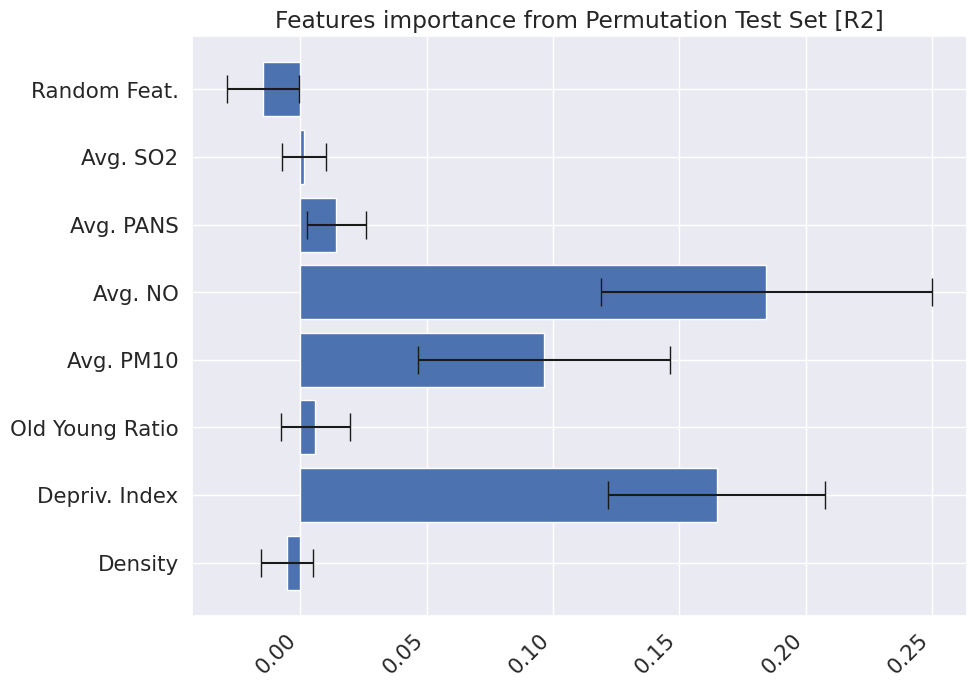

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.32770 +/- 0.05820
Feature:                      Avg. PM10, Score: 0.36285 +/- 0.07453
Feature:                        Avg. NO, Score: 0.53635 +/- 0.09587


<Figure size 640x480 with 0 Axes>

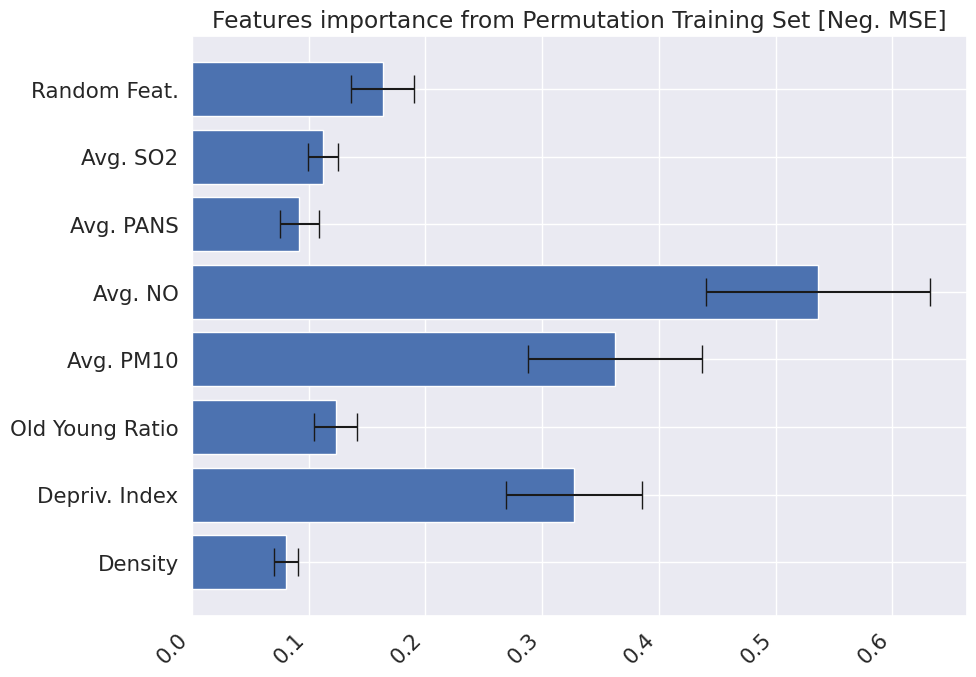

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.16540 +/- 0.02937
Feature:                      Avg. PM10, Score: 0.18313 +/- 0.03762
Feature:                        Avg. NO, Score: 0.27070 +/- 0.04839


<Figure size 640x480 with 0 Axes>

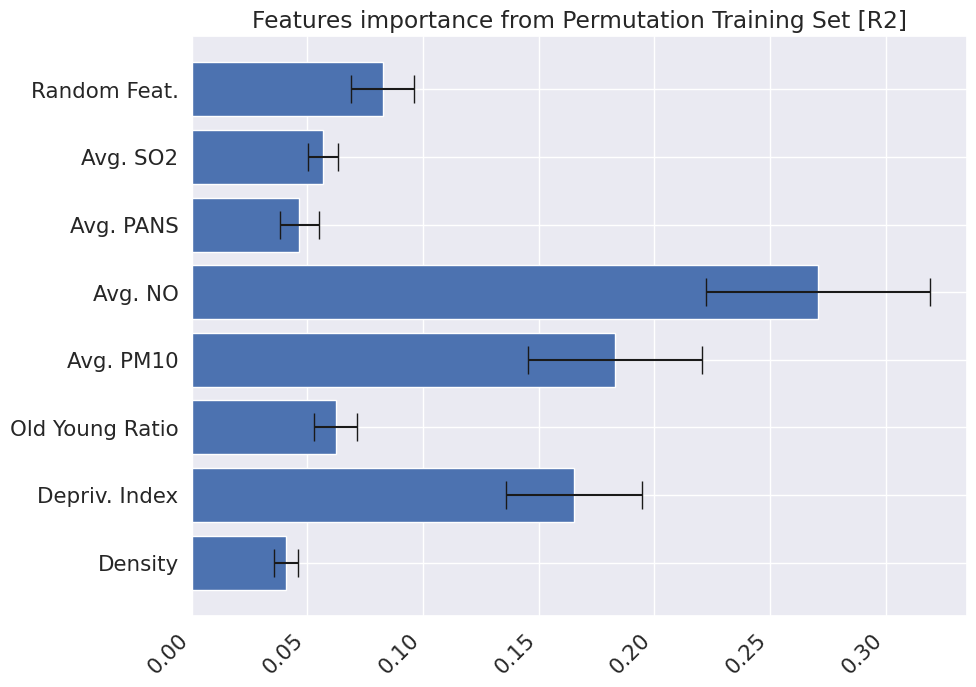

<Figure size 1000x1000 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [17]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}


In [18]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.33738 +/-  0.03186 
    Test set average RMSE:  0.93843 +/-  0.07992 
  Training set average R2:  0.94284 +/-  0.00805 
      Test set average R2:  0.56206 +/-  0.06547 
Taining:
             Density ,    0.04210 +/-    0.03138 ,   -0.00348 +/-    0.01057 ,    0.00000 ,    2.00000 ,    0.00000 ,    1.00000
        Com. Density ,    0.04508 +/-    0.05499 ,   -0.00196 +/-    0.01848 ,    0.00000 ,    1.00000 ,    0.00000 ,    4.00000
       Depriv. Index ,    0.04400 +/-    0.02028 ,    0.00332 +/-    0.00882 ,    0.00000 ,    1.00000 ,    0.00000 ,    4.00000
            Latitude ,    2.29728 +/-    0.52254 ,    0.94812 +/-    0.20504 ,  100.00000 ,    0.00000 ,  100.00000 ,    0.00000
     Old Young Ratio ,    0.10552 +/-    0.07428 ,    0.01303 +/-    0.02217 ,    0.00000 ,   22.00000 ,    0.00000 ,   25.00000
           Avg. PM10 ,    0.11064 +/-    0.07520 ,    0

<Figure size 1000x1000 with 0 Axes>

In [19]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 1}


In [20]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.36967 +/-  0.02952 
    Test set average RMSE:  1.01562 +/-  0.08375 
  Training set average R2:  0.93237 +/-  0.00858 
      Test set average R2:  0.48384 +/-  0.08786 
Taining:
             Density ,    0.05597 +/-    0.02625 ,   -0.00359 +/-    0.01239 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
        Com. Density ,    1.24734 +/-    0.55860 ,    0.49126 +/-    0.19815 ,   85.00000 ,   14.00000 ,   94.00000 ,    6.00000
       Depriv. Index ,    0.11452 +/-    0.10200 ,    0.01748 +/-    0.02840 ,    1.00000 ,    5.00000 ,    0.00000 ,    5.00000
     Old Young Ratio ,    0.14318 +/-    0.07355 ,    0.02913 +/-    0.02574 ,    0.00000 ,   12.00000 ,    0.00000 ,   17.00000
           Avg. PM10 ,    0.17620 +/-    0.14014 ,    0.02236 +/-    0.03101 ,    2.00000 ,   14.00000 ,    0.00000 ,   11.00000
             Avg. NO ,    0.40517 +/-    0.31703 ,    0

<Figure size 1000x1000 with 0 Axes>

In [21]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 1}


In [22]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.38568 +/-  0.02954 
    Test set average RMSE:  1.03694 +/-  0.07259 
  Training set average R2:  0.92737 +/-  0.00982 
      Test set average R2:  0.45743 +/-  0.06622 
Taining:
             Density ,    0.10838 +/-    0.03152 ,    0.00331 +/-    0.01183 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
       Depriv. Index ,    0.44158 +/-    0.11044 ,    0.16167 +/-    0.03761 ,   34.00000 ,   41.00000 ,   49.00000 ,   39.00000
     Old Young Ratio ,    0.14793 +/-    0.03664 ,    0.00627 +/-    0.01624 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
           Avg. PM10 ,    0.36918 +/-    0.11314 ,    0.10048 +/-    0.04131 ,   12.00000 ,   29.00000 ,    4.00000 ,   17.00000
             Avg. NO ,    0.50917 +/-    0.14723 ,    0.16747 +/-    0.04416 ,   54.00000 ,   30.00000 ,   47.00000 ,   44.00000
           Avg. PANS ,    0.11538 +/-    0.02994 ,    0

<Figure size 1000x1000 with 0 Axes>